# Learning the right layers: a data-driven semi-supervised learning model for multilayer graphs

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import math
import sklearn
import scipy
from math import exp,log
from copy import deepcopy
from sklearn.preprocessing import normalize
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import pickle
import numdifftools as nd
import networkx as nx
from matplotlib import pyplot, patches
from scipy import io
import random
import scipy.io
import os
import mat73
from joblib import Parallel, delayed
import time
import scipy.io as sio

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Definitions

### Accuracy functions

In [3]:
# INPUT: E vector expected communities
#        P vector predicted communities
def wrong(E,P):
    
    T = sklearn.metrics.confusion_matrix(E,P) #confusion matrix
    
    n=0 #counts number of nodes in the wrong community
    while T.size != 0:
        M = np.max(T)
        [x,y] = np.where(T==M)
        #use x[0] and y[0] because maybe more entries correspond to maximum value 
        n += np.sum(T[x[0],:]) - T[x[0],y[0]]
        n += np.sum(T[:,y[0]]) - T[x[0],y[0]]
        T = np.delete(T, x[0], axis=0)
        T = np.delete(T, y[0], axis=1)
        
    return n

#accuracy
def accuracy(E,P):
    
    n = wrong(E,P) #number of nodes in the wrong community
    C_exp_len = len(E)
    acc = (C_exp_len-wrong(E,P))/C_exp_len
    
    return acc

def accuracy_final(sol_final,C_indexes_known_union,C_exp):
    labels_found = np.argmax(sol_final, axis=1)
    labels_found = labels_found.transpose()
    labels_found = np.delete(labels_found, obj=C_indexes_known_union) #not consider labeled nodes 
    #return accuracy(C_exp,labels_found.A1)
    return accuracy(C_exp,labels_found)

def accuracy_Yte(sol_final,labels,index_test):
    labels_found_test = np.argmax(sol_final[index_test,:], axis=1)
    labels_found_test = labels_found_test.transpose()
    #return accuracy(labels[index_test],labels_found_test.A1)
    return accuracy(labels[index_test],labels_found_test)

In [4]:
def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = pyplot.figure(figsize=(5, 5)) # in inches
    pyplot.imshow(adjacency_matrix,
                  cmap="Greys",
                  interpolation="none")
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    assert len(partitions) == len(colors)
    ax = pyplot.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth="1"))
            current_idx += len(module)

In [5]:
def unison_shuffled_copies(a, b, c,r):
    assert len(a) == len(b)
    np.random.seed(r)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[b]

### x_sol - solution lower level problem

In [6]:
#lambda fixed
def x_sol(A,N,C,K,lam,theta,y,maxiter=20):
    
    a = theta[K]
    if -1e-2<a<0: 
        a = -1e-2

    M_a = scipy.sparse.csr_matrix((N,N))
    for k in range(0,K):
        M_k = A[k]
        M_k.eliminate_zeros()
        M_a_k = scipy.sparse.csr_matrix.power(M_k,a)
        M_a_k.data[M_a_k.data == np.inf] = 1e+300
        M_a_k.data[M_a_k.data == -np.inf] = -1e+300
        M_a_k = theta[k]*M_a_k
        M_a += M_a_k
    M_a.eliminate_zeros()
    M_a = scipy.sparse.csr_matrix.power(M_a,1/a)
    M_a.data[M_a.data == np.inf] = 1e+300
    M_a.data[M_a.data == -np.inf] = -1e+300
    
    d_a = M_a.sum(axis=1)
    
    x0 = scipy.sparse.csr_matrix((N,C))
      
    #solve system using fixed point iterations
    dd_a = (1 + lam * d_a)
    y_new = y / dd_a
    for i in range(0,maxiter):
        xk = scipy.sparse.csr_matrix.dot(M_a, x0) 
        xk = xk / dd_a
        xk += y_new 
        xk *= lam 
        x0 = xk
    
    return normalize(np.asarray(xk), norm='l1', axis=0)

#lambda variable
def x_sol_(A,N,C,K,theta,y,maxiter=20):
    
    lam = theta[K+1]
    
    a = theta[K]
    if -1e-2<a<0: 
        a = -1e-2

    M_a = scipy.sparse.csr_matrix((N,N))
    for k in range(0,K):
        M_k = A[k]
        M_k.eliminate_zeros()
        M_a_k = scipy.sparse.csr_matrix.power(M_k,a)
        M_a_k.data[M_a_k.data == np.inf] = 1e+300
        M_a_k.data[M_a_k.data == -np.inf] = -1e+300
        M_a_k = theta[k]*M_a_k
        M_a += M_a_k
    M_a.eliminate_zeros()
    M_a = scipy.sparse.csr_matrix.power(M_a,1/a)
    M_a.data[M_a.data == np.inf] = 1e+300
    M_a.data[M_a.data == -np.inf] = -1e+300
    
    d_a = M_a.sum(axis=1)
    
    x0 = scipy.sparse.csr_matrix((N,C))
      
    #solve system using fixed point iterations
    dd_a = (1 + lam * d_a)
    y_new = y / dd_a
    for i in range(0,maxiter):
        xk = scipy.sparse.csr_matrix.dot(M_a, x0) 
        xk = xk / dd_a
        xk += y_new 
        xk *= lam 
        x0 = xk
        
    return normalize(np.asarray(xk), norm='l1', axis=0)

### ZOFW - Zeroth order Frank Wolfe

In [7]:
#Frank Wolfe #inexact gradient #Armijo rule 
sign = lambda x: (1, -1)[x<0]

def ZOFW(x_0,fun_theta,K,Y_te,x_sol_theta_dense,tol):
    #tol = 1e-4 #tollerance method
    max_it = 1e3 #max number iterations
    
    box_a = [-20,20] #box alpha variable
    box_lam = [0.1,10] #box lambda variable
    
    #initialization 
    it = 0
    x_it = x_0
        
    fun_x_it_old = math.inf
    fun_x_it = fun_theta(x_it)
             
    #gradient - Finite-Difference Approximations
    c_it = 1e-4
    grad_x_it = np.zeros(K+2)
    for k in range(0,K+2):
        grad_x_it[k] = (fun_theta(x_it+c_it*np.eye(1,K+2,k)[0]) - fun_x_it ) / c_it 
    grad_lam = grad_x_it[-1]
    grad_a = grad_x_it[-2]
    grad_theta = grad_x_it[:-2]   
        
    #minimize linearize function
    #beta #unit simplex #vector of the canonical basis corrispondent to min index gradient 
    x_it_theta = np.eye(1,K,np.argmin(grad_theta))
    #alpha #box #sign
    if grad_a>0:
        x_it_alpha = box_a[0]
    else:
        x_it_alpha = box_a[1]
    #lambda #box #sign
    if grad_lam>0:
        x_it_lam = box_lam[0]
    else:
        x_it_lam = box_lam[1]
    #argmin  
    x_it_min = np.append(x_it_theta,[x_it_alpha,x_it_lam])
        
    #descent direction
    d_it = x_it_min - x_it
    
    while it<max_it and grad_x_it.dot(d_it) <= -tol and fun_x_it_old-fun_x_it>1e-6:

        it += 1
        fun_x_it_old = fun_x_it 
             
        #step size #Armijo rule
        step = 1
        x_it_d = x_it + step*d_it
        fun_x_it_d = fun_theta(x_it_d)       
        while fun_x_it_d > fun_x_it + 0.1*step*(d_it.dot(grad_x_it)):
            step = step/2
            x_it_d = x_it + step*d_it
            fun_x_it_d = fun_theta(x_it_d)  
        else:
            x_it = x_it_d
        
        fun_x_it = fun_theta(x_it)                 
    
        #gradient - Finite-Difference Approximations
        c_it = c_it/2
        grad_x_it = np.zeros(K+2)
        for k in range(0,K+2):
            grad_x_it[k] = (fun_theta(x_it+c_it*np.eye(1,K+2,k)[0]) - fun_x_it ) / c_it 
        grad_lam = grad_x_it[-1]
        grad_a = grad_x_it[-2]
        grad_theta = grad_x_it[:-2] 
        
        #minimize linearize function
        #beta #unit simplex #vector of the canonical basis corrispondent to min index gradient 
        x_it_theta = np.eye(1,K,np.argmin(grad_theta))
        #alpha #box #sign
        if grad_a>0:
            x_it_alpha = box_a[0]
        else:
            x_it_alpha = box_a[1]
        #lambda #box #sign
        if grad_lam>0:
            x_it_lam = box_lam[0]
        else:
            x_it_lam = box_lam[1]
        #argmin  
        x_it_min = np.append(x_it_theta,[x_it_alpha,x_it_lam])
    
        #descent direction
        d_it = x_it_min - x_it 
        
    return x_it,it

### Cross_entropy - loss function upper level problem

In [8]:
def cross_entropy(N,C,x,x_a):
    
    x = np.transpose(x.toarray())
    #x_a = x_a.toarray()
    
    x_a_ = np.copy(x_a)
    x_a_[x_a_<=1e-15] = 1e-15 #otherwise log(0)=-inf
    log_x_a = np.log(x_a_)
    x_log_x_a = np.matmul(x,log_x_a).item()
    
    x_a_ = 1 - np.copy(x_a)
    x_a_[x_a_<=1e-15] = 1e-15 #otherwise log(0)=-inf
    log_1_x_a = np.log(x_a_)
    x_log_1_x_a = np.matmul(1-x,log_1_x_a).item()
    
    val = -(1/N) * (x_log_x_a + x_log_1_x_a)
    return val

def cross_entropy_multiclass(N,C,x,x_a):

    #num = x_a.toarray()
    num = x_a
    #den = scipy.sparse.csr_matrix.sum(x_a,axis=1)
    den = np.sum(x_a,axis=1)
    den[den==0] = 1 #can not divide by zero 
    frac = num/den[:,None]
    frac[frac<=1e-15] = 1e-15 #otherwise log(0)=-inf   
    #log
    frac_log = np.log(frac)
    
    #cross-entropy
    val = -(1/N) * (np.multiply(x.toarray(),frac_log)).sum() 
    
    return val

### Parallelization functions

In [9]:
def cross_entropy_c(A,N,K,C,Y_tr,Y_te,Y,x_0,cross_entropy,c):
    x_sol_theta = lambda theta: x_sol_(A,N,1,K,theta,Y_tr[:,c])
    fun_theta = lambda theta: cross_entropy(N,C,Y_te[:,c],x_sol_theta(theta))
    theta,it_c = ZOFW(x_0,fun_theta,K,Y_te[:,c],x_sol_theta,1e-4)

    #recalculate solution using selected alpha and all known labels
    x_final = x_sol_(A,N,1,K,theta,Y[:,c])
    loss = cross_entropy(N,C,Y[:,c],x_final)
    
    return x_final,theta,loss

def multistart(A,N,K,C,Y_tr,Y_te,Y,cross_entropy,cross_entropy_c,list_x_0,rrrr):
    #initialization FW
    x_0 = list_x_0[:,rrrr]
    
    x_final_c,theta_c,loss_c = zip(*Parallel(n_jobs=2)(delayed(cross_entropy_c)(A,N,K,C,Y_tr,Y_te,Y,x_0,cross_entropy,c) for c in range(C)))
    #sol_final = scipy.sparse.hstack(x_final_c)
    sol_final = np.hstack(x_final_c)
    theta = np.transpose(np.asarray(theta_c))
    loss = sum(loss_c)
    
    return sol_final,theta,loss

def multistart_multi(A,N,K,C,theta,Y_tr,Y_te,Y,cross_entropy_multi,fun_theta,x_sol_theta,list_x_0,rrrr):
    
    #initialization FW
    x_0 = list_x_0[:,rrrr]
    theta,it = ZOFW(x_0,fun_theta,K,Y_te,x_sol_theta,1e-8)
    
    #recalculate solution using selected alpha and all known labels           
    sol_final = x_sol_(A,N,C,K,theta,Y) 
    loss = cross_entropy_multi(N,C,Y,sol_final)
    
    return sol_final,theta,loss

def methods(A,N,K,C,Y,labels_known_size,perc_,labels,C_indexes_known,sample2,rrr):
    
    labels_test_size = np.rint(labels_known_size*(perc_/100),out=np.zeros(C,int),casting='unsafe')
    labels_train_size = labels_known_size - labels_test_size
    
    index_train = []
    index_test = []
    for c in range(0,C):   
        shift = int(labels_train_size[c]/(2*sample2))
        index_train_c = C_indexes_known[c][rrr*shift:labels_train_size[c]+rrr*shift] #each sample shift windows 
        index_train.append(index_train_c)
        index_test.append(np.setdiff1d(C_indexes_known[c],index_train_c))
    index_train = np.concatenate(index_train)
    index_test = np.concatenate(index_test)
    
    #matrices Y_tr and Y_te #corrispondent to labels training and validation sets
    row = index_train
    comm_list_train = []
    for c in range(0,C):
        comm_list_train.append([c]*labels_train_size[c])
    comm_list_train = np.concatenate(comm_list_train)
    col = np.array(comm_list_train)
    data = np.array(np.ones(sum(labels_train_size)))
    Y_tr = scipy.sparse.csr_matrix((data, (row, col)), shape=(N, C))
    # normalized
    Y_tr = normalize(Y_tr, norm='l1', axis=0)

    row = index_test
    comm_list_test = []
    for c in range(0,C):
        comm_list_test.append([c]*labels_test_size[c])
    comm_list_test = np.concatenate(comm_list_test)
    col = np.array(comm_list_test)
    data = np.array(np.ones(sum(labels_test_size)))
    Y_te = scipy.sparse.csr_matrix((data, (row, col)), shape=(N, C))
    # normalized
    Y_te = normalize(Y_te, norm='l1', axis=0)

    #multi-start #list random initial points FW
    random.seed(rrr)
    np.random.seed(rrr)
    multistart_n = 10
    list_x_0 = np.zeros((K+2,multistart_n))
    for rrrr in range(0,multistart_n):
        list_x_0[:,rrrr] = np.append(np.random.dirichlet(np.ones(K),size=1),[random.uniform(-20,20),random.uniform(0.1,10)]) #[random.uniform(-20,20),1])  
    #last two initial points fixed [1/K,..,1/k,1], [1/K,..,1/k,-1]
    u = np.ones(K+2) / K #theta sum 1 
    u[K] = 1 #alpha
    u[K+1] = 1 #lambda
    w = u.copy()
    w[K] = -1
    w[K+1] = 1 
    list_x_0[:,0] = u
    list_x_0[:,1] = w

    #loss function: binomial classification, each class separate
    #save value function each point #select minimum and corrispondent solution and variables 
    sol_final_multistart,theta_multistart,loss_multistart = zip(*Parallel(n_jobs=2,prefer="threads")(delayed(multistart)(A,N,K,C,Y_tr,Y_te,Y,cross_entropy,cross_entropy_c,list_x_0,rrrr) for rrrr in range(multistart_n)))

    #choose sol corrispondent to min vaue loss 
    index_min = loss_multistart.index(min(loss_multistart))
    sol_final = sol_final_multistart[index_min]
    theta = theta_multistart[index_min]
 
    #calculate accuracy just over Y_tr, in order to choose better sample Y_tr from Y 
    acc_k = accuracy_Yte(sol_final,labels,index_test)
    sol_final_0 = sol_final
    matrix_acc_0 = acc_k
    matrix_theta_0 = theta

    #loss function: multiclass cross-entropy
    x_sol_theta = lambda theta: x_sol_(A,N,C,K,theta,Y_tr)
    fun_theta = lambda theta: cross_entropy_multiclass(N,C,Y_te,x_sol_theta(theta))
    sol_final_multistart,theta_multistart,loss_multistart = zip(*Parallel(n_jobs=2,prefer="threads")(delayed(multistart_multi)(A,N,K,C,theta,Y_tr,Y_te,Y,cross_entropy_multiclass,fun_theta,x_sol_theta,list_x_0,rrrr) for rrrr in range(multistart_n)))

    #choose sol corrispondent to min vaue loss 
    index_min = loss_multistart.index(min(loss_multistart))
    sol_final = sol_final_multistart[index_min]
    theta = theta_multistart[index_min]

    #calculate accuracy just over Y_tr, in order to choose better sample Y_tr from Y 
    acc_k = accuracy_Yte(sol_final,labels,index_test)
    sol_final_1 = sol_final
    matrix_acc_1 = acc_k
    matrix_theta_1 = np.array([theta]*C).transpose()
    
    return matrix_acc_0,sol_final_0,matrix_theta_0,matrix_acc_1,sol_final_1,matrix_theta_1

### Datasets

#### synthetic_datasets

In [10]:
def synthetic_datasets(N,C,K,case,cluster_std,knn,perc):
    
    #random samples
    sample1 = 5 #5 #random matrices A
    sample2 = 5 #5 #division training and test sets Y_tr Y_te #just for proposed methods 

    #list accuracy methods #for each random marix A 
    matrix_acc = np.zeros((K+5+2,sample1))  
    #list values theta,alpha,lambda porposed methods 
    matrix_theta = np.zeros((sample1,2,K+2,C))
    
    #save for state-of the-art-methods in Matlab
    A_save = []
    labels_save = []
    Y_save = []
    for r in tqdm(range(0,sample1)): #random matrices

        #generate weigthed random networks 
        n = 5 #space dimention
        random_state = r #random sample
        X, labels, centers = make_blobs(n_samples=N, centers=C, n_features=n, random_state=random_state,cluster_std=cluster_std, return_centers=True)
        #plt.scatter(X[:, 0], X[:, 1], c=labels)

        #rename labels from 0 
        labels_unique,labels = np.unique(labels, return_inverse=True)  
        # communties size
        C_size = np.zeros(C)
        for com in range(0,C):
            com_ind = np.where(labels == com)
            C_size[com] = len(com_ind[0])

        #generate correspondent affinity matrices
        A = [] #list #A[k] sparse adjacency matrix layer k

        if case=='info2': #informative case #different nodes
            if K>1:
                #1 layer: Euclidean distance
                W = kneighbors_graph(X, n_neighbors=knn, mode='distance', include_self=False)
                W = 0.5 * (W + W.T)
                index_com = np.where(labels == 0)
                for com in range(1,C): 
                    index_com = np.concatenate((index_com, np.where(labels == com)), axis=None)
                W = W[index_com, :]
                W = W[:, index_com]
                A.append(W)
                #others layers random #new generated network #Euclidean distance
                for k in range(1,K):
                    X_, labels_, centers_ = make_blobs(n_samples=N, centers=C, n_features=n, random_state=r+random_state+k,cluster_std=cluster_std, return_centers=True)
                    W_ = kneighbors_graph(X_, n_neighbors=knn, mode='distance', include_self=False)
                    W_ = 0.5 * (W_ + W_.T)
                    #rename labels from 0 
                    labels_unique_,labels_ = np.unique(labels_, return_inverse=True)  
                    # communties size
                    index_com_ = np.where(labels_ == 0)
                    for com in range(1,C): 
                        index_com_ = np.concatenate((index_com_, np.where(labels_ == com)), axis=None)
                    W_ = W_[index_com_, :]
                    W_ = W_[:, index_com_]                   
                    A.append(W_)


        if case=='noisy': #noisy case 
            if K>1:
                #1 layer: Euclidean distance
                W = kneighbors_graph(X, n_neighbors=knn, mode='distance', include_self=False)
                W = 0.5 * (W + W.T)
                A.append(W)
                #2 layer: random 
                #others layers random 
                for k in range(1,K):
                    X_, labels_, centers_ = make_blobs(n_samples=N, centers=C, n_features=n, random_state=r+random_state+k,cluster_std=cluster_std, return_centers=True)
                    W_ = kneighbors_graph(X_, n_neighbors=knn, mode='distance', include_self=False)
                    W_ = 0.5 * (W_ + W_.T)
                    index = np.arange(N)
                    np.random.shuffle(index)
                    W_ = W_[index, :]
                    W_ = W_[:, index]
                    A.append(W_)

        if case=='compl': #complementary case #each layer one community 
            W_list = []
            #1 layer eucledian #info 
            W = kneighbors_graph(X, n_neighbors=knn, mode='distance', include_self=False)
            W = 0.5 * (W + W.T)
            A.append(W)
            #others layers random #less connections
            knn_ = int(knn/3)    
            for k in range(1,K+1):
                X_, labels_, centers_ = make_blobs(n_samples=N, centers=C, n_features=n, random_state=r+random_state+k,cluster_std=cluster_std, return_centers=True)
                W_ = kneighbors_graph(X_, n_neighbors=knn_, mode='distance', include_self=False)
                W_ = 0.5 * (W_ + W_.T)
                index = np.arange(N)
                np.random.shuffle(index)
                W_ = W_[index, :]
                W_ = W_[:, index]
                A.append(W_)

        if case!='info2':
            #reorder A adjacency matrix by communities
            index_com = np.where(labels == 0)
            for com in range(1,C): 
                index_com = np.concatenate((index_com, np.where(labels == com)), axis=None)
            for k in range(0,K):
                A[k] = A[k][index_com, :]
                A[k] = A[k][:, index_com]
                
        labels = []
        for com in range(0,C):
            labels = np.concatenate((labels, [com]*int(C_size[com])), axis=None)

        # communities indeces 
        C_indexes = np.zeros(C, dtype=object)
        for com in range(0,C):
            com_ind = np.where(labels == com)
            C_indexes[com] = com_ind

        # for each community a percentage per of labels are known
        labels_known_size = np.rint(C_size*(perc/100),out=np.zeros(C,int),casting='unsafe') #number of known labels in each community
        labels_known_size[np.where(labels_known_size < 2)] = 2 #at least 2 node labeled each community
        labels_known_size[np.where(C_size == 1)] = 1 #unless community just one node

        if case=='compl':
            #one community each layer
            A_copy = []
            for k in range(0,K):
                A_copy.append(A[k].copy())
            sum_com = 0
            for k in range(0,K):
                sum_com_old = sum_com
                sum_com += int(C_size[k])
                A[k+1][sum_com_old:sum_com, sum_com_old:sum_com] = A_copy[0][sum_com_old:sum_com, sum_com_old:sum_com]
            del A[0]

        #normalize matrices 
        for k in range(0,K):
            A[k] = A[k]/A[k].max()

        A_save.append(A)
        labels_save.append(labels)

#         #plot communities
#         for k in range(0,K):
#             G = nx.from_scipy_sparse_matrix(A[k])
#             draw_adjacency_matrix(G) 

        #Y known labels
        np.random.seed(0) 
        C_indexes_known = np.zeros(C, dtype=object)
        for com in range(0,C):
            C_indexes_known[com] = np.random.choice(C_indexes[com][0],labels_known_size[com],replace=False)

        # Y matrix #known labels
        C_indexes_known_union = np.concatenate(C_indexes_known)
        comm_list = []
        for c in range(0,C):
            comm_list.append([c]*labels_known_size[c])
        comm_list = np.concatenate(comm_list)
        row = C_indexes_known_union
        col = np.array(comm_list)
        data = np.array(np.ones(sum(labels_known_size)))
        Y = scipy.sparse.csr_matrix((data, (row, col)), shape=(N, C))
        # normalized
        Y = normalize(Y, norm='l2', axis=0) #check scipy.sparse.linalg.norm(Y, axis=0)

        # expected communities (without known labels) #to calculate final accuracy
        C_exp = np.delete(labels, obj=C_indexes_known_union)

        Y_save.append(Y)
            
        #acc_single_layers
        for k in range(0,K):
            theta = np.ones((1,2))[0]
            sol_final = x_sol([A[k]],N,C,1,1,theta,Y)
            acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
            matrix_acc[k,r] = acc_k
            
        #alpha=1 #arithmetic mean     
        a = 1 #alpha 1
        theta = np.ones(K+1) / K #theta sum 1 
        theta[-1] = 1 #alpha 1
        sol_final = x_sol(A,N,C,K,1,theta,Y)
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K,r]  = acc_k

        #alpha=-1 #harmonic mean    
        sol_final = scipy.sparse.lil_matrix((N,C))
        theta = np.ones(K+1) / K #theta sum 1 
        theta[-1] = -1 #alpha -1
        sol_final = x_sol(A,N,C,K,1,theta,Y)
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K+1,r]  = acc_k

        #alpha=+inf #maximum    
        A_max = A[0]
        for k in range(0,K-1):
            A_max = A_max.maximum(A[k+1])
        theta = np.ones((1,2))[0]
        sol_final = x_sol([A_max],N,C,1,1,theta,Y)
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K+2,r]  = acc_k

        #alpha=-inf #minimum    
        A_min = A[0]
        for k in range(0,K-1):
            A_min = A_min.minimum(A[k+1])
        theta = np.ones((1,2))[0]
        sol_final = x_sol([A_min],N,C,1,1,theta,Y)
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K+3,r]  = acc_k

        #alpha=0 #geometric mean    
        A_prod = A[0]
        for k in range(0,K-1):
            A_prod = A_prod.multiply(A[k+1])
        A_prod = scipy.sparse.csr_matrix.power(A_prod,1/K)
        theta = np.ones((1,2))[0]
        sol_final = x_sol([A_prod],N,C,1,1,theta,Y)
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K+4,r]  = acc_k 
        
       #proposed methods #parallelize sampling training and test sets
        perc_ = 80 #percentage test set
        matrix_acc_0,sol_final_0,matrix_theta_0,matrix_acc_1,sol_final_1,matrix_theta_1 = zip(*Parallel(n_jobs=2,prefer="threads")(delayed(methods)(A,N,K,C,Y,labels_known_size,perc_,labels,C_indexes_known,sample2,rrr) for rrr in range(sample2)))
        
        argmax0 = np.argmax(matrix_acc_0)
        sol_final = sol_final_0[argmax0]
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K+5,r]  = acc_k
        matrix_theta[r,0,:,:]=matrix_theta_0[argmax0]

        argmax1 = np.argmax(matrix_acc_1)
        sol_final = sol_final_1[argmax1]
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K+6,r]  = acc_k
        matrix_theta[r,1,:,:]=matrix_theta_1[argmax1]
                   
    #save matrix results samples
    with open('Results/matrix_acc_theta_N'+str(N)+'_C'+str(C)+'_case '+case+'_std'+str(cluster_std)+'_knn'+str(knn)+'_perc'+str(perc)+'_sample'+str(sample1),"wb") as fp:
        pickle.dump(matrix_acc,fp)
    with open('Results/matrix_theta_theta_N'+str(N)+'_C'+str(C)+'_case '+case+'_std'+str(cluster_std)+'_knn'+str(knn)+'_perc'+str(perc)+'_sample'+str(sample1),"wb") as fp:
        pickle.dump(matrix_theta,fp)
        
    #save for state-of the-art-methods in Matlab
    my_file = 'Results/Datasets_Matlab/Matlab_theta_N'+str(N)+'_C'+str(C)+'_case '+case+'_std'+str(cluster_std)+'_knn'+str(knn)+'_perc'+str(perc)+'_sample'+str(sample1)+".mat"
    scipy.io.savemat(my_file, dict(A_list=A_save, Y_list=Y_save, labels_list=labels_save))
    
    return matrix_acc,matrix_theta

#### real_datasets

In [11]:
#dict number communities
datasets_list = ["3sources","BBCSport2view_544","BBC4view_685","WikipediaArticles","cora","citeseer","dkpol","aucs","UCI_mfeat"]
dict_dataset_K = dict(zip(datasets_list,[3,2,4,2,2,2,3,5,6]))
dict_dataset_C = dict(zip(datasets_list,[6,5,5,10,7,6,10,9,10]))

In [12]:
def info_datasets(datasets_list):
    for dataset in datasets_list: 
        my_path = 'Datasets'   
        my_file = dataset+".mat"
        file_path = os.path.join(my_path, my_file)
        data = scipy.io.loadmat(file_path)
        X = data['W_cell']
        if dataset in ["UCI_mfeat","cora","citeseer"]:
            labels = data['labels'].toarray().transpose()[0]
        else:
            labels = data['labels'].toarray()[0]
        #information 
        N = len(labels) #number of nodes
        #rename labels from 0 
        labels_unique,labels = np.unique(labels, return_inverse=True) 
        C = len(labels_unique) #number of communities 
        K = len(X) #number layers
        print(dataset + ' - nodes: ' + str(N) + ', communities: ' + str(C) + ', layers: ' + str(K))

In [13]:
def real_datasets(dataset,knn,perc): 
    
    #random samples
    sample1 = 5 #known labels Y
    sample2 = 5 #division training and test sets Y_tr Y_te #just for proposed methods 
    
    #download matrix 
    my_path = 'Datasets'   
    my_file = dataset+".mat"
    file_path = os.path.join(my_path, my_file)
    data = scipy.io.loadmat(file_path)
    X = data['W_cell']
    if dataset in ["UCI_mfeat","cora","citeseer"]:
        labels = data['labels'].toarray().transpose()[0]
    else:
        labels = data['labels'].toarray()[0]
    #information 
    N = len(labels) #number of nodes
    #rename labels from 0 
    labels_unique,labels = np.unique(labels, return_inverse=True) 
    C = len(labels_unique) #number of communities 
    K = len(X) #number layers

    #list accuracy methods #for each random marix A 
    matrix_acc = np.zeros((K+5+2,sample1))  
    #list values theta and alpha porposed methods 
    matrix_theta = np.zeros((sample1,2,K+2,C))
    
    # communities indeces # communties size
    C_size = np.zeros(C)
    for com in range(0,C):
        com_ind = np.where(labels == com)
        #C_indexes[com] = com_ind
        C_size[com] = len(com_ind[0])

    #reorder A adjacency matrix by communities
    index_com = np.where(labels == 0)
    for com in range(1,C): 
        index_com = np.concatenate((index_com, np.where(labels == com)), axis=None)

    A = list(X)
    for k in range(0,K):
        A[k] = A[k][0]

    for k in range(0,K):
        A[k] = A[k][index_com, :]
        A[k] = A[k][:, index_com]

    labels = []
    for com in range(0,C):
        labels = np.concatenate((labels, [com]*int(C_size[com])), axis=None)

    # communities indeces # communties size
    C_indexes = np.zeros(C, dtype=object)
    for com in range(0,C):
        com_ind = np.where(labels == com)
        C_indexes[com] = com_ind

    # for each community a percentage of labels are known
    #perc = 10 #percentage known labels each community 
    labels_known_size = np.rint(C_size*(perc/100),out=np.zeros(C,int),casting='unsafe') #number of known labels in each community
    labels_known_size[np.where(labels_known_size < 2)] = 2 #at least 2 node labeled each community
    labels_known_size[np.where(C_size == 1)] = 1 #unless community just one node

    # #normalize matrices 
    # for k in range(0,K):
    #     A[k] = A[k]/A[k].max()

    # for k in range(0,K):
    #     G = nx.from_scipy_sparse_matrix(A[k])
    #     draw_adjacency_matrix(G)

    Y_save = [] #save for state-of the-art-methods in Matlab
    for r in tqdm(range(0,sample1)): #random indices know labels Y
               
        # indices know labels each community 
        np.random.seed(r) 
        C_indexes_known = np.zeros(C, dtype=object)
        for com in range(0,C):
            C_indexes_known[com] = np.random.choice(C_indexes[com][0],labels_known_size[com],replace=False)
  
        # Y matrix #known labels
        C_indexes_known_union = np.concatenate(C_indexes_known)
        comm_list = []
        for c in range(0,C):
            comm_list.append([c]*labels_known_size[c])
        comm_list = np.concatenate(comm_list)
        row = C_indexes_known_union
        col = np.array(comm_list)
        data = np.array(np.ones(sum(labels_known_size)))
        Y = scipy.sparse.csr_matrix((data, (row, col)), shape=(N, C))
        # normalized
        Y = normalize(Y, norm='l2', axis=0) #check scipy.sparse.linalg.norm(Y, axis=0)
        
        # expected communities (without known labels) #to calculate final accuracy
        C_exp = np.delete(labels, obj=C_indexes_known_union)

        Y_save.append(Y)
        
        #acc_single_layers
        for k in range(0,K):
            theta = np.ones((1,2))[0]
            sol_final = x_sol([A[k]],N,C,1,1,theta,Y)
            acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
            matrix_acc[k,r] = acc_k
            
        #alpha=1 #arithmetic mean     
        a = 1 #alpha 1
        theta = np.ones(K+1) / K #theta sum 1 
        theta[-1] = 1 #alpha 1
        sol_final = x_sol(A,N,C,K,1,theta,Y)
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K,r]  = acc_k

        #alpha=-1 #harmonic mean    
        sol_final = scipy.sparse.lil_matrix((N,C))
        theta = np.ones(K+1) / K #theta sum 1 
        theta[-1] = -1 #alpha -1
        sol_final = x_sol(A,N,C,K,1,theta,Y)
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K+1,r]  = acc_k

        #alpha=+inf #maximum    
        A_max = A[0]
        for k in range(0,K-1):
            A_max = A_max.maximum(A[k+1])
        theta = np.ones((1,2))[0]
        sol_final = x_sol([A_max],N,C,1,1,theta,Y)
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K+2,r]  = acc_k

        #alpha=-inf #minimum    
        A_min = A[0]
        for k in range(0,K-1):
            A_min = A_min.minimum(A[k+1])
        theta = np.ones((1,2))[0]
        sol_final = x_sol([A_min],N,C,1,1,theta,Y)
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K+3,r]  = acc_k

        #alpha=0 #geometric mean    
        A_prod = A[0]
        for k in range(0,K-1):
            A_prod = A_prod.multiply(A[k+1])
        A_prod = scipy.sparse.csr_matrix.power(A_prod,1/K)
        theta = np.ones((1,2))[0]
        sol_final = x_sol([A_prod],N,C,1,1,theta,Y)
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K+4,r]  = acc_k 

        #proposed methods #parallelize sampling training and test sets
        perc_ = 80 #perc_ = 50 #percentage test set
        matrix_acc_0,sol_final_0,matrix_theta_0,matrix_acc_1,sol_final_1,matrix_theta_1 = zip(*Parallel(n_jobs=2,prefer="threads")(delayed(methods)(A,N,K,C,Y,labels_known_size,perc_,labels,C_indexes_known,sample2,rrr) for rrr in range(sample2)))

        argmax0 = np.argmax(matrix_acc_0)
        sol_final = sol_final_0[argmax0]
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K+5,r]  = acc_k
        matrix_theta[r,0,:,:]=matrix_theta_0[argmax0]

        argmax1 = np.argmax(matrix_acc_1)
        sol_final = sol_final_1[argmax1]
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        matrix_acc[K+6,r]  = acc_k
        matrix_theta[r,1,:,:]=matrix_theta_1[argmax1]
                
    #save matrix results samples
    with open("Results_Real/Matlab_acc_theta_"+dataset+'_knn'+str(knn)+'_perc'+str(perc),"wb") as fp:
        pickle.dump(matrix_acc,fp)
    with open("Results_Real/Matlab_theta_theta_"+dataset+'_knn'+str(knn)+'_perc'+str(perc),"wb") as fp:
        pickle.dump(matrix_theta,fp)
    #save for state-of the-art-methods in Matlab 
    my_file = "Results_Real/Datasets_Matlab_Real/Matlab_"+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(lam)+".mat"
    scipy.io.savemat(my_file, dict(A_list=A, Y_list=Y_save, labels_list=labels))

    return matrix_acc,matrix_theta

In [14]:
def real_datasets_noisy(dataset,knn,perc,rand_layers): 
    
    #random samples
    sample1 = 3 #known labels Y
    sample2 = 5 #division training and test sets Y_tr Y_te #just for proposed methods
    sample3 = 3 #random layers added 

    #download matrix 
    my_path = 'Datasets'   
    my_file = dataset+".mat"
    file_path = os.path.join(my_path, my_file)
    data = scipy.io.loadmat(file_path)
    X = data['W_cell']
    if dataset in ["UCI_mfeat","cora","citeseer"]:
        labels = data['labels'].toarray().transpose()[0]
    else:
        labels = data['labels'].toarray()[0]
    #information 
    N = len(labels) #number of nodes
    #rename labels from 0 
    labels_unique,labels = np.unique(labels, return_inverse=True) 
    C = len(labels_unique) #number of communities 
    K = len(X) #number layers

    # communities indeces # communties size
    #C_indexes = np.zeros(C, dtype=object)
    C_size = np.zeros(C)
    for com in range(0,C):
        com_ind = np.where(labels == com)
        #C_indexes[com] = com_ind
        C_size[com] = len(com_ind[0])

    #reorder A adjacency matrix by communities
    index_com = np.where(labels == 0)
    for com in range(1,C): 
        index_com = np.concatenate((index_com, np.where(labels == com)), axis=None)

    A_ = list(X)
    for k in range(0,K):
        A_[k] = A_[k][0]

    for k in range(0,K):
        A_[k] = A_[k][index_com, :]
        A_[k] = A_[k][:, index_com]

    labels = []
    for com in range(0,C):
        labels = np.concatenate((labels, [com]*int(C_size[com])), axis=None)

    # communities indeces # communties size
    C_indexes = np.zeros(C, dtype=object)
    for com in range(0,C):
        com_ind = np.where(labels == com)
        C_indexes[com] = com_ind

    # for each community a percentage of labels are known
    #perc = 10 #percentage known labels each community 
    labels_known_size = np.rint(C_size*(perc/100),out=np.zeros(C,int),casting='unsafe') #number of known labels in each community
    labels_known_size[np.where(labels_known_size < 2)] = 2 #at least 2 node labeled each community
    labels_known_size[np.where(C_size == 1)] = 1 #unless community just one node

#     # for k in range(0,K):
#     #     G = nx.from_scipy_sparse_matrix(A_[k])
#     #     draw_adjacency_matrix(G)

    list_acc = [] #save sample3 random layers added 
    list_theta = []
    list_A_save = []
    list_Y_save = []

    K = K + rand_layers #number layers
    #list accuracy methods #for each random marix A 
    matrix_acc = np.zeros((K+5+2,sample1))  
    #list values theta and alpha porposed methods 
    matrix_theta = np.zeros((sample1,2,K+2,C))
    
    for rrr in tqdm(range(0,sample3)): #random layers added 
        
        A = A_.copy()
        
        #generate weigthed random networks 
        n = 5 #space dimention
        random_state = rrr #random sample
        cluster_std = 8
        for k in range(K-rand_layers,K):  
            X_, labels_, centers_ = make_blobs(n_samples=N, centers=C, n_features=n, random_state=random_state+k,cluster_std=cluster_std, return_centers=True)
            W_ = kneighbors_graph(X_, n_neighbors=knn, mode='distance', include_self=False)
            W_ = 0.5 * (W_ + W_.T)
            index = np.arange(N)
            np.random.shuffle(index)
            W_ = W_[index, :]
            W_ = W_[:, index]
            A.append(W_)
           
        #correspondent adjacency matrix - unweighted 
        for k in range(0,K):
            A[k].data[:] = 1

        # for k in range(0,K):
        #     G = nx.from_scipy_sparse_matrix(A[k])
        #     draw_adjacency_matrix(G)

        Y_save = [] #save for state-of the-art-methods in Matlab
        for r in tqdm(range(0,sample1)): #random indices know labels Y
        
            # indices know labels each community 
            np.random.seed(r) 
            C_indexes_known = np.zeros(C, dtype=object)
            for com in range(0,C):
                C_indexes_known[com] = np.random.choice(C_indexes[com][0],labels_known_size[com],replace=False)

            # Y matrix #known labels
            C_indexes_known_union = np.concatenate(C_indexes_known)
            comm_list = []
            for c in range(0,C):
                comm_list.append([c]*labels_known_size[c])
            comm_list = np.concatenate(comm_list)
            row = C_indexes_known_union
            col = np.array(comm_list)
            data = np.array(np.ones(sum(labels_known_size)))
            Y = scipy.sparse.csr_matrix((data, (row, col)), shape=(N, C))
            # normalized
            Y = normalize(Y, norm='l2', axis=0) #check scipy.sparse.linalg.norm(Y, axis=0)

            # expected communities (without known labels) #to calculate final accuracy
            C_exp = np.delete(labels, obj=C_indexes_known_union)

            Y_save.append(Y)

            #acc_single_layers
            for k in range(0,K):
                theta = np.ones((1,2))[0]
                sol_final = x_sol([A[k]],N,C,1,1,theta,Y)
                acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
                matrix_acc[k,r] = acc_k

            #alpha=1 #arithmetic mean     
            a = 1 #alpha 1
            theta = np.ones(K+1) / K #theta sum 1 
            theta[-1] = 1 #alpha 1
            sol_final = x_sol(A,N,C,K,1,theta,Y)
            acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
            matrix_acc[K,r]  = acc_k

            #alpha=-1 #harmonic mean    
            sol_final = scipy.sparse.lil_matrix((N,C))
            theta = np.ones(K+1) / K #theta sum 1 
            theta[-1] = -1 #alpha -1
            sol_final = x_sol(A,N,C,K,1,theta,Y)
            acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
            matrix_acc[K+1,r]  = acc_k

            #alpha=+inf #maximum    
            A_max = A[0]
            for k in range(0,K-1):
                A_max = A_max.maximum(A[k+1])
            theta = np.ones((1,2))[0]
            sol_final = x_sol([A_max],N,C,1,1,theta,Y)
            acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
            matrix_acc[K+2,r]  = acc_k

            #alpha=-inf #minimum    
            A_min = A[0]
            for k in range(0,K-1):
                A_min = A_min.minimum(A[k+1])
            theta = np.ones((1,2))[0]
            sol_final = x_sol([A_min],N,C,1,1,theta,Y)
            acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
            matrix_acc[K+3,r]  = acc_k

            #alpha=0 #geometric mean    
            A_prod = A[0]
            for k in range(0,K-1):
                A_prod = A_prod.multiply(A[k+1])
            A_prod = scipy.sparse.csr_matrix.power(A_prod,1/K)
            theta = np.ones((1,2))[0]
            sol_final = x_sol([A_prod],N,C,1,1,theta,Y)
            acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
            matrix_acc[K+4,r]  = acc_k 

            #proposed methods #parallelize sampling training and test sets
            perc_ = 80 #perc_ = 50 #percentage test set
            matrix_acc_0,sol_final_0,matrix_theta_0,matrix_acc_1,sol_final_1,matrix_theta_1 = zip(*Parallel(n_jobs=2,prefer="threads")(delayed(methods)(A,N,K,C,Y,labels_known_size,perc_,labels,C_indexes_known,sample2,rrr) for rrr in range(sample2)))

            argmax0 = np.argmax(matrix_acc_0)
            sol_final = sol_final_0[argmax0]
            acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
            matrix_acc[K+5,r]  = acc_k
            matrix_theta[r,0,:,:]=matrix_theta_0[argmax0]

            argmax1 = np.argmax(matrix_acc_1)
            sol_final = sol_final_1[argmax1]
            acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
            matrix_acc[K+6,r]  = acc_k
            matrix_theta[r,1,:,:]=matrix_theta_1[argmax1]
                
        #save in list 
        list_A_save.append(A)
        list_Y_save.append(Y_save)
        list_acc.append(matrix_acc)  
        list_theta.append(matrix_theta)
  
    #save matrix results samples 
    with open("Results_Real/Matlab_acc_theta_"+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_Knoisy'+str(rand_layers),"wb") as fp:
        pickle.dump(list_acc,fp)
    with open("Results_Real/Matlab_theta_theta_"+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_Knoisy'+str(rand_layers),"wb") as fp:
        pickle.dump(list_theta,fp)
    #save for state-of the-art-methods in Matlab 
    my_file = "Results_Real/Datasets_Matlab_Real/Matlab_"+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(lam)+'_Knoisy'+str(rand_layers)+".mat"
    scipy.io.savemat(my_file, dict(A_list=list_A_save, Y_list=list_Y_save, labels_list=labels))

    return list_acc,list_theta

## Tests

#### synthetic_datasets

In [17]:
N = 1200 #number of nodes
C = 3 #number of communities
K = 3 #number layers
perc = 20 #percentage known labels per community

In [ ]:
case = 'info2' 
knn = 5 
for cluster_std in [5,6,7,8]:
    matrix_acc,matrix_theta = synthetic_datasets(N,C,K,case,cluster_std,knn,perc)

In [ ]:
case = 'compl' 
knn = 5 
for cluster_std in [2,3,4,5]:
    matrix_acc,matrix_theta = synthetic_datasets(N,C,K,case,cluster_std,knn,perc)

In [ ]:
case = 'noisy' 
knn = 5 
for cluster_std in [2,3,4,5]:
    matrix_acc,matrix_theta = synthetic_datasets(N,C,K,case,cluster_std,knn,perc)

#### real_datasets

In [36]:
info_datasets(datasets_list)

3sources - nodes: 169, communities: 6, layers: 3
BBCSport2view_544 - nodes: 544, communities: 5, layers: 2
BBC4view_685 - nodes: 685, communities: 5, layers: 4
WikipediaArticles - nodes: 693, communities: 10, layers: 2
cora - nodes: 2708, communities: 7, layers: 2
citeseer - nodes: 3312, communities: 6, layers: 2
dkpol - nodes: 490, communities: 10, layers: 3
aucs - nodes: 61, communities: 9, layers: 5
UCI_mfeat - nodes: 2000, communities: 10, layers: 6


In [ ]:
knn = 5
for dataset in datasets_list:
    for perc in [15,10,5,1]: 
        matrix_acc,matrix_theta  = real_datasets(dataset,knn,perc)

In [ ]:
knn = 5
rand_layers = 1
for dataset in datasets_list:
    for perc in [15,10,5,1]: 
        matrix_acc,matrix_theta  = real_datasets_noisy(dataset,knn,perc,rand_layers)

In [ ]:
knn = 5
rand_layers = 2
for dataset in datasets_list:
    for perc in [15,10,5,1]: 
        matrix_acc,matrix_theta  = real_datasets_noisy(dataset,knn,perc,rand_layers)

## Print results

#### synthetic_datasets

In [16]:
#accuracy
def results_statistics_synthetic(N,C,K,case,cluster_std,knn,perc):
    
    sample1 = 5
    
    #download matrix
    with open('Results/matrix_acc_theta_N'+str(N)+'_C'+str(C)+'_case '+case+'_std'+str(cluster_std)+'_knn'+str(knn)+'_perc'+str(perc)+'_sample'+str(sample1),"rb") as fp:
        matrix_acc = pickle.load(fp)
    
    method_names = []
    for i in range(0,K):
        method_names.append('layer '+str(i+1))
    method_names = method_names + ['arithmetic', 
    'harmonic',
    'maximum',
    'minimum',
    'geometric',
    'binomial',
    'multi']

    #mean and std all methods respect to random networks
    matrix_acc_mean = np.mean(matrix_acc,axis=1)
    matrix_acc_std = np.std(matrix_acc,axis=1)
    
    matrix_acc_mean_df = pd.DataFrame(list(zip(method_names,matrix_acc_mean,matrix_acc_std)))
    matrix_acc_mean_df.columns = ['method', 'acc_mean','acc_std']
    
    return matrix_acc_mean_df

In [36]:
N = 1200 #number of nodes
C = 3 #number of communities
K = 3 #number layers
perc = 20 #percentage known labels per community

In [37]:
case = 'info2' 
print("case "+case)
knn = 5 
perc = 20
for cluster_std in [5,6,7,8]:
    print("std "+str(cluster_std))
    matrix_acc_mean = results_statistics_synthetic(N,C,K,case,cluster_std,knn,perc)
    display(matrix_acc_mean)

case info2
std 5


,method,acc_mean,acc_std
0,layer 1,0.827292,0.098538
1,layer 2,0.864583,0.052787
2,layer 3,0.840833,0.098468
3,arithmetic,0.952500,0.033937
4,harmonic,0.963333,0.027985
5,maximum,0.960625,0.030960
6,minimum,0.333333,0.000000
7,geometric,0.333333,0.000000
8,binomial,0.957708,0.029134
9,multi,0.931875,0.040902


std 6


,method,acc_mean,acc_std
0,layer 1,0.766667,0.105906
1,layer 2,0.802292,0.048104
2,layer 3,0.790000,0.113157
3,arithmetic,0.904167,0.053493
4,harmonic,0.922917,0.043725
5,maximum,0.916667,0.046863
6,minimum,0.333333,0.000000
7,geometric,0.333333,0.000000
8,binomial,0.918750,0.046468
9,multi,0.886875,0.058018


std 7


,method,acc_mean,acc_std
0,layer 1,0.712917,0.100082
1,layer 2,0.741458,0.046828
2,layer 3,0.741250,0.105912
3,arithmetic,0.859583,0.072581
4,harmonic,0.879583,0.065274
5,maximum,0.872917,0.066068
6,minimum,0.333333,0.000000
7,geometric,0.333333,0.000000
8,binomial,0.853542,0.069443
9,multi,0.805000,0.091198


std 8


,method,acc_mean,acc_std
0,layer 1,0.663542,0.097710
1,layer 2,0.687083,0.044222
2,layer 3,0.695000,0.111074
3,arithmetic,0.807083,0.083918
4,harmonic,0.825208,0.083363
5,maximum,0.820833,0.085868
6,minimum,0.333333,0.000000
7,geometric,0.333333,0.000000
8,binomial,0.809375,0.068151
9,multi,0.748125,0.061465


In [38]:
case = 'compl'
print("case "+case)
knn = 5 
perc = 20
for cluster_std in [2,3,4,5]:
    print("std "+str(cluster_std))
    matrix_acc_mean = results_statistics_synthetic(N,C,K,case,cluster_std,knn,perc)
    display(matrix_acc_mean)

case compl
std 2


,method,acc_mean,acc_std
0,layer 1,0.412500,0.004796
1,layer 2,0.472708,0.003920
2,layer 3,0.481667,0.014047
3,arithmetic,0.887083,0.018395
4,harmonic,0.937500,0.018222
5,maximum,0.922500,0.019793
6,minimum,0.333333,0.000000
7,geometric,0.333333,0.000000
8,binomial,0.862083,0.030431
9,multi,0.892917,0.018095


std 3


,method,acc_mean,acc_std
0,layer 1,0.408125,0.005683
1,layer 2,0.469167,0.006201
2,layer 3,0.472708,0.012866
3,arithmetic,0.858333,0.042148
4,harmonic,0.901875,0.045488
5,maximum,0.888958,0.045513
6,minimum,0.333333,0.000000
7,geometric,0.333333,0.000000
8,binomial,0.868125,0.041846
9,multi,0.863958,0.040077


std 4


,method,acc_mean,acc_std
0,layer 1,0.397083,0.008873
1,layer 2,0.463542,0.008015
2,layer 3,0.472292,0.013414
3,arithmetic,0.823750,0.058253
4,harmonic,0.860417,0.057297
5,maximum,0.847500,0.057764
6,minimum,0.333333,0.000000
7,geometric,0.333333,0.000000
8,binomial,0.816250,0.013639
9,multi,0.828958,0.058643


std 5


,method,acc_mean,acc_std
0,layer 1,0.396667,0.012611
1,layer 2,0.459375,0.017167
2,layer 3,0.466250,0.011741
3,arithmetic,0.789792,0.070238
4,harmonic,0.822500,0.077105
5,maximum,0.810833,0.074718
6,minimum,0.333333,0.000000
7,geometric,0.333333,0.000000
8,binomial,0.809583,0.068555
9,multi,0.798542,0.067362


In [39]:
case = 'noisy' 
print("case "+case)
knn = 5 
perc = 20
for cluster_std in [2,3,4,5]:
    print("std "+str(cluster_std))
    matrix_acc_mean = results_statistics_synthetic(N,C,K,case,cluster_std,knn,perc)
    display(matrix_acc_mean)

case noisy
std 2


,method,acc_mean,acc_std
0,layer 1,0.988333,0.018824
1,layer 2,0.350833,0.008675
2,layer 3,0.362292,0.009647
3,arithmetic,0.674375,0.024461
4,harmonic,0.679167,0.026278
5,maximum,0.679792,0.027216
6,minimum,0.333333,0.000000
7,geometric,0.333333,0.000000
8,binomial,0.991042,0.014383
9,multi,0.989375,0.016763


std 3


,method,acc_mean,acc_std
0,layer 1,0.948750,0.050214
1,layer 2,0.350208,0.003118
2,layer 3,0.356875,0.007895
3,arithmetic,0.655000,0.041129
4,harmonic,0.659375,0.041864
5,maximum,0.660833,0.040341
6,minimum,0.333333,0.000000
7,geometric,0.333333,0.000000
8,binomial,0.956875,0.042658
9,multi,0.951458,0.047592


std 4


,method,acc_mean,acc_std
0,layer 1,0.892708,0.077625
1,layer 2,0.357917,0.004040
2,layer 3,0.353333,0.006985
3,arithmetic,0.625625,0.047711
4,harmonic,0.628125,0.050535
5,maximum,0.627708,0.051482
6,minimum,0.333333,0.000000
7,geometric,0.333333,0.000000
8,binomial,0.905000,0.069934
9,multi,0.895417,0.073594


std 5


,method,acc_mean,acc_std
0,layer 1,0.827292,0.098538
1,layer 2,0.352083,0.007655
2,layer 3,0.363333,0.014334
3,arithmetic,0.581875,0.055690
4,harmonic,0.586250,0.058495
5,maximum,0.584583,0.059393
6,minimum,0.333333,0.000000
7,geometric,0.333333,0.000000
8,binomial,0.845208,0.092783
9,multi,0.836458,0.097010


In [19]:
#weights
def weights_statistics_synthetic(N,C,K,case,cluster_std,knn,perc):
    
    sample1 = 5
    
    #download matrix
    with open('Results/matrix_theta_theta_N'+str(N)+'_C'+str(C)+'_case '+case+'_std'+str(cluster_std)+'_knn'+str(knn)+'_perc'+str(perc)+'_sample'+str(sample1),"rb") as fp:
        matrix_theta = pickle.load(fp)
    
    method_names = ['binomial','multi']

    #mean and std all methods respect to random networks
    matrix_theta_mean = np.mean(matrix_theta,axis=0) #dim: sample1(5) x methods(2) x theta(5) x C(3)
    matrix_theta_std = np.std(matrix_theta,axis=0)
    
    matrix_theta_mean_bin_df = pd.DataFrame(matrix_theta_mean[0], columns=['K_1', 'K_2', 'K_3'], index=['beta_1', 'beta_2', 'beta_3', 'alpha', 'lambda'])
    matrix_theta_mean_multi_df = pd.DataFrame(matrix_theta_mean[1][:,1],columns=['MULTI'],index=['beta_1', 'beta_2', 'beta_3', 'alpha', 'lambda'])
    
    #matrix_theta_mean_bin_df.to_csv('out.zip', index=False,
    
    return matrix_theta_mean_bin_df,matrix_theta_mean_multi_df

In [43]:
case = 'info2' 
print("case "+case)
knn = 5 
perc = 20
for cluster_std in [5,6,7,8]:
    print("std "+str(cluster_std))
    matrix_theta_mean_bin_df,matrix_theta_mean_multi_df = weights_statistics_synthetic(N,C,K,case,cluster_std,knn,perc)
    display(matrix_theta_mean_bin_df,matrix_theta_mean_multi_df)

case info2
std 5


,K_1,K_2,K_3
beta_1,0.040745,0.4,0.277047
beta_2,0.655208,0.4,0.329882
beta_3,0.304047,0.2,0.393071
alpha,10.270389,12.0,16.380586
lambda,8.200000,10.0,6.400000


,MULTI
beta_1,0.282598
beta_2,0.425512
beta_3,0.291890
alpha,-3.626517
lambda,0.854776


std 6


,K_1,K_2,K_3
beta_1,0.4,0.440745,0.365376
beta_2,0.2,0.455208,0.340108
beta_3,0.4,0.104047,0.294516
alpha,20.0,10.270389,16.291379
lambda,10.0,8.200000,6.400000


,MULTI
beta_1,0.310370
beta_2,0.287937
beta_3,0.401694
alpha,1.936250
lambda,0.708534


std 7


,K_1,K_2,K_3
beta_1,0.491122,0.512039,0.4
beta_2,0.047260,0.386939,0.4
beta_3,0.461618,0.101022,0.2
alpha,10.403619,7.251172,12.0
lambda,8.200000,6.400000,10.0


,MULTI
beta_1,0.237745
beta_2,0.277995
beta_3,0.484260
alpha,-3.471310
lambda,0.840105


std 8


,K_1,K_2,K_3
beta_1,0.596205,0.510074,0.058333
beta_2,0.098360,0.360074,0.483333
beta_3,0.305435,0.129852,0.458333
alpha,14.984787,5.415244,16.675000
lambda,6.625000,6.951146,8.425000


,MULTI
beta_1,0.160276
beta_2,0.457281
beta_3,0.382443
alpha,0.549741
lambda,1.036136


In [44]:
case = 'compl'
print("case "+case)
knn = 5 
perc = 20
for cluster_std in [2,3,4,5]:
    print("std "+str(cluster_std))
    matrix_theta_mean_bin_df,matrix_theta_mean_multi_df = weights_statistics_synthetic(N,C,K,case,cluster_std,knn,perc)
    display(matrix_theta_mean_bin_df,matrix_theta_mean_multi_df)

case compl
std 2


,K_1,K_2,K_3
beta_1,0.728072,0.172147,0.150838
beta_2,0.115673,0.593402,0.208969
beta_3,0.156255,0.234451,0.640193
alpha,-11.330174,-2.210692,-0.304140
lambda,7.577031,4.600000,5.725000


,MULTI
beta_1,0.451263
beta_2,0.181777
beta_3,0.366961
alpha,-3.953005
lambda,0.594762


std 3


,K_1,K_2,K_3
beta_1,0.579767,0.104767,0.184234
beta_2,0.179523,0.654523,0.211043
beta_3,0.240710,0.240710,0.604723
alpha,0.670680,0.670680,4.773669
lambda,5.725000,5.725000,4.522374


,MULTI
beta_1,0.480677
beta_2,0.291565
beta_3,0.227758
alpha,-5.813294
lambda,0.829798


std 4


,K_1,K_2,K_3
beta_1,0.819447,0.194447,0.169447
beta_2,0.092703,0.667703,0.117703
beta_3,0.087850,0.137850,0.712850
alpha,14.058528,3.208528,12.633528
lambda,7.075000,5.725000,6.400000


,MULTI
beta_1,0.387250
beta_2,0.242976
beta_3,0.369774
alpha,-2.158312
lambda,0.629412


std 5


,K_1,K_2,K_3
beta_1,0.766467,0.326416,0.306228
beta_2,0.140519,0.562673,0.164838
beta_3,0.093015,0.110911,0.528934
alpha,10.298521,-2.117483,8.254700
lambda,6.431069,5.257435,4.650370


,MULTI
beta_1,0.369253
beta_2,0.277153
beta_3,0.353594
alpha,2.896446
lambda,0.995644


In [45]:
case = 'noisy'
print("case "+case)
knn = 5 
perc = 20
for cluster_std in [2,3,4,5]:
    print("std "+str(cluster_std))
    matrix_theta_mean_bin_df,matrix_theta_mean_multi_df = weights_statistics_synthetic(N,C,K,case,cluster_std,knn,perc)
    display(matrix_theta_mean_bin_df,matrix_theta_mean_multi_df)

case noisy
std 2


,K_1,K_2,K_3
beta_1,1.0,1.0,1.0
beta_2,0.0,0.0,0.0
beta_3,0.0,0.0,0.0
alpha,20.0,20.0,20.0
lambda,10.0,10.0,10.0


,MULTI
beta_1,1.000000
beta_2,0.000000
beta_3,0.000000
alpha,-1.125000
lambda,2.667812


std 3


,K_1,K_2,K_3
beta_1,1.0,1.0,1.0
beta_2,0.0,0.0,0.0
beta_3,0.0,0.0,0.0
alpha,20.0,20.0,20.0
lambda,10.0,10.0,10.0


,MULTI
beta_1,1.000000
beta_2,0.000000
beta_3,0.000000
alpha,2.054688
lambda,1.368800


std 4


,K_1,K_2,K_3
beta_1,1.0,1.0,1.0
beta_2,0.0,0.0,0.0
beta_3,0.0,0.0,0.0
alpha,20.0,20.0,20.0
lambda,10.0,10.0,10.0


,MULTI
beta_1,0.958589
beta_2,0.004369
beta_3,0.037042
alpha,9.474164
lambda,1.294841


std 5


,K_1,K_2,K_3
beta_1,1.0,1.0,1.0
beta_2,0.0,0.0,0.0
beta_3,0.0,0.0,0.0
alpha,20.0,20.0,20.0
lambda,10.0,10.0,10.0


,MULTI
beta_1,0.962957
beta_2,0.008962
beta_3,0.028081
alpha,7.483713
lambda,4.789367


#### real_datasets

In [31]:
#accuracy
def results_statistics_real(dataset,knn,perc):
    
    #download matrix
    with open("Results_Real/Matlab_acc_theta_"+dataset+'_knn'+str(knn)+'_perc'+str(perc),"rb") as fp:
        matrix_acc = pickle.load(fp)
        
    K = dict_dataset_K[dataset] #layers  
    
    method_names = []
    for i in range(0,K):
        method_names.append('layer '+str(i+1))
    method_names = method_names + ['arithmetic', 
    'harmonic',
    'maximum',
    'minimum',
    'geometric',
    'binomial',
    'multi']

    #mean and std all methods respect to random networks
    matrix_acc_mean = np.mean(matrix_acc,axis=1)
    matrix_acc_std = np.std(matrix_acc,axis=1)
    
    matrix_acc_mean_df = pd.DataFrame(list(zip(method_names,matrix_acc_mean,matrix_acc_std)))
    matrix_acc_mean_df.columns = ['method', 'acc_mean','acc_std']
    
    return matrix_acc_mean_df

In [32]:
def results_statistics_real_noisy(dataset,knn,perc,rand_layers):
    
    sample1 = 3 #known labels Y
    
    #download matrix
    with open("Results_Real/Matlab_acc_theta_"+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_Knoisy'+str(rand_layers),"rb") as fp:        
        list_acc = pickle.load(fp) #len sample3 
        
    K = dict_dataset_K[dataset]+rand_layers #layers  
    
    method_names = []
    for i in range(0,K):
        method_names.append('layer '+str(i+1))
    method_names = method_names + ['arithmetic', 
    'harmonic',
    'maximum',
    'minimum',
    'geometric',
    'binomial',
    'multi']
    
    matrix_acc_mean_ = np.empty([K+7,sample1])
    matrix_acc_std_ = np.empty([K+7,sample1])
    for rrr in range(0,sample1): #random layers added 

        matrix_acc = list_acc[rrr]

        #mean and std all methods respect to random networks
        matrix_acc_mean = np.mean(matrix_acc,axis=1)
        matrix_acc_std = np.std(matrix_acc,axis=1)

        matrix_acc_mean_[:,rrr] = matrix_acc_mean
        matrix_acc_std_[:,rrr] = matrix_acc_std

    matrix_acc_mean = np.mean(matrix_acc_mean_,axis=1)
    matrix_acc_std = np.mean(matrix_acc_std_,axis=1)

    matrix_acc_mean_df = pd.DataFrame(list(zip(method_names,matrix_acc_mean,matrix_acc_std)))
    matrix_acc_mean_df.columns = ['method', 'acc_mean','acc_std']
    
    return matrix_acc_mean_df

In [34]:
knn = 5
for dataset in datasets_list:
    for perc in [15,10,5,1]:  
        print("dataset "+dataset+" - perc "+str(perc))
        matrix_acc_mean = results_statistics_real(dataset,knn,perc)
        display(matrix_acc_mean)

dataset 3sources - perc 15


,method,acc_mean,acc_std
0,layer 1,0.769231,0.041489
1,layer 2,0.751049,0.027478
2,layer 3,0.780420,0.046513
3,arithmetic,0.829371,0.051312
4,harmonic,0.753846,0.040390
5,maximum,0.801399,0.026015
6,minimum,0.742657,0.063386
7,geometric,0.742657,0.063386
8,binomial,0.815385,0.028181
9,multi,0.758042,0.039459


dataset 3sources - perc 10


,method,acc_mean,acc_std
0,layer 1,0.758667,0.044502
1,layer 2,0.724000,0.049459
2,layer 3,0.753333,0.052999
3,arithmetic,0.789333,0.074786
4,harmonic,0.693333,0.050947
5,maximum,0.749333,0.049996
6,minimum,0.705333,0.074643
7,geometric,0.705333,0.074643
8,binomial,0.754667,0.073805
9,multi,0.736000,0.047628


dataset 3sources - perc 5


,method,acc_mean,acc_std
0,layer 1,0.731613,0.054987
1,layer 2,0.720000,0.039687
2,layer 3,0.766452,0.035195
3,arithmetic,0.802581,0.059774
4,harmonic,0.723871,0.027493
5,maximum,0.775484,0.040476
6,minimum,0.680000,0.024346
7,geometric,0.680000,0.024346
8,binomial,0.762581,0.065844
9,multi,0.720000,0.066748


dataset 3sources - perc 1


,method,acc_mean,acc_std
0,layer 1,0.722293,0.051210
1,layer 2,0.690446,0.066755
2,layer 3,0.766879,0.032627
3,arithmetic,0.785987,0.038344
4,harmonic,0.709554,0.038555
5,maximum,0.759236,0.039140
6,minimum,0.658599,0.010349
7,geometric,0.658599,0.010349
8,binomial,0.785987,0.038344
9,multi,0.785987,0.038344


dataset BBCSport2view_544 - perc 15


,method,acc_mean,acc_std
0,layer 1,0.904329,0.005544
1,layer 2,0.896970,0.009928
2,arithmetic,0.936364,0.005231
3,harmonic,0.929004,0.002121
4,maximum,0.931602,0.004457
5,minimum,0.813420,0.011239
6,geometric,0.813420,0.011239
7,binomial,0.936797,0.007792
8,multi,0.911688,0.022091


dataset BBCSport2view_544 - perc 10


,method,acc_mean,acc_std
0,layer 1,0.896538,0.001524
1,layer 2,0.881466,0.010175
2,arithmetic,0.924236,0.009053
3,harmonic,0.918126,0.004536
4,maximum,0.918534,0.004644
5,minimum,0.793890,0.003949
6,geometric,0.793890,0.003949
7,binomial,0.917312,0.016324
8,multi,0.883503,0.010256


dataset BBCSport2view_544 - perc 5


,method,acc_mean,acc_std
0,layer 1,0.892070,0.011502
1,layer 2,0.864603,0.014319
2,arithmetic,0.909478,0.011695
3,harmonic,0.902128,0.009908
4,maximum,0.905222,0.011797
5,minimum,0.783752,0.007966
6,geometric,0.783752,0.007966
7,binomial,0.912959,0.018673
8,multi,0.876596,0.009741


dataset BBCSport2view_544 - perc 1


,method,acc_mean,acc_std
0,layer 1,0.865543,0.037554
1,layer 2,0.763670,0.063774
2,arithmetic,0.868539,0.030367
3,harmonic,0.870037,0.032035
4,maximum,0.869288,0.031965
5,minimum,0.626592,0.070155
6,geometric,0.626592,0.070155
7,binomial,0.868539,0.030367
8,multi,0.868539,0.030367


dataset BBC4view_685 - perc 15


,method,acc_mean,acc_std
0,layer 1,0.851458,0.006098
1,layer 2,0.837050,0.005942
2,layer 3,0.800000,0.012012
3,layer 4,0.838422,0.011552
4,arithmetic,0.912521,0.007114
5,harmonic,0.893654,0.006418
6,maximum,0.904631,0.006740
7,minimum,0.387650,0.018088
8,geometric,0.387650,0.018088
9,binomial,0.891938,0.005740


dataset BBC4view_685 - perc 10


,method,acc_mean,acc_std
0,layer 1,0.830794,0.006768
1,layer 2,0.826256,0.012445
2,layer 3,0.788331,0.010633
3,layer 4,0.830470,0.013231
4,arithmetic,0.907942,0.012189
5,harmonic,0.887520,0.007574
6,maximum,0.899190,0.008782
7,minimum,0.383144,0.014336
8,geometric,0.383144,0.014336
9,binomial,0.884603,0.014032


dataset BBC4view_685 - perc 5


,method,acc_mean,acc_std
0,layer 1,0.807077,0.024453
1,layer 2,0.798462,0.022611
2,layer 3,0.768923,0.009200
3,layer 4,0.807385,0.019372
4,arithmetic,0.877538,0.019131
5,harmonic,0.854154,0.012664
6,maximum,0.868615,0.019328
7,minimum,0.369538,0.023502
8,geometric,0.369538,0.023502
9,binomial,0.840923,0.021552


dataset BBC4view_685 - perc 1


,method,acc_mean,acc_std
0,layer 1,0.770370,0.020571
1,layer 2,0.757333,0.027880
2,layer 3,0.716741,0.021064
3,layer 4,0.752296,0.030410
4,arithmetic,0.829037,0.014104
5,harmonic,0.812444,0.013204
6,maximum,0.820444,0.010983
7,minimum,0.352000,0.012661
8,geometric,0.352000,0.012661
9,binomial,0.829037,0.014104


dataset WikipediaArticles - perc 15


,method,acc_mean,acc_std
0,layer 1,0.173469,0.010810
1,layer 2,0.649320,0.019042
2,arithmetic,0.559524,0.020323
3,harmonic,0.562585,0.020363
4,maximum,0.562585,0.021496
5,minimum,0.214626,0.008632
6,geometric,0.214626,0.008632
7,binomial,0.635034,0.009657
8,multi,0.641837,0.019259


dataset WikipediaArticles - perc 10


,method,acc_mean,acc_std
0,layer 1,0.18016,0.004593
1,layer 2,0.64512,0.014145
2,arithmetic,0.51328,0.034664
3,harmonic,0.51168,0.030348
4,maximum,0.51328,0.031065
5,minimum,0.19072,0.010438
6,geometric,0.19072,0.010438
7,binomial,0.61600,0.038413
8,multi,0.63712,0.021642


dataset WikipediaArticles - perc 5


,method,acc_mean,acc_std
0,layer 1,0.170517,0.016408
1,layer 2,0.603951,0.032017
2,arithmetic,0.436170,0.031397
3,harmonic,0.441641,0.036279
4,maximum,0.441945,0.036289
5,minimum,0.176596,0.006891
6,geometric,0.176596,0.006891
7,binomial,0.569605,0.016880
8,multi,0.565653,0.077322


dataset WikipediaArticles - perc 1


,method,acc_mean,acc_std
0,layer 1,0.168796,0.013702
1,layer 2,0.605944,0.023351
2,arithmetic,0.417236,0.026703
3,harmonic,0.419019,0.036202
4,maximum,0.419316,0.031273
5,minimum,0.168499,0.005198
6,geometric,0.168499,0.005198
7,binomial,0.417236,0.026703
8,multi,0.417236,0.026703


dataset cora - perc 15


,method,acc_mean,acc_std
0,layer 1,0.754783,0.009049
1,layer 2,0.638522,0.003020
2,arithmetic,0.710087,0.003338
3,harmonic,0.703739,0.003592
4,maximum,0.708174,0.003941
5,minimum,0.349043,0.006788
6,geometric,0.349043,0.006788
7,binomial,0.769652,0.038527
8,multi,0.766609,0.025000


dataset cora - perc 10


,method,acc_mean,acc_std
0,layer 1,0.731773,0.013901
1,layer 2,0.615353,0.007421
2,arithmetic,0.689901,0.007903
3,harmonic,0.687110,0.008833
4,maximum,0.689737,0.009055
5,minimum,0.337356,0.006900
6,geometric,0.337356,0.006900
7,binomial,0.741379,0.029018
8,multi,0.755583,0.009406


dataset cora - perc 5


,method,acc_mean,acc_std
0,layer 1,0.685303,0.014276
1,layer 2,0.587792,0.014843
2,arithmetic,0.661120,0.011575
3,harmonic,0.660731,0.011372
4,maximum,0.662208,0.011078
5,minimum,0.323328,0.014348
6,geometric,0.323328,0.014348
7,binomial,0.702177,0.034242
8,multi,0.697045,0.047905


dataset cora - perc 1


,method,acc_mean,acc_std
0,layer 1,0.582320,0.050312
1,layer 2,0.485490,0.045090
2,arithmetic,0.560463,0.038080
3,harmonic,0.561209,0.040676
4,maximum,0.561283,0.039606
5,minimum,0.302648,0.006363
6,geometric,0.302648,0.006363
7,binomial,0.571056,0.031453
8,multi,0.555912,0.030448


dataset citeseer - perc 15


,method,acc_mean,acc_std
0,layer 1,0.559389,0.016189
1,layer 2,0.647994,0.005502
2,arithmetic,0.671494,0.004734
3,harmonic,0.670856,0.006260
4,maximum,0.672062,0.005912
5,minimum,0.309123,0.009179
6,geometric,0.309123,0.009179
7,binomial,0.678949,0.005063
8,multi,0.680440,0.007578


dataset citeseer - perc 10


,method,acc_mean,acc_std
0,layer 1,0.514295,0.008078
1,layer 2,0.622013,0.006588
2,arithmetic,0.647248,0.009193
3,harmonic,0.647919,0.012003
4,maximum,0.648523,0.009301
5,minimum,0.285705,0.006429
6,geometric,0.285705,0.006429
7,binomial,0.656980,0.008718
8,multi,0.651342,0.010639


dataset citeseer - perc 5


,method,acc_mean,acc_std
0,layer 1,0.460883,0.019107
1,layer 2,0.592564,0.009597
2,arithmetic,0.615507,0.010226
3,harmonic,0.622561,0.011243
4,maximum,0.620210,0.010777
5,minimum,0.265332,0.004739
6,geometric,0.265332,0.004739
7,binomial,0.629488,0.007679
8,multi,0.625167,0.010900


dataset citeseer - perc 1


,method,acc_mean,acc_std
0,layer 1,0.413114,0.017676
1,layer 2,0.503934,0.040707
2,arithmetic,0.532723,0.037229
3,harmonic,0.540897,0.034143
4,maximum,0.539372,0.035067
5,minimum,0.233852,0.008136
6,geometric,0.233852,0.008136
7,binomial,0.545532,0.030517
8,multi,0.539372,0.029324


dataset dkpol - perc 15


,method,acc_mean,acc_std
0,layer 1,0.349519,0.030769
1,layer 2,0.163942,0.006696
2,layer 3,0.705288,0.050208
3,arithmetic,0.750000,0.045913
4,harmonic,0.678365,0.060991
5,maximum,0.704327,0.051847
6,minimum,0.159135,0.006867
7,geometric,0.159135,0.006867
8,binomial,0.674038,0.050346
9,multi,0.800962,0.044413


dataset dkpol - perc 10


,method,acc_mean,acc_std
0,layer 1,0.324717,0.032241
1,layer 2,0.163719,0.006634
2,layer 3,0.690703,0.073863
3,arithmetic,0.731066,0.057805
4,harmonic,0.666667,0.085701
5,maximum,0.690249,0.074556
6,minimum,0.156009,0.004397
7,geometric,0.156009,0.004397
8,binomial,0.619048,0.060166
9,multi,0.761451,0.013407


dataset dkpol - perc 5


,method,acc_mean,acc_std
0,layer 1,0.296121,0.027821
1,layer 2,0.161207,0.004800
2,layer 3,0.694828,0.030770
3,arithmetic,0.700862,0.037014
4,harmonic,0.694397,0.034467
5,maximum,0.696552,0.032838
6,minimum,0.146983,0.004179
7,geometric,0.146983,0.004179
8,binomial,0.645690,0.047386
9,multi,0.588793,0.088550


dataset dkpol - perc 1


,method,acc_mean,acc_std
0,layer 1,0.287234,0.023073
1,layer 2,0.164681,0.004777
2,layer 3,0.668936,0.027630
3,arithmetic,0.669787,0.032363
4,harmonic,0.658723,0.031946
5,maximum,0.665532,0.027591
6,minimum,0.149787,0.004583
7,geometric,0.149787,0.004583
8,binomial,0.669787,0.032363
9,multi,0.669787,0.032363


dataset aucs - perc 15


,method,acc_mean,acc_std
0,layer 1,0.340909,0.024896
1,layer 2,0.359091,0.036364
2,layer 3,0.609091,0.084306
3,layer 4,0.795455,0.082572
4,layer 5,0.718182,0.027273
5,arithmetic,0.850000,0.036927
6,harmonic,0.795455,0.064282
7,maximum,0.850000,0.048956
8,minimum,0.295455,0.014374
9,geometric,0.295455,0.014374


dataset aucs - perc 10


,method,acc_mean,acc_std
0,layer 1,0.340909,0.024896
1,layer 2,0.359091,0.036364
2,layer 3,0.609091,0.084306
3,layer 4,0.795455,0.082572
4,layer 5,0.718182,0.027273
5,arithmetic,0.850000,0.036927
6,harmonic,0.795455,0.064282
7,maximum,0.850000,0.048956
8,minimum,0.295455,0.014374
9,geometric,0.295455,0.014374


dataset aucs - perc 5


,method,acc_mean,acc_std
0,layer 1,0.340909,0.024896
1,layer 2,0.359091,0.036364
2,layer 3,0.609091,0.084306
3,layer 4,0.795455,0.082572
4,layer 5,0.718182,0.027273
5,arithmetic,0.850000,0.036927
6,harmonic,0.795455,0.064282
7,maximum,0.850000,0.048956
8,minimum,0.295455,0.014374
9,geometric,0.295455,0.014374


dataset aucs - perc 1


,method,acc_mean,acc_std
0,layer 1,0.340909,0.024896
1,layer 2,0.359091,0.036364
2,layer 3,0.609091,0.084306
3,layer 4,0.795455,0.082572
4,layer 5,0.718182,0.027273
5,arithmetic,0.850000,0.036927
6,harmonic,0.795455,0.064282
7,maximum,0.850000,0.048956
8,minimum,0.295455,0.014374
9,geometric,0.295455,0.014374


dataset UCI_mfeat - perc 15


,method,acc_mean,acc_std
0,layer 1,0.925529,0.005526
1,layer 2,0.818235,0.002809
2,layer 3,0.962706,0.006805
3,layer 4,0.588588,0.022549
4,layer 5,0.967765,0.004608
5,layer 6,0.831412,0.005842
6,arithmetic,0.963412,0.005345
7,harmonic,0.888706,0.005174
8,maximum,0.931765,0.004480
9,minimum,0.107765,0.001460


dataset UCI_mfeat - perc 10


,method,acc_mean,acc_std
0,layer 1,0.916000,0.006250
1,layer 2,0.814667,0.010556
2,layer 3,0.958667,0.003922
3,layer 4,0.566778,0.013482
4,layer 5,0.965222,0.001846
5,layer 6,0.820111,0.007289
6,arithmetic,0.954556,0.007057
7,harmonic,0.877222,0.010006
8,maximum,0.916778,0.011366
9,minimum,0.106222,0.001379


dataset UCI_mfeat - perc 5


,method,acc_mean,acc_std
0,layer 1,0.896211,0.006882
1,layer 2,0.796000,0.012748
2,layer 3,0.947368,0.005316
3,layer 4,0.506000,0.021201
4,layer 5,0.957474,0.004508
5,layer 6,0.798421,0.010863
6,arithmetic,0.923789,0.012777
7,harmonic,0.855263,0.012428
8,maximum,0.891579,0.013273
9,minimum,0.102632,0.001200


dataset UCI_mfeat - perc 1


,method,acc_mean,acc_std
0,layer 1,0.794141,0.046601
1,layer 2,0.715960,0.034380
2,layer 3,0.904646,0.013291
3,layer 4,0.431515,0.019489
4,layer 5,0.910404,0.014454
5,layer 6,0.687778,0.016788
6,arithmetic,0.851111,0.010328
7,harmonic,0.789798,0.018613
8,maximum,0.815960,0.016458
9,minimum,0.100303,0.000404


In [35]:
knn = 5
rand_layers = 1
for dataset in datasets_list:
    for perc in [15,10,5,1]: 
        print("dataset "+dataset+" - perc "+str(perc))
        matrix_acc_mean = results_statistics_real_noisy(dataset,knn,perc,rand_layers)
        display(matrix_acc_mean)

dataset 3sources - perc 15


,method,acc_mean,acc_std
0,layer 1,0.750583,0.041305
1,layer 2,0.743590,0.017444
2,layer 3,0.757576,0.043609
3,layer 4,0.261072,0.023076
4,arithmetic,0.794872,0.053053
5,harmonic,0.566434,0.035657
6,maximum,0.706294,0.026165
7,minimum,0.344988,0.006593
8,geometric,0.344988,0.006593
9,binomial,0.785548,0.058600


dataset 3sources - perc 10


,method,acc_mean,acc_std
0,layer 1,0.746667,0.053610
1,layer 2,0.702222,0.034996
2,layer 3,0.735556,0.049391
3,layer 4,0.255556,0.013699
4,arithmetic,0.735556,0.096813
5,harmonic,0.540000,0.062775
6,maximum,0.657778,0.086809
7,minimum,0.337778,0.008315
8,geometric,0.337778,0.008315
9,binomial,0.762222,0.110129


dataset 3sources - perc 5


,method,acc_mean,acc_std
0,layer 1,0.711828,0.062846
1,layer 2,0.711828,0.029954
2,layer 3,0.756989,0.042578
3,layer 4,0.251613,0.010535
4,arithmetic,0.744086,0.057785
5,harmonic,0.552688,0.037372
6,maximum,0.679570,0.061732
7,minimum,0.350538,0.006083
8,geometric,0.350538,0.006083
9,binomial,0.686022,0.090680


dataset 3sources - perc 1


,method,acc_mean,acc_std
0,layer 1,0.711253,0.055608
1,layer 2,0.711253,0.025654
2,layer 3,0.755839,0.036896
3,layer 4,0.263270,0.012010
4,arithmetic,0.728238,0.055608
5,harmonic,0.547771,0.046806
6,maximum,0.685775,0.070990
7,minimum,0.348195,0.006005
8,geometric,0.348195,0.006005
9,binomial,0.728238,0.055608


dataset BBCSport2view_544 - perc 15


,method,acc_mean,acc_std
0,layer 1,0.901154,0.003679
1,layer 2,0.901154,0.010653
2,layer 3,0.252525,0.020484
3,arithmetic,0.901154,0.008895
4,harmonic,0.870851,0.005102
5,maximum,0.886003,0.002041
6,minimum,0.357143,0.001767
7,geometric,0.357143,0.001767
8,binomial,0.914863,0.020099
9,multi,0.874459,0.017406


dataset BBCSport2view_544 - perc 10


,method,acc_mean,acc_std
0,layer 1,0.895451,0.000960
1,layer 2,0.880516,0.011680
2,layer 3,0.237610,0.011072
3,arithmetic,0.862186,0.017467
4,harmonic,0.822132,0.009456
5,maximum,0.846572,0.015089
6,minimum,0.357094,0.002540
7,geometric,0.357094,0.002540
8,binomial,0.906314,0.014966
9,multi,0.868975,0.003462


dataset BBCSport2view_544 - perc 5


,method,acc_mean,acc_std
0,layer 1,0.889749,0.014037
1,layer 2,0.864603,0.018213
2,layer 3,0.239845,0.017372
3,arithmetic,0.819471,0.026301
4,harmonic,0.791747,0.028660
5,maximum,0.804642,0.022279
6,minimum,0.355255,0.000912
7,geometric,0.355255,0.000912
8,binomial,0.874275,0.012535
9,multi,0.866538,0.009476


dataset BBCSport2view_544 - perc 1


,method,acc_mean,acc_std
0,layer 1,0.845194,0.036259
1,layer 2,0.752809,0.047547
2,layer 3,0.251561,0.008828
3,arithmetic,0.730337,0.033113
4,harmonic,0.713483,0.024030
5,maximum,0.727216,0.027022
6,minimum,0.358302,0.000883
7,geometric,0.358302,0.000883
8,binomial,0.730337,0.033113
9,multi,0.730337,0.033113


dataset BBC4view_685 - perc 15


,method,acc_mean,acc_std
0,layer 1,0.852487,0.007411
1,layer 2,0.836478,0.005831
2,layer 3,0.805031,0.009004
3,layer 4,0.841052,0.013458
4,layer 5,0.233848,0.007964
5,arithmetic,0.901086,0.005302
6,harmonic,0.861063,0.004202
7,maximum,0.883934,0.006469
8,minimum,0.327044,0.001617
9,geometric,0.327044,0.001617


dataset BBC4view_685 - perc 10


,method,acc_mean,acc_std
0,layer 1,0.829281,0.006528
1,layer 2,0.821178,0.013900
2,layer 3,0.792004,0.011255
3,layer 4,0.833603,0.011861
4,layer 5,0.236629,0.003970
5,arithmetic,0.889249,0.011562
6,harmonic,0.835224,0.013900
7,maximum,0.871421,0.015451
8,minimum,0.329011,0.000000
9,geometric,0.329011,0.000000


dataset BBC4view_685 - perc 5


,method,acc_mean,acc_std
0,layer 1,0.802051,0.029441
1,layer 2,0.806667,0.023579
2,layer 3,0.766667,0.007143
3,layer 4,0.814359,0.006918
4,layer 5,0.240000,0.007845
5,arithmetic,0.848718,0.022200
6,harmonic,0.777949,0.024368
7,maximum,0.819487,0.021181
8,minimum,0.330769,0.000000
9,geometric,0.330769,0.000000


dataset BBC4view_685 - perc 1


,method,acc_mean,acc_std
0,layer 1,0.766914,0.021952
1,layer 2,0.753580,0.033376
2,layer 3,0.712593,0.010545
3,layer 4,0.752593,0.031380
4,layer 5,0.227654,0.001848
5,arithmetic,0.776790,0.009396
6,harmonic,0.737778,0.011539
7,maximum,0.757531,0.009777
8,minimum,0.331852,0.000000
9,geometric,0.331852,0.000000


dataset WikipediaArticles - perc 15


,method,acc_mean,acc_std
0,layer 1,0.179705,0.006262
1,layer 2,0.657596,0.017139
2,layer 3,0.149660,0.010484
3,arithmetic,0.508503,0.009720
4,harmonic,0.513605,0.011109
5,maximum,0.516440,0.012600
6,minimum,0.149660,0.000000
7,geometric,0.149660,0.000000
8,binomial,0.614512,0.019457
9,multi,0.630952,0.034548


dataset WikipediaArticles - perc 10


,method,acc_mean,acc_std
0,layer 1,0.180800,0.005226
1,layer 2,0.636267,0.006444
2,layer 3,0.148267,0.002719
3,arithmetic,0.417600,0.011389
4,harmonic,0.419200,0.013258
5,maximum,0.419200,0.009421
6,minimum,0.152000,0.001306
7,geometric,0.152000,0.001306
8,binomial,0.572267,0.055446
9,multi,0.615467,0.025942


dataset WikipediaArticles - perc 5


,method,acc_mean,acc_std
0,layer 1,0.174265,0.019867
1,layer 2,0.585106,0.028621
2,layer 3,0.149443,0.004698
3,arithmetic,0.338906,0.010746
4,harmonic,0.341439,0.010554
5,maximum,0.337893,0.011924
6,minimum,0.150456,0.000000
7,geometric,0.150456,0.000000
8,binomial,0.465046,0.022779
9,multi,0.497467,0.103940


dataset WikipediaArticles - perc 1


,method,acc_mean,acc_std
0,layer 1,0.170381,0.016825
1,layer 2,0.588410,0.011700
2,layer 3,0.154532,0.006420
3,arithmetic,0.343239,0.008493
4,harmonic,0.335810,0.010366
5,maximum,0.339772,0.007894
6,minimum,0.151560,0.000000
7,geometric,0.151560,0.000000
8,binomial,0.343239,0.008493
9,multi,0.333829,0.019725


dataset cora - perc 15


,method,acc_mean,acc_std
0,layer 1,0.754203,0.011625
1,layer 2,0.638986,0.003556
2,layer 3,0.173478,0.005866
3,arithmetic,0.609130,0.000355
4,harmonic,0.591739,0.001280
5,maximum,0.600580,0.001822
6,minimum,0.302174,0.000000
7,geometric,0.302174,0.000000
8,binomial,0.648406,0.023487
9,multi,0.663623,0.073700


dataset cora - perc 10


,method,acc_mean,acc_std
0,layer 1,0.733716,0.012765
1,layer 2,0.618363,0.005345
2,layer 3,0.165025,0.001161
3,arithmetic,0.571976,0.008971
4,harmonic,0.559661,0.009206
5,maximum,0.568281,0.009071
6,minimum,0.301998,0.000387
7,geometric,0.301998,0.000387
8,binomial,0.632321,0.011103
9,multi,0.755884,0.012765


dataset cora - perc 5


,method,acc_mean,acc_std
0,layer 1,0.683515,0.004611
1,layer 2,0.590073,0.012955
2,layer 3,0.166926,0.002161
3,arithmetic,0.530197,0.010165
4,harmonic,0.523199,0.009863
5,maximum,0.527346,0.011474
6,minimum,0.301970,0.000183
7,geometric,0.301970,0.000183
8,binomial,0.593701,0.024837
9,multi,0.642172,0.024876


dataset cora - perc 1


,method,acc_mean,acc_std
0,layer 1,0.612334,0.017712
1,layer 2,0.496208,0.055559
2,layer 3,0.165610,0.002791
3,arithmetic,0.425090,0.020376
4,harmonic,0.421982,0.019492
5,maximum,0.425836,0.019948
6,minimum,0.302002,0.000176
7,geometric,0.302002,0.000176
8,binomial,0.492975,0.021553
9,multi,0.525550,0.085187


dataset citeseer - perc 15


,method,acc_mean,acc_std
0,layer 1,0.560880,0.019176
1,layer 2,0.651166,0.004604
2,layer 3,0.186250,0.002903
3,arithmetic,0.574725,0.004638
4,harmonic,0.557685,0.004944
5,maximum,0.567743,0.006034
6,minimum,0.211809,0.000335
7,geometric,0.211809,0.000335
8,binomial,0.619335,0.027696
9,multi,0.664655,0.025038


dataset citeseer - perc 10


,method,acc_mean,acc_std
0,layer 1,0.513647,0.006835
1,layer 2,0.625056,0.005684
2,layer 3,0.186689,0.002075
3,arithmetic,0.534676,0.016635
4,harmonic,0.516219,0.015987
5,maximum,0.526957,0.015769
6,minimum,0.211857,0.000158
7,geometric,0.211857,0.000158
8,binomial,0.587360,0.027146
9,multi,0.628076,0.003720


dataset citeseer - perc 5


,method,acc_mean,acc_std
0,layer 1,0.472514,0.016428
1,layer 2,0.593263,0.010417
2,layer 3,0.180913,0.002325
3,arithmetic,0.485542,0.011687
4,harmonic,0.473043,0.010514
5,maximum,0.480563,0.010953
6,minimum,0.211842,0.000300
7,geometric,0.211842,0.000300
8,binomial,0.500794,0.016996
9,multi,0.604067,0.017992


dataset citeseer - perc 1


,method,acc_mean,acc_std
0,layer 1,0.400834,0.005863
1,layer 2,0.481448,0.031726
2,layer 3,0.188065,0.005463
3,arithmetic,0.363729,0.016257
4,harmonic,0.355596,0.016894
5,maximum,0.361187,0.018070
6,minimum,0.211752,0.000144
7,geometric,0.211752,0.000144
8,binomial,0.393413,0.055183
9,multi,0.486327,0.030512


dataset dkpol - perc 15


,method,acc_mean,acc_std
0,layer 1,0.362981,0.030596
1,layer 2,0.165064,0.007932
2,layer 3,0.681090,0.035673
3,layer 4,0.174679,0.002998
4,arithmetic,0.653045,0.038578
5,harmonic,0.612981,0.022119
6,maximum,0.625801,0.027919
7,minimum,0.144231,0.000000
8,geometric,0.144231,0.000000
9,binomial,0.499199,0.058235


dataset dkpol - perc 10


,method,acc_mean,acc_std
0,layer 1,0.337868,0.027648
1,layer 2,0.166289,0.007483
2,layer 3,0.660620,0.066507
3,layer 4,0.160242,0.011758
4,arithmetic,0.616780,0.017662
5,harmonic,0.590325,0.024655
6,maximum,0.595616,0.022089
7,minimum,0.142857,0.000000
8,geometric,0.142857,0.000000
9,binomial,0.540438,0.078033


dataset dkpol - perc 5


,method,acc_mean,acc_std
0,layer 1,0.312500,0.003519
1,layer 2,0.161638,0.006096
2,layer 3,0.682471,0.024277
3,layer 4,0.157328,0.009311
4,arithmetic,0.584770,0.038966
5,harmonic,0.573276,0.035062
6,maximum,0.581897,0.033573
7,minimum,0.142241,0.000000
8,geometric,0.142241,0.000000
9,binomial,0.625718,0.077633


dataset dkpol - perc 1


,method,acc_mean,acc_std
0,layer 1,0.301418,0.017574
1,layer 2,0.167376,0.004372
2,layer 3,0.662411,0.033969
3,layer 4,0.165248,0.008915
4,arithmetic,0.565248,0.036496
5,harmonic,0.548936,0.031270
6,maximum,0.556738,0.029550
7,minimum,0.144681,0.000000
8,geometric,0.144681,0.000000
9,binomial,0.652482,0.044097


dataset aucs - perc 15


,method,acc_mean,acc_std
0,layer 1,0.348485,0.028346
1,layer 2,0.371212,0.021427
2,layer 3,0.659091,0.074227
3,layer 4,0.848485,0.010714
4,layer 5,0.712121,0.028346
5,layer 6,0.287879,0.038629
6,arithmetic,0.818182,0.049097
7,harmonic,0.439394,0.021427
8,maximum,0.734848,0.038629
9,minimum,0.280303,0.010714


dataset aucs - perc 10


,method,acc_mean,acc_std
0,layer 1,0.348485,0.028346
1,layer 2,0.371212,0.021427
2,layer 3,0.659091,0.074227
3,layer 4,0.848485,0.010714
4,layer 5,0.712121,0.028346
5,layer 6,0.318182,0.037113
6,arithmetic,0.810606,0.038629
7,harmonic,0.371212,0.028346
8,maximum,0.651515,0.028346
9,minimum,0.272727,0.000000


dataset aucs - perc 5


,method,acc_mean,acc_std
0,layer 1,0.348485,0.028346
1,layer 2,0.371212,0.021427
2,layer 3,0.659091,0.074227
3,layer 4,0.848485,0.010714
4,layer 5,0.712121,0.028346
5,layer 6,0.318182,0.037113
6,arithmetic,0.810606,0.038629
7,harmonic,0.371212,0.028346
8,maximum,0.651515,0.028346
9,minimum,0.272727,0.000000


dataset aucs - perc 1


,method,acc_mean,acc_std
0,layer 1,0.348485,0.028346
1,layer 2,0.371212,0.021427
2,layer 3,0.659091,0.074227
3,layer 4,0.848485,0.010714
4,layer 5,0.712121,0.028346
5,layer 6,0.318182,0.037113
6,arithmetic,0.810606,0.038629
7,harmonic,0.371212,0.028346
8,maximum,0.651515,0.028346
9,minimum,0.272727,0.000000


dataset UCI_mfeat - perc 15


,method,acc_mean,acc_std
0,layer 1,0.929216,3.852330e-03
1,layer 2,0.819020,1.818357e-03
2,layer 3,0.965490,6.081593e-03
3,layer 4,0.580588,2.088580e-02
4,layer 5,0.969216,4.140924e-03
5,layer 6,0.834706,4.631769e-03
6,layer 7,0.135490,2.269772e-03
7,arithmetic,0.967647,3.149486e-03
8,harmonic,0.897843,3.730647e-03
9,maximum,0.937647,1.270733e-03


dataset UCI_mfeat - perc 10


,method,acc_mean,acc_std
0,layer 1,0.920000,3.875639e-03
1,layer 2,0.811667,1.252980e-02
2,layer 3,0.960370,1.309457e-03
3,layer 4,0.565926,1.717337e-02
4,layer 5,0.965926,5.237828e-04
5,layer 6,0.822963,4.996569e-03
6,layer 7,0.129630,3.666480e-03
7,arithmetic,0.955926,1.593023e-03
8,harmonic,0.878148,6.609840e-03
9,maximum,0.924259,3.694433e-03


dataset UCI_mfeat - perc 5


,method,acc_mean,acc_std
0,layer 1,0.892807,6.662048e-03
1,layer 2,0.793333,1.454343e-02
2,layer 3,0.947018,6.335253e-03
3,layer 4,0.520702,1.233821e-02
4,layer 5,0.957018,5.674022e-03
5,layer 6,0.800175,7.372597e-03
6,layer 7,0.127018,2.481076e-03
7,arithmetic,0.930351,7.715310e-03
8,harmonic,0.848246,1.621835e-02
9,maximum,0.895614,1.352357e-02


dataset UCI_mfeat - perc 1


,method,acc_mean,acc_std
0,layer 1,0.765488,3.946366e-02
1,layer 2,0.697811,3.383043e-02
2,layer 3,0.896970,5.669178e-03
3,layer 4,0.427609,2.369734e-02
4,layer 5,0.900842,5.444768e-03
5,layer 6,0.697475,1.486256e-02
6,layer 7,0.128451,4.885057e-03
7,arithmetic,0.822896,1.226301e-02
8,harmonic,0.748653,2.241398e-02
9,maximum,0.781650,1.840646e-02


In [36]:
knn = 5
rand_layers = 2
for dataset in datasets_list:
    for perc in [15,10,5,1]: 
        print("dataset "+dataset+" - perc "+str(perc))
        matrix_acc_mean = results_statistics_real_noisy(dataset,knn,perc,rand_layers)
        display(matrix_acc_mean)

dataset 3sources - perc 15


,method,acc_mean,acc_std
0,layer 1,0.750583,0.041305
1,layer 2,0.743590,0.017444
2,layer 3,0.757576,0.043609
3,layer 4,0.240093,0.025747
4,layer 5,0.258741,0.015107
5,arithmetic,0.759907,0.088517
6,harmonic,0.473193,0.038866
7,maximum,0.634033,0.037150
8,minimum,0.335664,0.000000
9,geometric,0.335664,0.000000


dataset 3sources - perc 10


,method,acc_mean,acc_std
0,layer 1,0.746667,0.053610
1,layer 2,0.702222,0.034996
2,layer 3,0.735556,0.049391
3,layer 4,0.255556,0.013699
4,layer 5,0.257778,0.013699
5,arithmetic,0.700000,0.082372
6,harmonic,0.457778,0.057176
7,maximum,0.600000,0.078505
8,minimum,0.333333,0.000000
9,geometric,0.333333,0.000000


dataset 3sources - perc 5


,method,acc_mean,acc_std
0,layer 1,0.711828,6.284576e-02
1,layer 2,0.711828,2.995352e-02
2,layer 3,0.756989,4.257847e-02
3,layer 4,0.251613,1.053544e-02
4,layer 5,0.262366,1.520660e-02
5,arithmetic,0.722581,4.181123e-02
6,harmonic,0.466667,1.520660e-02
7,maximum,0.623656,4.779809e-02
8,minimum,0.341935,5.551115e-17
9,geometric,0.341935,5.551115e-17


dataset 3sources - perc 1


,method,acc_mean,acc_std
0,layer 1,0.711253,0.055608
1,layer 2,0.711253,0.025654
2,layer 3,0.755839,0.036896
3,layer 4,0.263270,0.012010
4,layer 5,0.278132,0.021018
5,arithmetic,0.698514,0.039033
6,harmonic,0.475584,0.024577
7,maximum,0.634820,0.067874
8,minimum,0.343949,0.000000
9,geometric,0.343949,0.000000


dataset BBCSport2view_544 - perc 15


,method,acc_mean,acc_std
0,layer 1,0.901154,0.003679
1,layer 2,0.901154,0.010653
2,layer 3,0.228716,0.010204
3,layer 4,0.236652,0.002700
4,arithmetic,0.869408,0.013265
5,harmonic,0.812410,0.013382
6,maximum,0.844156,0.013343
7,minimum,0.354978,0.000000
8,geometric,0.354978,0.000000
9,binomial,0.935786,0.005399


dataset BBCSport2view_544 - perc 10


,method,acc_mean,acc_std
0,layer 1,0.895451,0.000960
1,layer 2,0.880516,0.011680
2,layer 3,0.237610,0.011072
3,layer 4,0.238289,0.007620
4,arithmetic,0.798371,0.020836
5,harmonic,0.736592,0.016822
6,maximum,0.766463,0.016657
7,minimum,0.354379,0.000000
8,geometric,0.354379,0.000000
9,binomial,0.899525,0.009456


dataset BBCSport2view_544 - perc 5


,method,acc_mean,acc_std
0,layer 1,0.889749,0.014037
1,layer 2,0.864603,0.018213
2,layer 3,0.239845,0.017372
3,layer 4,0.234043,0.010942
4,arithmetic,0.725983,0.039016
5,harmonic,0.670535,0.030351
6,maximum,0.698904,0.034323
7,minimum,0.353965,0.000000
8,geometric,0.353965,0.000000
9,binomial,0.845261,0.028074


dataset BBCSport2view_544 - perc 1


,method,acc_mean,acc_std
0,layer 1,0.845194,3.625852e-02
1,layer 2,0.752809,4.754735e-02
2,layer 3,0.251561,8.827800e-03
3,layer 4,0.245318,6.664843e-03
4,arithmetic,0.658552,2.870053e-02
5,harmonic,0.615481,2.894388e-02
6,maximum,0.649189,3.399563e-02
7,minimum,0.357678,5.551115e-17
8,geometric,0.357678,5.551115e-17
9,binomial,0.658552,2.870053e-02


dataset BBC4view_685 - perc 15


,method,acc_mean,acc_std
0,layer 1,0.852487,0.007411
1,layer 2,0.836478,0.005831
2,layer 3,0.805031,0.009004
3,layer 4,0.841052,0.013458
4,layer 5,0.217839,0.011204
5,layer 6,0.224128,0.003234
6,arithmetic,0.883934,0.009004
7,harmonic,0.825615,0.006619
8,maximum,0.857061,0.003525
9,minimum,0.329331,0.000000


dataset BBC4view_685 - perc 10


,method,acc_mean,acc_std
0,layer 1,0.829281,0.006528
1,layer 2,0.821178,0.013900
2,layer 3,0.792004,0.011255
3,layer 4,0.833603,0.011861
4,layer 5,0.236629,0.003970
5,layer 6,0.235548,0.009008
6,arithmetic,0.875203,0.014005
7,harmonic,0.786602,0.006254
8,maximum,0.837925,0.019584
9,minimum,0.329011,0.000000


dataset BBC4view_685 - perc 5


,method,acc_mean,acc_std
0,layer 1,0.802051,0.029441
1,layer 2,0.806667,0.023579
2,layer 3,0.766667,0.007143
3,layer 4,0.814359,0.006918
4,layer 5,0.240000,0.007845
5,layer 6,0.245641,0.006322
6,arithmetic,0.811795,0.023343
7,harmonic,0.712308,0.018504
8,maximum,0.763077,0.021793
9,minimum,0.330769,0.000000


dataset BBC4view_685 - perc 1


,method,acc_mean,acc_std
0,layer 1,0.766914,0.021952
1,layer 2,0.753580,0.033376
2,layer 3,0.712593,0.010545
3,layer 4,0.752593,0.031380
4,layer 5,0.227654,0.001848
5,layer 6,0.240494,0.002794
6,arithmetic,0.731852,0.009901
7,harmonic,0.677037,0.024996
8,maximum,0.708148,0.012629
9,minimum,0.331852,0.000000


dataset WikipediaArticles - perc 15


,method,acc_mean,acc_std
0,layer 1,0.179705,0.006262
1,layer 2,0.657596,0.017139
2,layer 3,0.149093,0.004242
3,layer 4,0.146825,0.000802
4,arithmetic,0.475624,0.014453
5,harmonic,0.456916,0.026686
6,maximum,0.467120,0.022619
7,minimum,0.149660,0.000000
8,geometric,0.149660,0.000000
9,binomial,0.598639,0.023728


dataset WikipediaArticles - perc 10


,method,acc_mean,acc_std
0,layer 1,0.180800,0.005226
1,layer 2,0.636267,0.006444
2,layer 3,0.148267,0.002719
3,layer 4,0.150400,0.009145
4,arithmetic,0.387733,0.006174
5,harmonic,0.379200,0.007274
6,maximum,0.383467,0.008500
7,minimum,0.150400,0.000000
8,geometric,0.150400,0.000000
9,binomial,0.559467,0.057338


dataset WikipediaArticles - perc 5


,method,acc_mean,acc_std
0,layer 1,0.174265,0.019867
1,layer 2,0.585106,0.028621
2,layer 3,0.149443,0.004698
3,layer 4,0.154002,0.009396
4,arithmetic,0.303445,0.011530
5,harmonic,0.293820,0.010030
6,maximum,0.300912,0.011837
7,minimum,0.150456,0.000000
8,geometric,0.150456,0.000000
9,binomial,0.417933,0.028105


dataset WikipediaArticles - perc 1


,method,acc_mean,acc_std
0,layer 1,0.170381,0.016825
1,layer 2,0.588410,0.011700
2,layer 3,0.154532,0.006420
3,layer 4,0.154037,0.008607
4,arithmetic,0.320456,0.010941
5,harmonic,0.308569,0.022250
6,maximum,0.310550,0.017954
7,minimum,0.151560,0.000000
8,geometric,0.151560,0.000000
9,binomial,0.320456,0.010941


dataset cora - perc 15


,method,acc_mean,acc_std
0,layer 1,0.754203,0.011625
1,layer 2,0.638986,0.003556
2,layer 3,0.162609,0.004094
3,layer 4,0.170435,0.002328
4,arithmetic,0.538406,0.005515
5,harmonic,0.516957,0.005120
6,maximum,0.528116,0.003763
7,minimum,0.302174,0.000000
8,geometric,0.302174,0.000000
9,binomial,0.702899,0.032284


dataset cora - perc 10


,method,acc_mean,acc_std
0,layer 1,0.733716,0.012765
1,layer 2,0.618363,0.005345
2,layer 3,0.165025,0.001161
3,layer 4,0.160920,0.004656
4,arithmetic,0.490421,0.008927
5,harmonic,0.474001,0.010462
6,maximum,0.484127,0.010245
7,minimum,0.302135,0.000000
8,geometric,0.302135,0.000000
9,binomial,0.636563,0.037174


dataset cora - perc 5


,method,acc_mean,acc_std
0,layer 1,0.683515,0.004611
1,layer 2,0.590073,0.012955
2,layer 3,0.166926,0.002161
3,layer 4,0.166019,0.008524
4,arithmetic,0.443624,0.007485
5,harmonic,0.431052,0.008437
6,maximum,0.437403,0.007626
7,minimum,0.302100,0.000000
8,geometric,0.302100,0.000000
9,binomial,0.642431,0.018555


dataset cora - perc 1


,method,acc_mean,acc_std
0,layer 1,0.612334,0.017712
1,layer 2,0.496208,0.055559
2,layer 3,0.165610,0.002791
3,layer 4,0.169215,0.003530
4,arithmetic,0.348253,0.021310
5,harmonic,0.340918,0.020863
6,maximum,0.344026,0.022988
7,minimum,0.302126,0.000000
8,geometric,0.302126,0.000000
9,binomial,0.444113,0.038175


dataset citeseer - perc 15


,method,acc_mean,acc_std
0,layer 1,0.560880,0.019176
1,layer 2,0.651166,0.004604
2,layer 3,0.181635,0.002860
3,layer 4,0.184120,0.005971
4,arithmetic,0.514495,0.011739
5,harmonic,0.484203,0.010256
6,maximum,0.499941,0.009571
7,minimum,0.211573,0.000000
8,geometric,0.211573,0.000000
9,binomial,0.663235,0.035974


dataset citeseer - perc 10


,method,acc_mean,acc_std
0,layer 1,0.513647,0.006835
1,layer 2,0.625056,0.005684
2,layer 3,0.186689,0.002075
3,layer 4,0.180649,0.004701
4,arithmetic,0.468792,0.015075
5,harmonic,0.441946,0.013163
6,maximum,0.455369,0.013773
7,minimum,0.211745,0.000000
8,geometric,0.211745,0.000000
9,binomial,0.609396,0.032202


dataset citeseer - perc 5


,method,acc_mean,acc_std
0,layer 1,0.472514,1.642766e-02
1,layer 2,0.593263,1.041694e-02
2,layer 3,0.180913,2.325442e-03
3,layer 4,0.181972,2.995898e-03
4,arithmetic,0.414787,1.393656e-02
5,harmonic,0.394979,1.441537e-02
6,maximum,0.404936,1.569276e-02
7,minimum,0.211630,2.775558e-17
8,geometric,0.211630,2.775558e-17
9,binomial,0.481623,1.345488e-02


dataset citeseer - perc 1


,method,acc_mean,acc_std
0,layer 1,0.400834,0.005863
1,layer 2,0.481448,0.031726
2,layer 3,0.188065,0.005463
3,layer 4,0.183491,0.004124
4,arithmetic,0.302226,0.023781
5,harmonic,0.295720,0.022292
6,maximum,0.298262,0.020350
7,minimum,0.211650,0.000000
8,geometric,0.211650,0.000000
9,binomial,0.322049,0.038887


dataset dkpol - perc 15


,method,acc_mean,acc_std
0,layer 1,0.362981,0.030596
1,layer 2,0.165064,0.007932
2,layer 3,0.681090,0.035673
3,layer 4,0.162660,0.007431
4,layer 5,0.153045,0.001133
5,arithmetic,0.601763,0.023416
6,harmonic,0.561699,0.013069
7,maximum,0.574519,0.017665
8,minimum,0.144231,0.000000
9,geometric,0.144231,0.000000


dataset dkpol - perc 10


,method,acc_mean,acc_std
0,layer 1,0.337868,0.027648
1,layer 2,0.166289,0.007483
2,layer 3,0.660620,0.066507
3,layer 4,0.160242,0.011758
4,layer 5,0.153439,0.010197
5,arithmetic,0.575964,0.022524
6,harmonic,0.538927,0.026466
7,maximum,0.553288,0.021029
8,minimum,0.142857,0.000000
9,geometric,0.142857,0.000000


dataset dkpol - perc 5


,method,acc_mean,acc_std
0,layer 1,0.312500,0.003519
1,layer 2,0.161638,0.006096
2,layer 3,0.682471,0.024277
3,layer 4,0.157328,0.009311
4,layer 5,0.154454,0.003663
5,arithmetic,0.526580,0.030292
6,harmonic,0.513649,0.032701
7,maximum,0.518678,0.031691
8,minimum,0.142241,0.000000
9,geometric,0.142241,0.000000


dataset dkpol - perc 1


,method,acc_mean,acc_std
0,layer 1,0.301418,0.017574
1,layer 2,0.167376,0.004372
2,layer 3,0.662411,0.033969
3,layer 4,0.165248,0.008915
4,layer 5,0.163830,0.004596
5,arithmetic,0.510638,0.031415
6,harmonic,0.485106,0.028704
7,maximum,0.495745,0.033909
8,minimum,0.144681,0.000000
9,geometric,0.144681,0.000000


dataset aucs - perc 15


,method,acc_mean,acc_std
0,layer 1,0.348485,0.028346
1,layer 2,0.371212,0.021427
2,layer 3,0.659091,0.074227
3,layer 4,0.848485,0.010714
4,layer 5,0.712121,0.028346
5,layer 6,0.280303,0.010714
6,layer 7,0.318182,0.037113
7,arithmetic,0.780303,0.042855
8,harmonic,0.318182,0.049097
9,maximum,0.568182,0.032141


dataset aucs - perc 10


,method,acc_mean,acc_std
0,layer 1,0.348485,0.028346
1,layer 2,0.371212,0.021427
2,layer 3,0.659091,0.074227
3,layer 4,0.848485,0.010714
4,layer 5,0.712121,0.028346
5,layer 6,0.318182,0.037113
6,layer 7,0.303030,0.010714
7,arithmetic,0.772727,0.049097
8,harmonic,0.325758,0.021427
9,maximum,0.522727,0.037113


dataset aucs - perc 5


,method,acc_mean,acc_std
0,layer 1,0.348485,0.028346
1,layer 2,0.371212,0.021427
2,layer 3,0.659091,0.074227
3,layer 4,0.848485,0.010714
4,layer 5,0.712121,0.028346
5,layer 6,0.318182,0.037113
6,layer 7,0.303030,0.010714
7,arithmetic,0.772727,0.049097
8,harmonic,0.325758,0.021427
9,maximum,0.522727,0.037113


dataset aucs - perc 1


,method,acc_mean,acc_std
0,layer 1,0.348485,0.028346
1,layer 2,0.371212,0.021427
2,layer 3,0.659091,0.074227
3,layer 4,0.848485,0.010714
4,layer 5,0.712121,0.028346
5,layer 6,0.318182,0.037113
6,layer 7,0.303030,0.010714
7,arithmetic,0.772727,0.049097
8,harmonic,0.325758,0.021427
9,maximum,0.522727,0.037113


dataset UCI_mfeat - perc 15


,method,acc_mean,acc_std
0,layer 1,0.929216,3.852330e-03
1,layer 2,0.819020,1.818357e-03
2,layer 3,0.965490,6.081593e-03
3,layer 4,0.580588,2.088580e-02
4,layer 5,0.969216,4.140924e-03
5,layer 6,0.834706,4.631769e-03
6,layer 7,0.128824,2.200975e-03
7,layer 8,0.128824,3.751201e-03
8,arithmetic,0.966863,3.197942e-03
9,harmonic,0.890980,8.392523e-03


dataset UCI_mfeat - perc 10


,method,acc_mean,acc_std
0,layer 1,0.920000,3.875639e-03
1,layer 2,0.811667,1.252980e-02
2,layer 3,0.960370,1.309457e-03
3,layer 4,0.565926,1.717337e-02
4,layer 5,0.965926,5.237828e-04
5,layer 6,0.822963,4.996569e-03
6,layer 7,0.129630,3.666480e-03
7,layer 8,0.127963,1.385799e-03
8,arithmetic,0.956111,1.635511e-03
9,harmonic,0.875000,6.712803e-03


dataset UCI_mfeat - perc 5


,method,acc_mean,acc_std
0,layer 1,0.892807,6.662048e-03
1,layer 2,0.793333,1.454343e-02
2,layer 3,0.947018,6.335253e-03
3,layer 4,0.520702,1.233821e-02
4,layer 5,0.957018,5.674022e-03
5,layer 6,0.800175,7.372597e-03
6,layer 7,0.127018,2.481076e-03
7,layer 8,0.131579,2.977292e-03
8,arithmetic,0.926667,6.986775e-03
9,harmonic,0.822807,1.543660e-02


dataset UCI_mfeat - perc 1


,method,acc_mean,acc_std
0,layer 1,0.765488,3.946366e-02
1,layer 2,0.697811,3.383043e-02
2,layer 3,0.896970,5.669178e-03
3,layer 4,0.427609,2.369734e-02
4,layer 5,0.900842,5.444768e-03
5,layer 6,0.697475,1.486256e-02
6,layer 7,0.128451,4.885057e-03
7,layer 8,0.133165,8.584208e-04
8,arithmetic,0.787542,1.489304e-02
9,harmonic,0.707239,1.892124e-02


In [20]:
#weights
def weights_statistics_real(dataset,knn,perc):
    
    #download matrix
    with open("Results_Real/Matlab_theta_theta_"+dataset+'_knn'+str(knn)+'_perc'+str(perc),"rb") as fp:
        matrix_theta = pickle.load(fp)
    
    method_names = ['binomial','multi']

    #mean and std all methods respect to random networks
    matrix_theta_mean = np.mean(matrix_theta,axis=0) #dim: sample1(5) x methods(2) x theta(5) x C
    matrix_theta_std = np.std(matrix_theta,axis=0)
    
    C = dict_dataset_C[dataset]
    K = dict_dataset_K[dataset]
    
    matrix_theta_mean_bin_df = pd.DataFrame(matrix_theta_mean[0], columns= list(range(1,C+1)), index=list(range(1,K+1))+['alpha', 'lambda'])
    matrix_theta_mean_multi_df = pd.DataFrame(matrix_theta_mean[1][:,1],columns=['MULTI'],index=list(range(1,K+1))+['alpha', 'lambda'])
    
    return matrix_theta_mean_bin_df,matrix_theta_mean_multi_df

In [21]:
#weights
def weights_statistics_real_noisy(dataset,knn,perc,rand_layers):
    
    sample1 = 3 #known labels Y 
    
    #download matrix
    with open("Results_Real/Matlab_theta_theta_"+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_Knoisy'+str(rand_layers),"rb") as fp:        
        list_theta = pickle.load(fp)
        
    K = dict_dataset_K[dataset]+rand_layers #layers
    
    method_names = ['binomial','multi']
    
    C = dict_dataset_C[dataset]
    matrix_theta_mean_ = np.empty([sample1,2,K+2,C])
    matrix_theta_std_ = np.empty([sample1,2,K+2,C])
    for rrr in range(0,sample1): #random layers added

        matrix_theta = list_theta[rrr] #dim: sample1(3) x methods(2) x theta x C   

        #mean and std all methods respect to random networks
        matrix_theta_mean = np.mean(matrix_theta,axis=0)
        matrix_theta_std = np.std(matrix_theta,axis=0)

        matrix_theta_mean_[rrr,:,:,:] = matrix_theta_mean
        matrix_theta_std_[rrr,:,:,:] = matrix_theta_std

    matrix_theta_mean = np.mean(matrix_theta_mean_,axis=0)
    matrix_theta_std = np.mean(matrix_theta_std_,axis=0)
    
    matrix_theta_mean_bin_df = pd.DataFrame(matrix_theta_mean[0], columns= list(range(1,C+1)), index=list(range(1,K+1))+['alpha', 'lambda'])
    matrix_theta_mean_multi_df = pd.DataFrame(matrix_theta_mean[1][:,1],columns=['MULTI'],index=list(range(1,K+1))+['alpha', 'lambda'])
    
    return matrix_theta_mean_bin_df,matrix_theta_mean_multi_df

In [479]:
knn = 5
for dataset in datasets_list:
    for perc in [15,10,5,1]: 
        print("dataset "+dataset+" - perc "+str(perc))
        matrix_theta_mean_bin_df,matrix_theta_mean_multi_df = weights_statistics_real(dataset,knn,perc)
        display(matrix_theta_mean_bin_df,matrix_theta_mean_multi_df)

dataset 3sources - perc 15


,1,2,3,4,5,6
1,0.393045,0.594713,0.333333,0.604821,0.587713,0.333333
2,0.212518,0.188594,0.333333,0.204226,0.219372,0.333333
3,0.394437,0.216694,0.333333,0.190954,0.192915,0.333333
alpha,0.141708,0.138212,1.000000,8.100089,0.173809,1.000000
lambda,4.816903,4.756263,1.000000,0.890772,4.812453,1.000000


,MULTI
1,0.600000
2,0.200000
3,0.200000
alpha,-17.941498
lambda,0.102878


dataset 3sources - perc 10


,1,2,3,4,5,6
1,0.460201,0.260476,0.260476,0.260476,0.713391,0.260476
2,0.251132,0.276208,0.276208,0.276208,0.131214,0.276208
3,0.288667,0.463316,0.463316,0.463316,0.155395,0.463316
alpha,0.059745,3.087835,3.087835,3.087835,-3.937273,3.087835
lambda,8.282741,0.671973,0.671973,0.671973,6.613848,0.671973


,MULTI
1,0.663466
2,0.063707
3,0.272826
alpha,-0.498736
lambda,0.271936


dataset 3sources - perc 5


,1,2,3,4,5,6
1,0.158661,0.333333,0.333333,0.333333,0.705583,0.333333
2,0.268075,0.333333,0.333333,0.333333,0.151515,0.333333
3,0.573264,0.333333,0.333333,0.333333,0.142902,0.333333
alpha,-15.906895,1.000000,1.000000,1.000000,-7.790563,1.000000
lambda,6.368120,1.000000,1.000000,1.000000,4.915723,1.000000


,MULTI
1,0.193899
2,0.326462
3,0.479639
alpha,-11.974790
lambda,0.440920


dataset 3sources - perc 1


,1,2,3,4,5,6
1,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
3,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
alpha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
lambda,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,MULTI
1,0.333333
2,0.333333
3,0.333333
alpha,1.000000
lambda,1.000000


dataset BBCSport2view_544 - perc 15


,1,2,3,4,5
1,0.574129,0.457241,0.6,0.449459,0.415355
2,0.425871,0.542759,0.4,0.550541,0.584645
alpha,4.212695,0.272723,-4.0,0.308889,0.160896
lambda,3.745369,2.594839,10.0,2.576991,2.428494


,MULTI
1,0.441077
2,0.558923
alpha,0.076659
lambda,2.221511


dataset BBCSport2view_544 - perc 10


,1,2,3,4,5
1,0.6,0.616778,0.518215,0.703797,0.586483
2,0.4,0.383222,0.481785,0.296203,0.413517
alpha,-12.0,4.261146,-1.862232,0.300948,4.195084
lambda,10.0,3.249761,6.943694,4.587815,3.556808


,MULTI
1,0.487059
2,0.512941
alpha,4.065097
lambda,3.251373


dataset BBCSport2view_544 - perc 5


,1,2,3,4,5
1,0.87500,0.497149,0.547957,0.403980,0.520101
2,0.12500,0.502851,0.452043,0.596020,0.479899
alpha,5.05000,1.099326,6.860746,5.350496,-7.868906
lambda,6.20875,4.994485,3.831773,3.843228,3.173531


,MULTI
1,0.732717
2,0.267283
alpha,-7.968078
lambda,1.710436


dataset BBCSport2view_544 - perc 1


,1,2,3,4,5
1,0.5,0.5,0.5,0.5,0.5
2,0.5,0.5,0.5,0.5,0.5
alpha,1.0,1.0,1.0,1.0,1.0
lambda,1.0,1.0,1.0,1.0,1.0


,MULTI
1,0.5
2,0.5
alpha,1.0
lambda,1.0


dataset BBC4view_685 - perc 15


,1,2,3,4,5
1,0.234986,0.172544,0.257057,0.243381,0.273259
2,0.210584,0.169854,0.181458,0.258752,0.226256
3,0.252125,0.119946,0.191884,0.149078,0.152642
4,0.302306,0.537657,0.369602,0.348789,0.347843
alpha,2.867480,-3.686036,0.421549,-7.878979,0.392720
lambda,1.663034,3.576394,1.765846,4.326361,1.746385


,MULTI
1,0.164384
2,0.539663
3,0.148609
4,0.147344
alpha,0.132389
lambda,0.679376


dataset BBC4view_685 - perc 10


,1,2,3,4,5
1,0.143318,0.188810,0.396160,0.205384,0.227705
2,0.263391,0.200745,0.174656,0.168984,0.186368
3,0.449974,0.166654,0.199499,0.157220,0.161784
4,0.143318,0.443790,0.229685,0.468412,0.424143
alpha,0.347970,-3.669074,4.388854,-3.629863,4.374800
lambda,2.760063,3.177711,3.081560,3.345175,3.066404


,MULTI
1,0.342455
2,0.163239
3,0.146241
4,0.348065
alpha,0.171160
lambda,0.696444


dataset BBC4view_685 - perc 5


,1,2,3,4,5
1,0.277417,0.136700,0.180211,0.677243,0.320213
2,0.179029,0.109263,0.134940,0.163304,0.260911
3,0.293161,0.253438,0.210837,0.133911,0.215640
4,0.250393,0.500599,0.474012,0.025542,0.203236
alpha,-3.824594,-11.774437,3.288982,-11.850047,0.401488
lambda,6.687159,5.276790,5.378930,5.062582,2.105248


,MULTI
1,0.197613
2,0.191400
3,0.397489
4,0.213499
alpha,0.196136
lambda,0.846402


dataset BBC4view_685 - perc 1


,1,2,3,4,5
1,0.25,0.25,0.25,0.25,0.25
2,0.25,0.25,0.25,0.25,0.25
3,0.25,0.25,0.25,0.25,0.25
4,0.25,0.25,0.25,0.25,0.25
alpha,1.00,1.00,1.00,1.00,1.00
lambda,1.00,1.00,1.00,1.00,1.00


,MULTI
1,0.424987
2,0.147411
3,0.253811
4,0.173791
alpha,0.670593
lambda,2.865309


dataset WikipediaArticles - perc 15


,1,2,3,4,5,6,7,8,9,10
1,0.320355,0.340598,0.273038,0.348973,0.318787,0.205071,0.272449,0.417775,0.273209,0.072284
2,0.679645,0.659402,0.726962,0.651027,0.681213,0.794929,0.727551,0.582225,0.726791,0.927716
alpha,6.624022,0.181758,-3.779499,0.457629,8.795205,-7.850343,-3.832478,2.481404,4.164011,8.146561
lambda,8.379933,4.710019,5.299617,4.782616,7.233340,6.484961,5.268263,5.410571,5.895084,8.876424


,MULTI
1,0.204925
2,0.795075
alpha,0.125525
lambda,6.449026


dataset WikipediaArticles - perc 10


,1,2,3,4,5,6,7,8,9,10
1,0.533280,0.204975,0.1125,0.354212,0.448410,0.205347,0.203871,0.306940,0.320366,0.174571
2,0.466720,0.795025,0.8875,0.645788,0.551590,0.794653,0.796129,0.693060,0.679634,0.825429
alpha,6.548012,-5.503352,-7.3250,7.615224,2.523665,0.134814,0.121699,2.374608,3.486064,-3.515370
lambda,7.208354,5.079111,8.4250,5.659590,5.995605,6.511170,6.459498,6.499603,4.602465,7.136374


,MULTI
1,0.140904
2,0.859096
alpha,0.347237
lambda,6.346488


dataset WikipediaArticles - perc 5


,1,2,3,4,5,6,7,8,9,10
1,0.438698,0.263757,0.302515,0.593936,0.446435,0.205749,0.125000,0.438698,0.299661,0.266567
2,0.561302,0.736243,0.697485,0.406064,0.553565,0.794251,0.875000,0.561302,0.700339,0.733433
alpha,0.780396,7.317280,13.484560,6.560666,3.881688,14.565388,-6.100000,0.780396,10.666698,10.313543
lambda,2.243539,8.097704,6.555409,4.636037,3.808587,8.303487,4.875625,2.243539,6.959950,7.216277


,MULTI
1,0.163911
2,0.836089
alpha,12.094781
lambda,7.018223


dataset WikipediaArticles - perc 1


,1,2,3,4,5,6,7,8,9,10
1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
alpha,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
lambda,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,MULTI
1,0.5
2,0.5
alpha,1.0
lambda,1.0


dataset cora - perc 15


,1,2,3,4,5,6,7
1,0.731713,0.927351,0.747979,0.729122,0.830657,0.729688,0.744479
2,0.268287,0.072649,0.252021,0.270878,0.169343,0.270312,0.255521
alpha,1.051691,-7.731326,1.946724,0.713238,-3.600618,0.656144,1.450210
lambda,2.310539,5.665962,2.689750,2.316211,3.878577,2.181422,2.583479


,MULTI
1,0.711213
2,0.288787
alpha,0.279979
lambda,0.907806


dataset cora - perc 10


,1,2,3,4,5,6,7
1,0.730632,0.951623,0.605666,0.699532,0.856231,0.681312,0.788798
2,0.269368,0.048377,0.394334,0.300468,0.143769,0.318688,0.211202
alpha,5.183596,-3.788552,2.598802,2.816178,8.275293,1.650187,6.060099
lambda,3.812919,7.124257,2.627556,2.746810,5.343867,2.174072,4.333217


,MULTI
1,0.736201
2,0.263799
alpha,0.319544
lambda,0.768062


dataset cora - perc 5


,1,2,3,4,5,6,7
1,0.777500,0.902713,0.568420,0.618903,0.887812,0.727161,0.806726
2,0.222500,0.097287,0.431580,0.381097,0.112188,0.272839,0.193274
alpha,-2.758901,-7.882699,5.345080,3.605837,4.774907,6.799844,9.734289
lambda,6.929997,8.218259,3.300874,2.638723,6.970977,4.182365,5.581856


,MULTI
1,0.717943
2,0.282057
alpha,0.272175
lambda,1.092954


dataset cora - perc 1


,1,2,3,4,5,6,7
1,0.581173,0.800000,0.418471,0.387627,0.469349,0.469349,0.477687
2,0.418827,0.200000,0.581529,0.612373,0.530651,0.530651,0.522313
alpha,7.990942,6.787500,4.646255,4.147148,0.890198,0.890198,2.913623
lambda,4.018258,5.225781,3.436678,3.123278,1.621770,1.621770,2.635650


,MULTI
1,0.648715
2,0.351285
alpha,0.304908
lambda,0.725623


dataset citeseer - perc 15


,1,2,3,4,5,6
1,0.285778,0.503173,0.436042,0.462620,0.539622,0.431959
2,0.714222,0.496827,0.563958,0.537380,0.460378,0.568041
alpha,8.028923,1.868595,3.112011,2.168795,3.267280,3.239830
lambda,4.919048,2.041009,2.692187,2.133143,2.499925,2.655368


,MULTI
1,0.673578
2,0.326422
alpha,0.490539
lambda,1.092558


dataset citeseer - perc 10


,1,2,3,4,5,6
1,0.375,0.496875,0.4,0.45,0.553125,0.375
2,0.625,0.503125,0.6,0.55,0.446875,0.625
alpha,5.750,2.781250,4.8,4.80,3.018750,5.750
lambda,3.250,1.843750,2.8,2.80,1.956250,3.250


,MULTI
1,0.692299
2,0.307701
alpha,3.421160
lambda,1.076630


dataset citeseer - perc 5


,1,2,3,4,5,6
1,0.443118,0.471321,0.438659,0.438582,0.493196,0.438597
2,0.556882,0.528679,0.561341,0.561418,0.506804,0.561403
alpha,3.986494,2.959606,3.981436,3.984766,3.790856,3.984219
lambda,2.508426,2.004258,2.479685,2.481949,2.398008,2.482551


,MULTI
1,0.710609
2,0.289391
alpha,0.577309
lambda,1.367953


dataset citeseer - perc 1


,1,2,3,4,5,6
1,0.5,0.495010,0.425,0.414828,0.504351,0.3875
2,0.5,0.504990,0.575,0.585172,0.495649,0.6125
alpha,1.0,3.182166,5.750,4.724742,4.687274,5.2750
lambda,1.0,2.229536,3.250,2.946980,2.809495,3.0250


,MULTI
1,0.582806
2,0.417194
alpha,2.497525
lambda,2.294103


dataset dkpol - perc 15


,1,2,3,4,5,6,7,8,9,10
1,0.195106,0.148177,0.258759,0.034587,0.237653,0.186572,0.236458,0.189446,0.218334,0.196454
2,0.235031,0.195400,0.231621,0.140468,0.345472,0.234921,0.346679,0.187746,0.241677,0.259801
3,0.569863,0.656423,0.509619,0.824945,0.416875,0.578507,0.416863,0.622807,0.539989,0.543745
alpha,6.351893,8.822914,5.294547,12.553239,0.780396,6.768382,0.623739,9.293911,-2.214623,5.630457
lambda,4.296684,5.446530,4.651710,7.773972,2.243539,4.392382,2.312776,5.670561,2.223538,3.940911


,MULTI
1,0.355165
2,0.323011
3,0.321825
alpha,0.263137
lambda,0.967396


dataset dkpol - perc 10


,1,2,3,4,5,6,7,8,9,10
1,0.234284,0.208022,0.208625,0.159316,0.285493,0.139401,0.160866,0.253989,0.208641,0.263388
2,0.235782,0.192213,0.256227,0.209857,0.339403,0.129167,0.205134,0.298695,0.252095,0.325126
3,0.529934,0.599765,0.535148,0.630827,0.375104,0.731432,0.634000,0.447315,0.539264,0.411486
alpha,6.470422,8.366270,5.307756,8.259560,0.890198,12.245694,0.121985,2.864880,5.422961,1.883483
lambda,3.696501,4.827912,3.870308,5.070409,1.621770,6.436645,3.229276,2.627204,3.869752,2.150339


,MULTI
1,0.287922
2,0.257766
3,0.454312
alpha,0.209007
lambda,0.793842


dataset dkpol - perc 5


,1,2,3,4,5,6,7,8,9,10
1,0.333333,0.333333,0.333333,0.333333,0.333333,0.307124,0.462767,0.268900,0.23125,0.312801
2,0.333333,0.333333,0.333333,0.333333,0.333333,0.243264,0.272599,0.262107,0.23125,0.318116
3,0.333333,0.333333,0.333333,0.333333,0.333333,0.449612,0.264634,0.468993,0.53750,0.369083
alpha,1.000000,1.000000,1.000000,1.000000,1.000000,4.605968,-3.024392,4.729225,-1.18125,1.814138
lambda,1.000000,1.000000,1.000000,1.000000,1.000000,3.332063,0.997310,2.874307,1.77625,1.546699


,MULTI
1,0.263560
2,0.331681
3,0.404758
alpha,0.144649
lambda,2.142861


dataset dkpol - perc 1


,1,2,3,4,5,6,7,8,9,10
1,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
3,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
alpha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
lambda,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,MULTI
1,0.333333
2,0.333333
3,0.333333
alpha,1.000000
lambda,1.000000


dataset aucs - perc 15


,1,2,3,4,5,6,7,8,9
1,0.171041,0.171041,0.171041,0.171041,0.171041,0.171041,0.171041,0.171041,0.171041
2,0.191338,0.191338,0.191338,0.191338,0.191338,0.191338,0.191338,0.191338,0.191338
3,0.128842,0.128842,0.128842,0.128842,0.128842,0.128842,0.128842,0.128842,0.128842
4,0.277269,0.277269,0.277269,0.277269,0.277269,0.277269,0.277269,0.277269,0.277269
5,0.231511,0.231511,0.231511,0.231511,0.231511,0.231511,0.231511,0.231511,0.231511
alpha,1.379189,1.379189,1.379189,1.379189,1.379189,1.379189,1.379189,1.379189,1.379189
lambda,0.695605,0.695605,0.695605,0.695605,0.695605,0.695605,0.695605,0.695605,0.695605


,MULTI
1,0.212424
2,0.148761
3,0.095190
4,0.424536
5,0.119090
alpha,1.049782
lambda,2.560914


dataset aucs - perc 10


,1,2,3,4,5,6,7,8,9
1,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
3,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
4,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
5,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
alpha,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
lambda,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,MULTI
1,0.255177
2,0.143231
3,0.155130
4,0.396356
5,0.050106
alpha,0.560791
lambda,3.487078


dataset aucs - perc 5


,1,2,3,4,5,6,7,8,9
1,0.156561,0.156561,0.156561,0.156561,0.156561,0.156561,0.156561,0.156561,0.156561
2,0.187006,0.187006,0.187006,0.187006,0.187006,0.187006,0.187006,0.187006,0.187006
3,0.093263,0.093263,0.093263,0.093263,0.093263,0.093263,0.093263,0.093263,0.093263
4,0.315903,0.315903,0.315903,0.315903,0.315903,0.315903,0.315903,0.315903,0.315903
5,0.247266,0.247266,0.247266,0.247266,0.247266,0.247266,0.247266,0.247266,0.247266
alpha,1.568783,1.568783,1.568783,1.568783,1.568783,1.568783,1.568783,1.568783,1.568783
lambda,0.543408,0.543408,0.543408,0.543408,0.543408,0.543408,0.543408,0.543408,0.543408


,MULTI
1,0.170356
2,0.172814
3,0.082046
4,0.364992
5,0.209792
alpha,1.458981
lambda,1.165177


dataset aucs - perc 1


,1,2,3,4,5,6,7,8,9
1,0.185520,0.185520,0.185520,0.185520,0.185520,0.185520,0.185520,0.185520,0.185520
2,0.195669,0.195669,0.195669,0.195669,0.195669,0.195669,0.195669,0.195669,0.195669
3,0.164421,0.164421,0.164421,0.164421,0.164421,0.164421,0.164421,0.164421,0.164421
4,0.238634,0.238634,0.238634,0.238634,0.238634,0.238634,0.238634,0.238634,0.238634
5,0.215755,0.215755,0.215755,0.215755,0.215755,0.215755,0.215755,0.215755,0.215755
alpha,1.189594,1.189594,1.189594,1.189594,1.189594,1.189594,1.189594,1.189594,1.189594
lambda,0.847803,0.847803,0.847803,0.847803,0.847803,0.847803,0.847803,0.847803,0.847803


,MULTI
1,0.213109
2,0.167284
3,0.141986
4,0.336812
5,0.140808
alpha,0.969990
lambda,2.091342


dataset UCI_mfeat - perc 15


,1,2,3,4,5,6,7,8,9,10
1,0.022476,0.087049,0.055217,0.060335,0.141617,0.092417,0.206436,0.094197,0.087385,0.000000
2,0.434869,0.099534,0.267543,0.066529,0.111168,0.273701,0.000000,0.078135,0.511485,0.000000
3,0.000358,0.264865,0.290182,0.231840,0.118519,0.310518,0.398362,0.078781,0.065092,0.400000
4,0.226873,0.091479,0.047885,0.058469,0.121212,0.093762,0.000000,0.091955,0.091816,0.000000
5,0.087142,0.365748,0.288623,0.524511,0.394375,0.143718,0.395203,0.576069,0.152560,0.600000
6,0.228282,0.091325,0.050550,0.058315,0.113110,0.085884,0.000000,0.080863,0.091662,0.000000
alpha,10.050598,2.280606,4.209410,-9.552540,6.359227,0.259800,-3.506293,2.309640,2.347951,-11.999985
lambda,8.039606,4.455376,6.518493,4.337126,2.785485,4.766096,8.188357,4.594778,4.467621,10.000000


,MULTI
1,0.159118
2,0.159118
3,0.166301
4,0.159118
5,0.197227
6,0.159118
alpha,0.217153
lambda,1.025913


dataset UCI_mfeat - perc 10


,1,2,3,4,5,6,7,8,9,10
1,0.085982,0.314525,0.064567,0.084644,0.289854,0.063930,0.222476,0.108506,0.063501,0.0
2,0.564333,0.131743,0.068461,0.161453,0.102345,0.126633,0.036431,0.211815,0.732222,0.0
3,0.035806,0.099543,0.464567,0.246590,0.073682,0.434672,0.200773,0.108048,0.036140,0.4
4,0.064767,0.122160,0.064567,0.061711,0.091176,0.035309,0.026873,0.083833,0.036003,0.0
5,0.124149,0.197540,0.073269,0.322012,0.351921,0.242355,0.486727,0.338884,0.033403,0.6
6,0.124964,0.134489,0.264567,0.123591,0.091022,0.097100,0.026720,0.148915,0.098732,0.0
alpha,-5.743431,6.377760,-11.763251,-5.742612,-5.701792,4.177542,2.050598,-3.580688,-3.803909,-12.0
lambda,5.087854,2.694280,6.421452,5.078007,4.471826,7.081434,8.039606,3.482463,7.034648,10.0


,MULTI
1,0.158831
2,0.158831
3,0.162167
4,0.158831
5,0.202509
6,0.158831
alpha,0.228161
lambda,1.065211


dataset UCI_mfeat - perc 5


,1,2,3,4,5,6,7,8,9,10
1,0.062159,0.098000,0.101327,0.070662,0.063978,0.129563,0.025304,0.095373,0.125272,0.065450
2,0.523917,0.151159,0.110485,0.268308,0.077039,0.202301,0.101230,0.366663,0.398461,0.128406
3,0.039166,0.282164,0.099341,0.067568,0.260628,0.099824,0.201378,0.072317,0.097131,0.034563
4,0.039779,0.075829,0.096282,0.064479,0.063978,0.101249,0.015116,0.068411,0.122679,0.035206
5,0.033402,0.268894,0.296282,0.464504,0.470399,0.303287,0.603298,0.070989,0.095565,0.638769
6,0.301577,0.123954,0.296282,0.064479,0.063978,0.163776,0.053675,0.326246,0.160892,0.097606
alpha,4.279838,0.197071,0.362932,-3.761930,-3.782985,-3.474785,-0.151102,0.366083,-3.475779,-3.861992
lambda,7.115859,5.352054,4.770114,6.487780,6.469779,3.582871,8.920347,5.359488,3.560459,7.046434


,MULTI
1,0.157313
2,0.157216
3,0.175403
4,0.157216
5,0.195637
6,0.157216
alpha,0.272081
lambda,1.193774


dataset UCI_mfeat - perc 1


,1,2,3,4,5,6,7,8,9,10
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
2,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
5,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
6,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
alpha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
lambda,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,MULTI
1,0.157454
2,0.417517
3,0.044229
4,0.046813
5,0.036354
6,0.297635
alpha,0.560791
lambda,3.487078


In [480]:
knn = 5
rand_layers = 1
for dataset in datasets_list:
    for perc in [15,10,5,1]: 
        print("dataset "+dataset+" - perc "+str(perc))
        matrix_theta_mean_bin_df,matrix_theta_mean_multi_df = weights_statistics_real_noisy(dataset,knn,perc,rand_layers)
        display(matrix_theta_mean_bin_df,matrix_theta_mean_multi_df)

dataset 3sources - perc 15


,1,2,3,4,5,6
1,0.490826,0.584821,0.347215,0.744643,0.364603,0.347215
2,0.175764,0.103550,0.193006,0.089001,0.184694,0.193006
3,0.176730,0.194461,0.252117,0.088379,0.255212,0.252117
4,0.156680,0.117168,0.207661,0.077977,0.195491,0.207661
alpha,-6.460188,-6.519593,0.816996,6.878346,0.310617,0.816996
lambda,4.159382,5.162671,2.036283,0.560878,2.278158,2.036283


,MULTI
1,0.667839
2,0.102584
3,0.091998
4,0.137579
alpha,-9.861208
lambda,1.896294


dataset BBCSport2view_544 - perc 15


,1,2,3,4,5
1,0.533666,0.489182,0.707866,0.595354,0.247070
2,0.439582,0.469023,0.114163,0.270870,0.650851
3,0.026752,0.041795,0.177972,0.133775,0.102079
alpha,0.080264,-13.181270,12.381150,-6.436266,-12.781045
lambda,5.472269,3.898733,7.203819,5.573461,0.661962


,MULTI
1,0.666667
2,0.333333
3,0.000000
alpha,-6.666667
lambda,0.100000


dataset BBC4view_685 - perc 15


,1,2,3,4,5
1,0.124846,0.163285,0.240011,0.201267,0.137570
2,0.255479,0.160086,0.111607,0.432186,0.402753
3,0.298237,0.152504,0.174250,0.207844,0.136873
4,0.229942,0.388476,0.339173,0.113529,0.231983
5,0.091495,0.135648,0.134959,0.045174,0.090822
alpha,-6.365278,0.391357,0.389429,-13.155883,-6.295030
lambda,1.540255,2.203460,2.212865,4.132830,1.520127


,MULTI
1,0.149062
2,0.457186
3,0.138403
4,0.128949
5,0.126401
alpha,0.157872
lambda,0.791012


dataset WikipediaArticles - perc 15


,1,2,3,4,5,6,7,8,9,10
1,0.087522,0.0000,0.147286,0.084242,0.095334,0.00000,0.000000,0.043004,0.004192,0.143043
2,0.531162,1.0000,0.634370,0.831516,0.586022,1.00000,0.828136,0.916408,0.913611,0.721819
3,0.381316,0.0000,0.218344,0.084242,0.318644,0.00000,0.171864,0.040588,0.082197,0.135138
alpha,2.897298,10.6250,-1.017152,13.469936,14.331129,20.00000,6.772411,6.904665,13.460872,14.911587
lambda,7.128802,3.8125,2.385001,7.725468,6.524100,6.90625,4.057310,4.586498,5.665981,5.206358


,MULTI
1,0.043854
2,0.674332
3,0.281814
alpha,-9.854349
lambda,3.779194


dataset cora - perc 15


,1,2,3,4,5,6,7
1,0.287247,0.162288,0.208415,0.167616,0.501736,0.328194,0.351582
2,0.344356,0.573482,0.583252,0.568154,0.165799,0.307721,0.388071
3,0.368397,0.264230,0.208333,0.264230,0.332465,0.364085,0.260347
alpha,-1.094563,-8.488768,-5.871745,4.842937,-9.888021,-2.876741,2.789852
lambda,0.953745,3.765842,4.375000,3.713097,3.847656,0.952947,1.409929


,MULTI
1,0.489090
2,0.295738
3,0.215173
alpha,0.323874
lambda,0.915949


dataset citeseer - perc 15


,1,2,3,4,5,6
1,0.298611,0.066293,0.213702,0.185924,0.158146,0.305556
2,0.329861,0.711485,0.577965,0.550187,0.522409,0.388889
3,0.371528,0.222222,0.208333,0.263889,0.319444,0.305556
alpha,2.927083,9.833333,7.458333,5.875000,4.291667,1.916667
lambda,2.218750,6.743703,4.321851,4.246851,4.173437,1.750000


,MULTI
1,0.420276
2,0.579724
3,0.000000
alpha,13.481375
lambda,0.985615


dataset dkpol - perc 15


,1,2,3,4,5,6,7,8,9,10
1,0.260073,0.231145,0.440720,0.000000,0.444430,0.181927,0.343027,0.227428,0.091144,0.133229
2,0.106916,0.075385,0.132543,0.000081,0.136013,0.026102,0.052546,0.075393,0.080757,0.087884
3,0.511540,0.467427,0.255262,0.666667,0.254235,0.751346,0.526689,0.468305,0.747342,0.106564
4,0.121471,0.226042,0.171475,0.333252,0.165323,0.040625,0.077738,0.228874,0.080757,0.672323
alpha,6.991300,7.067766,0.409728,6.666667,0.633993,-13.244516,-6.165167,6.952412,0.220682,-6.398438
lambda,5.050058,6.254612,3.207614,10.000000,3.072565,8.028252,2.782868,6.252610,7.092748,4.307748


,MULTI
1,0.352335
2,0.186870
3,0.260840
4,0.199954
alpha,0.270178
lambda,2.048427


dataset aucs - perc 15


,1,2,3,4,5,6,7,8,9
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
2,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
5,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
6,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
alpha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
lambda,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,MULTI
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667
alpha,1.000000
lambda,1.000000


dataset UCI_mfeat - perc 15


,1,2,3,4,5,6,7,8,9,10
1,0.000000,0.091789,0.000000,0.089940,0.378792,0.136445,0.333333,0.046373,0.092071,0.000000
2,0.333333,0.091789,0.333333,0.423273,0.049021,0.136445,0.000000,0.047349,0.447574,0.000000
3,0.000000,0.091789,0.000000,0.089940,0.057021,0.136445,0.000000,0.046373,0.092071,0.333333
4,0.333333,0.091789,0.000000,0.089940,0.045458,0.136445,0.000000,0.046373,0.092071,0.000000
5,0.000000,0.446342,0.333333,0.127030,0.378792,0.181329,0.666667,0.720788,0.092071,0.666667
6,0.333333,0.094716,0.333333,0.089940,0.045458,0.136445,0.000000,0.046373,0.092071,0.000000
7,0.000000,0.091789,0.000000,0.089940,0.045458,0.136445,0.000000,0.046373,0.092071,0.000000
alpha,-20.000000,6.968353,-6.666667,-6.379715,13.478506,0.496043,-6.666667,0.176125,7.022765,6.666667
lambda,10.000000,4.039131,10.000000,4.107022,7.034507,1.100178,10.000000,7.027515,4.072488,10.000000


,MULTI
1,0.133553
2,0.133390
3,0.146536
4,0.133390
5,0.186351
6,0.133390
7,0.133390
alpha,0.217555
lambda,1.248067


In [481]:
knn = 5
rand_layers = 2
for dataset in datasets_list:
    for perc in [15,10,5,1]: 
        print("dataset "+dataset+" - perc "+str(perc))
        matrix_theta_mean_bin_df,matrix_theta_mean_multi_df = weights_statistics_real_noisy(dataset,knn,perc,rand_layers)
        display(matrix_theta_mean_bin_df,matrix_theta_mean_multi_df)

dataset 3sources - perc 15


,1,2,3,4,5,6
1,0.457944,0.394927,0.2,0.728259,0.484825,0.2
2,0.147256,0.061593,0.2,0.075650,0.125729,0.2
3,0.145579,0.420294,0.2,0.072907,0.144692,0.2
4,0.124611,0.061593,0.2,0.061592,0.122377,0.2
5,0.124611,0.061593,0.2,0.061592,0.122377,0.2
alpha,6.890523,0.112268,1.0,-2.941852,-6.422134,1.0
lambda,4.193546,7.129957,1.0,0.597659,4.294416,1.0


,MULTI
1,0.501935
2,0.105472
3,0.117540
4,0.207947
5,0.067105
alpha,-6.536901
lambda,1.783875


dataset BBCSport2view_544 - perc 15


,1,2,3,4,5
1,0.312467,0.339766,0.601202,0.445835,0.314420
2,0.589694,0.535114,0.301429,0.331086,0.472921
3,0.060524,0.084556,0.060208,0.145163,0.140371
4,0.037315,0.040565,0.037161,0.077915,0.072288
alpha,6.864271,0.085253,-6.406576,0.288098,-6.110426
lambda,6.486056,4.846516,6.571315,4.478927,3.897835


,MULTI
1,0.548405
2,0.078459
3,0.252162
4,0.120974
alpha,0.136226
lambda,4.049764


dataset BBC4view_685 - perc 15


,1,2,3,4,5
1,0.196952,0.269514,0.303869,0.243106,0.215461
2,0.061840,0.104181,0.091130,0.358478,0.376444
3,0.530475,0.229344,0.292361,0.243274,0.178501
4,0.157620,0.318858,0.233843,0.130184,0.176289
5,0.033523,0.049296,0.049735,0.015752,0.033644
6,0.019590,0.028807,0.029063,0.009205,0.019660
alpha,-6.396250,0.374258,0.381159,-13.153800,-6.288925
lambda,4.802092,2.286498,2.217599,4.282690,1.513426


,MULTI
1,0.132550
2,0.435367
3,0.115789
4,0.107130
5,0.104582
6,0.104582
alpha,0.175851
lambda,0.858325


dataset WikipediaArticles - perc 15


,1,2,3,4,5,6,7,8,9,10
1,0.143567,0.000000,0.127851,0.112928,0.168345,0.000000,0.000000,0.000041,0.025276,0.036462
2,0.467134,1.000000,0.687764,0.812076,0.507239,0.666667,0.830009,0.999959,0.913215,0.801924
3,0.237664,0.000000,0.064452,0.047824,0.129066,0.333333,0.000000,0.000000,0.010526,0.070150
4,0.151634,0.000000,0.119933,0.027173,0.195350,0.000000,0.169991,0.000000,0.050983,0.091464
alpha,12.822593,1.250000,-0.528335,0.112281,6.161421,7.500000,-4.215558,0.118249,7.248304,14.015450
lambda,6.973125,5.359375,2.985887,9.295818,5.699562,6.906250,2.485455,7.456263,5.439570,5.264207


,MULTI
1,0.046712
2,0.896653
3,0.000784
4,0.055850
alpha,-6.112617
lambda,5.476043


dataset cora - perc 15


,1,2,3,4,5,6,7
1,0.332463,0.368751,0.139540,0.283926,0.443955,0.361980,0.349127
2,0.573617,0.457124,0.771816,0.619429,0.305748,0.464581,0.543828
3,0.060230,0.127572,0.056527,0.062104,0.192158,0.127111,0.073495
4,0.033689,0.046553,0.032118,0.034541,0.058139,0.046328,0.033549
alpha,6.937547,7.313482,0.134761,9.636999,4.051287,6.841658,6.889731
lambda,6.719551,2.792602,9.167265,5.934071,3.211014,2.943013,7.009429


,MULTI
1,0.496616
2,0.166534
3,0.224299
4,0.112551
alpha,0.219313
lambda,5.140329


dataset citeseer - perc 15


,1,2,3,4,5,6
1,0.236941,0.161786,0.156913,0.010747,0.010778,0.151545
2,0.427716,0.828914,0.813254,0.989253,0.989222,0.839455
3,0.133229,0.006422,0.006214,0.000000,0.000000,0.006214
4,0.202113,0.002878,0.023619,0.000000,0.000000,0.002785
alpha,12.930304,16.512784,17.028501,6.667074,6.668294,17.028501
lambda,5.679046,6.703560,6.859617,9.946751,9.896472,6.912766


,MULTI
1,0.343538
2,0.656462
3,0.000000
4,0.000000
alpha,19.973958
lambda,0.206064


dataset dkpol - perc 15


,1,2,3,4,5,6,7,8,9,10
1,0.029167,0.088015,0.112288,0.049641,0.222991,0.065369,0.064353,0.102402,0.070149,0.123287
2,0.029167,0.079125,0.055302,0.049560,0.176346,0.065369,0.064353,0.093866,0.064953,0.123287
3,0.716667,0.418109,0.721765,0.382893,0.181304,0.732035,0.742586,0.428499,0.731579,0.456620
4,0.029167,0.166935,0.055302,0.382812,0.281815,0.071859,0.064353,0.114700,0.064953,0.173520
5,0.195833,0.247815,0.055343,0.135093,0.137544,0.065369,0.064353,0.260533,0.068365,0.123287
alpha,-9.020833,7.028712,13.491388,0.213878,0.816996,-13.084208,0.610623,10.747766,0.161578,-5.388226
lambda,2.190625,3.450964,4.211814,7.769796,2.036283,3.694159,0.556655,5.693119,6.993902,4.367290


,MULTI
1,0.072193
2,0.102286
3,0.427009
4,0.185352
5,0.213160
alpha,-6.568481
lambda,1.034456


dataset aucs - perc 15


,1,2,3,4,5,6,7,8,9
1,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
2,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
3,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
4,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
5,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
6,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
7,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
alpha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
lambda,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,MULTI
1,0.142857
2,0.142857
3,0.142857
4,0.142857
5,0.142857
6,0.142857
7,0.142857
alpha,1.000000
lambda,1.000000


dataset UCI_mfeat - perc 15


,1,2,3,4,5,6,7,8,9,10
1,0.000524,0.003635,0.000523,0.332512,0.041180,0.049789,0.001019,0.049225,0.041099,0.001019
2,0.379177,0.090910,0.379132,0.045630,0.145244,0.131984,0.089214,0.135900,0.430221,0.089214
3,0.038619,0.079169,0.038581,0.038439,0.119214,0.117591,0.085570,0.117233,0.079157,0.075154
4,0.052328,0.103768,0.052277,0.052084,0.143777,0.144902,0.101832,0.144487,0.092853,0.101832
5,0.098618,0.531253,0.431855,0.435843,0.240155,0.242643,0.535665,0.241054,0.139098,0.546082
6,0.375967,0.082657,0.042917,0.040978,0.121678,0.122673,0.080118,0.122304,0.081705,0.080118
7,0.015874,0.031478,0.015858,0.015800,0.071580,0.072279,0.030891,0.072015,0.056434,0.030891
8,0.038894,0.077130,0.038856,0.038714,0.117172,0.118140,0.075690,0.117781,0.079433,0.075690
alpha,0.126896,6.884975,-13.213066,13.435168,0.406109,0.390206,6.541264,0.409992,6.969570,-6.792070
lambda,8.044909,6.097253,8.046818,8.014960,3.161632,3.075344,6.195298,3.123769,5.048624,5.989048


,MULTI
1,0.114725
2,0.114725
3,0.138371
4,0.114725
5,0.173281
6,0.114725
7,0.114725
8,0.114725
alpha,0.226419
lambda,1.421970


## Computational Analysis

In [1]:
def methods_computational_analysis(A,N,K,C,Y,labels_known_size,perc_,labels,C_indexes_known,sample2,rrr):
    
    start_time = time.time()
    labels_test_size = np.rint(labels_known_size*(perc_/100),out=np.zeros(C,int),casting='unsafe')
    labels_train_size = labels_known_size - labels_test_size
    
    index_train = []
    index_test = []
    for c in range(0,C):   
        shift = int(labels_train_size[c]/(2*sample2))
        index_train_c = C_indexes_known[c][rrr*shift:labels_train_size[c]+rrr*shift] #each sample shift windows 
        index_train.append(index_train_c)
        index_test.append(np.setdiff1d(C_indexes_known[c],index_train_c))
    index_train = np.concatenate(index_train)
    index_test = np.concatenate(index_test)
    
    #matrices Y_tr and Y_te #corrispondent to labels training and validation sets
    row = index_train
    comm_list_train = []
    for c in range(0,C):
        comm_list_train.append([c]*labels_train_size[c])
    comm_list_train = np.concatenate(comm_list_train)
    col = np.array(comm_list_train)
    data = np.array(np.ones(sum(labels_train_size)))
    Y_tr = scipy.sparse.csr_matrix((data, (row, col)), shape=(N, C))
    # normalized
    Y_tr = normalize(Y_tr, norm='l1', axis=0)

    row = index_test
    comm_list_test = []
    for c in range(0,C):
        comm_list_test.append([c]*labels_test_size[c])
    comm_list_test = np.concatenate(comm_list_test)
    col = np.array(comm_list_test)
    data = np.array(np.ones(sum(labels_test_size)))
    Y_te = scipy.sparse.csr_matrix((data, (row, col)), shape=(N, C))
    # normalized
    Y_te = normalize(Y_te, norm='l1', axis=0)
  
    #multi-start #list random initial points FW
    random.seed(rrr)
    np.random.seed(rrr)
    multistart_n = 10
    list_x_0 = np.zeros((K+2,multistart_n))
    for rrrr in range(0,multistart_n):
        list_x_0[:,rrrr] = np.append(np.random.dirichlet(np.ones(K),size=1),[random.uniform(-20,20),random.uniform(0.1,10)])
    #last two initial points fixed [1/K,..,1/k,1], [1/K,..,1/k,-1]
    u = np.ones(K+2) / K #theta sum 1 
    u[K] = 1 #alpha
    u[K+1] = 1 #lambda
    w = u.copy()
    w[K] = -1
    w[K+1] = 1 
    list_x_0[:,0] = u
    list_x_0[:,1] = w
    end_time = time.time() - start_time
    exec_times_common = end_time

    #loss function: binomial classification, each class separate
    #save value function each point #select minimum and corrispondent solution and variables 
    start_time = time.time()
    sol_final_multistart,theta_multistart,loss_multistart = zip(*Parallel(n_jobs=2,prefer="threads")(delayed(multistart)(A,N,K,C,Y_tr,Y_te,Y,cross_entropy,cross_entropy_c,list_x_0,rrrr) for rrrr in range(multistart_n)))
    end_time = time.time() - start_time
    exec_times_binomial = end_time + exec_times_common
    
    #choose sol corrispondent to min vaue loss 
    index_min = loss_multistart.index(min(loss_multistart))
    sol_final = sol_final_multistart[index_min]
    theta = theta_multistart[index_min]
 
    #calculate accuracy just over Y_tr, in order to choose better sample Y_tr from Y 
    acc_k = accuracy_Yte(sol_final,labels,index_test)
    sol_final_0 = sol_final
    matrix_acc_0 = acc_k
    matrix_theta_0 = theta

    #loss function: multiclass cross-entropy
    x_sol_theta = lambda theta: x_sol_(A,N,C,K,theta,Y_tr)
    fun_theta = lambda theta: cross_entropy_multiclass(N,C,Y_te,x_sol_theta(theta))
    start_time = time.time()
    sol_final_multistart,theta_multistart,loss_multistart = zip(*Parallel(n_jobs=2,prefer="threads")(delayed(multistart_multi)(A,N,K,C,theta,Y_tr,Y_te,Y,cross_entropy_multiclass,fun_theta,x_sol_theta,list_x_0,rrrr) for rrrr in range(multistart_n)))
    end_time = time.time() - start_time
    exec_times_multiclass = end_time + exec_times_common
    
    #choose sol corrispondent to min vaue loss 
    index_min = loss_multistart.index(min(loss_multistart))
    sol_final = sol_final_multistart[index_min]
    theta = theta_multistart[index_min]

    #calculate accuracy just over Y_tr, in order to choose better sample Y_tr from Y 
    acc_k = accuracy_Yte(sol_final,labels,index_test)
    sol_final_1 = sol_final
    matrix_acc_1 = acc_k
    matrix_theta_1 = np.array([theta]*C).transpose()
    
    return matrix_acc_0,sol_final_0,matrix_theta_0,matrix_acc_1,sol_final_1,matrix_theta_1,exec_times_binomial,exec_times_multiclass

In [64]:
def synthetic_datasets_computational_analysis(N,C,K,case,cluster_std,knn,perc):
    
    #random samples
    sample1 = 1 #5 #random matrices A
    sample2 = 5 #5 #division training and test sets Y_tr Y_te #just for proposed methods 

    #list accuracy methods #for each random marix A 
    matrix_acc = np.zeros((K+5+2,sample1))  
    #list values theta,alpha,lambda porposed methods 
    matrix_theta = np.zeros((sample1,2,K+2,C))
    
    exec_times = np.zeros((K+5+2)) #execution time

    #save for state-of the-art-methods in Matlab
    A_save = []
    labels_save = []
    Y_save = []
    for r in tqdm(range(0,sample1)): #random matrices

        #generate weigthed random networks 
        n = 5 #space dimention
        random_state = r #random sample
        X, labels, centers = make_blobs(n_samples=N, centers=C, n_features=n, random_state=random_state,cluster_std=cluster_std, return_centers=True)
        #plt.scatter(X[:, 0], X[:, 1], c=labels)

        #rename labels from 0 
        labels_unique,labels = np.unique(labels, return_inverse=True)  
        # communties size
        C_size = np.zeros(C)
        for com in range(0,C):
            com_ind = np.where(labels == com)
            C_size[com] = len(com_ind[0])

        #generate correspondent affinity matrices
        A = [] #list #A[k] sparse adjacency matrix layer k

        if case=='info2': #informative case #different nodes
            if K>1:
                #1 layer: Euclidean distance
                W = kneighbors_graph(X, n_neighbors=knn, mode='distance', include_self=False)
                W = 0.5 * (W + W.T)
                index_com = np.where(labels == 0)
                for com in range(1,C): 
                    index_com = np.concatenate((index_com, np.where(labels == com)), axis=None)
                W = W[index_com, :]
                W = W[:, index_com]
                A.append(W)
                #others layers random #new generated network #Euclidean distance
                for k in range(1,K):
                    X_, labels_, centers_ = make_blobs(n_samples=N, centers=C, n_features=n, random_state=r+random_state+k,cluster_std=cluster_std, return_centers=True)
                    W_ = kneighbors_graph(X_, n_neighbors=knn, mode='distance', include_self=False)
                    W_ = 0.5 * (W_ + W_.T)
                    #rename labels from 0 
                    labels_unique_,labels_ = np.unique(labels_, return_inverse=True)  
                    # communties size
                    index_com_ = np.where(labels_ == 0)
                    for com in range(1,C): 
                        index_com_ = np.concatenate((index_com_, np.where(labels_ == com)), axis=None)
                    W_ = W_[index_com_, :]
                    W_ = W_[:, index_com_]                   
                    A.append(W_)
                
        labels = []
        for com in range(0,C):
            labels = np.concatenate((labels, [com]*int(C_size[com])), axis=None)

        # communities indeces 
        C_indexes = np.zeros(C, dtype=object)
        for com in range(0,C):
            com_ind = np.where(labels == com)
            C_indexes[com] = com_ind

        # for each community a percentage per of labels are known
        labels_known_size = np.rint(C_size*(perc/100),out=np.zeros(C,int),casting='unsafe') #number of known labels in each community
        labels_known_size[np.where(labels_known_size < 2)] = 2 #at least 2 node labeled each community
        labels_known_size[np.where(C_size == 1)] = 1 #unless community just one node

        #normalize matrices 
        for k in range(0,K):
            A[k] = A[k]/A[k].max()

        A_save.append(A)
        labels_save.append(labels)

#         #plot communities
#         for k in range(0,K):
#             G = nx.from_scipy_sparse_matrix(A[k])
#             draw_adjacency_matrix(G) 

        #Y known labels
        np.random.seed(0) 
        C_indexes_known = np.zeros(C, dtype=object)
        for com in range(0,C):
            C_indexes_known[com] = np.random.choice(C_indexes[com][0],labels_known_size[com],replace=False)

        # Y matrix #known labels
        C_indexes_known_union = np.concatenate(C_indexes_known)
        comm_list = []
        for c in range(0,C):
            comm_list.append([c]*labels_known_size[c])
        comm_list = np.concatenate(comm_list)
        row = C_indexes_known_union
        col = np.array(comm_list)
        data = np.array(np.ones(sum(labels_known_size)))
        Y = scipy.sparse.csr_matrix((data, (row, col)), shape=(N, C))
        # normalized
        Y = normalize(Y, norm='l2', axis=0) #check scipy.sparse.linalg.norm(Y, axis=0)

        # expected communities (without known labels) #to calculate final accuracy
        C_exp = np.delete(labels, obj=C_indexes_known_union)

        Y_save.append(Y)

        #acc_single_layers
        for k in range(0,K):
            start_time = time.time()
            theta = np.ones((1,2))[0]
            sol_final = x_sol([A[k]],N,C,1,1,theta,Y)
            end_time = time.time() - start_time
            exec_times[k] = end_time
            # acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
            # matrix_acc[k,r] = acc_k
            
        #alpha=1 #arithmetic mean    
        start_time = time.time()
        a = 1 #alpha 1
        theta = np.ones(K+1) / K #theta sum 1 
        theta[-1] = 1 #alpha 1
        sol_final = x_sol(A,N,C,K,1,theta,Y)
        end_time = time.time() - start_time
        exec_times[K] = end_time
        # acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        # matrix_acc[K,r]  = acc_k

        #alpha=-1 #harmonic mean  
        start_time = time.time()
        sol_final = scipy.sparse.lil_matrix((N,C))
        theta = np.ones(K+1) / K #theta sum 1 
        theta[-1] = -1 #alpha -1
        sol_final = x_sol(A,N,C,K,1,theta,Y)
        end_time = time.time() - start_time
        exec_times[K+1] = end_time
        # acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        # matrix_acc[K+1,r]  = acc_k

        #alpha=+inf #maximum 
        start_time = time.time()
        A_max = A[0]
        for k in range(0,K-1):
            A_max = A_max.maximum(A[k+1])
        theta = np.ones((1,2))[0]
        sol_final = x_sol([A_max],N,C,1,1,theta,Y)
        end_time = time.time() - start_time
        exec_times[K+2] = end_time
        # acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        # matrix_acc[K+2,r]  = acc_k

        #alpha=-inf #minimum   
        start_time = time.time()
        A_min = A[0]
        for k in range(0,K-1):
            A_min = A_min.minimum(A[k+1])
        theta = np.ones((1,2))[0]
        sol_final = x_sol([A_min],N,C,1,1,theta,Y)
        end_time = time.time() - start_time
        exec_times[K+3] = end_time
        # acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        # matrix_acc[K+3,r]  = acc_k

        #alpha=0 #geometric mean
        start_time = time.time()
        A_prod = A[0]
        for k in range(0,K-1):
            A_prod = A_prod.multiply(A[k+1])
        A_prod = scipy.sparse.csr_matrix.power(A_prod,1/K)
        theta = np.ones((1,2))[0]
        sol_final = x_sol([A_prod],N,C,1,1,theta,Y)
        end_time = time.time() - start_time
        exec_times[K+4] = end_time
        # acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        # matrix_acc[K+4,r]  = acc_k

        #proposed methods #parallelize sampling training and test sets
        perc_ = 80 #percentage test set
        matrix_acc_0,sol_final_0,matrix_theta_0,matrix_acc_1,sol_final_1,matrix_theta_1,exec_times_binomial,exec_times_multiclass = zip(*Parallel(n_jobs=2,prefer="threads")(delayed(methods_computational_analysis)(A,N,K,C,Y,labels_known_size,perc_,labels,C_indexes_known,sample2,rrr) for rrr in range(sample2)))

        argmax0 = np.argmax(matrix_acc_0)
        sol_final = sol_final_0[argmax0]
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        # matrix_acc[K+5,r]  = acc_k
        # matrix_theta[r,0,:,:]=matrix_theta_0[argmax0]
        exec_times[K+5] = exec_times_binomial[0]

        argmax1 = np.argmax(matrix_acc_1)
        sol_final = sol_final_1[argmax1]
        acc_k = accuracy_final(sol_final,C_indexes_known_union,C_exp)
        # matrix_acc[K+6,r]  = acc_k
        # matrix_theta[r,1,:,:]=matrix_theta_1[argmax1]
        exec_times[K+6] = exec_times_multiclass[0]
        
    #save for state-of the-art-methods in Matlab
    my_file = 'Results/Datasets_Matlab/Matlab_N'+str(N)+'_exec_times.mat'
    scipy.io.savemat(my_file, dict(A_list=A_save, Y_list=Y_save, labels_list=labels_save))

    exec_times_df = pd.DataFrame(exec_times).transpose()
    exec_times_df.columns = ['layer1','layer2','layer3','arithmetic', 'harmonic','maximum','minimum','geometric','binomial','multi']
    my_file = 'Results/Matlab_N'+str(N)+'_exec_times.csv'
    exec_times_df.to_csv(my_file)
    exec_times_df.insert(0, 'N', N)
    
    return exec_times_df

In [ ]:
case = 'info2' 
C = 3 #number of communities
K = 3 #number layers
perc = 20
knn = 5 
cluster_std = 6
list_N = list(np.array([400,400*2,400*3,400*4,400*5,400*6,400*7,400*8,400*9,400*10])*C)
exec_times_df_N = pd.DataFrame()
for N in list_N: #number of nodes
    exec_times_df = synthetic_datasets_computational_analysis(N,C,K,case,cluster_std,knn,perc)
    exec_times_df_N = pd.concat([exec_times_df_N, exec_times_df], ignore_index = True, axis = 0)
my_file = 'Results/Matlab_exec_times_N.csv'
exec_times_df_N.to_csv(my_file, index = False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
exec_times_df_N = pd.read_csv('Results/Matlab_exec_times_N.csv')  
exec_times_df_N_SOTA = pd.read_csv('Results/Matlab_exec_times_N_SOTA.csv',sep=';',names=['GMM','SGMI','AGML','SMACD'])
exec_times_df_N_SOTA = exec_times_df_N_SOTA[['SGMI','AGML','SMACD','GMM']]
exec_times_df = exec_times_df_N.merge(exec_times_df_N_SOTA, left_index=True, right_index=True)
my_file = 'Results/exec_times_df.csv'
exec_times_df.round(3).to_csv(my_file, index = False)

In [18]:
exec_times_df

,N,layer1,layer2,layer3,arithmetic,harmonic,maximum,minimum,geometric,binomial,multi,SGMI,AGML,SMACD,GMM
0,1200,0.007426,0.007076,0.006704,0.010885,0.011896,0.009438,0.004522,0.004614,6.100276,15.016928,0.154973,0.711317,26.397130,1.026591
1,2400,0.011219,0.010191,0.009645,0.016539,0.018060,0.013779,0.004977,0.005025,6.492977,17.613615,0.720227,5.433969,58.343929,9.135819
2,3600,0.014169,0.012640,0.011905,0.020651,0.022063,0.017228,0.005476,0.005619,6.914430,17.143363,1.469586,13.608214,97.080585,27.543113
3,4800,0.016166,0.014364,0.013566,0.023886,0.025528,0.021632,0.006489,0.006645,9.674608,17.972527,3.132293,31.458123,127.851479,73.991462
4,6000,0.018148,0.016396,0.015528,0.027994,0.031636,0.027910,0.007880,0.008050,9.074376,28.185894,6.808843,60.875553,132.439675,173.658876
5,7200,0.019713,0.017783,0.016737,0.032632,0.037093,0.033414,0.008838,0.009005,9.980119,26.953067,10.617800,123.824543,188.622192,299.109872
6,8400,0.023526,0.021164,0.019739,0.039934,0.044551,0.039979,0.010304,0.010497,11.983693,29.764786,10.585759,132.112114,157.038060,488.309110
7,9600,0.024704,0.022563,0.018916,0.037738,0.041117,0.037241,0.009098,0.009215,12.958895,32.789012,21.793885,294.769413,285.303234,789.336836
8,10800,0.034134,0.026517,0.023462,0.044495,0.172684,0.045408,0.011120,0.011070,32.900252,98.418710,47.943643,561.550094,348.047222,1040.753675
9,12000,0.026219,0.022826,0.021970,0.047300,0.051317,0.046925,0.010704,0.010997,30.390843,96.564971,44.968601,546.674086,393.805061,1626.725752


In [19]:
exec_times_df = exec_times_df.set_index('N')
exec_times_df = exec_times_df[['arithmetic','maximum','binomial','multi','SGMI','AGML','SMACD','GMM']]
exec_times_df.rename(columns = {'arithmetic':'AGGR', 'maximum':'UNION','binomial':'BINOM','multi':'MULTI'}, inplace = True)

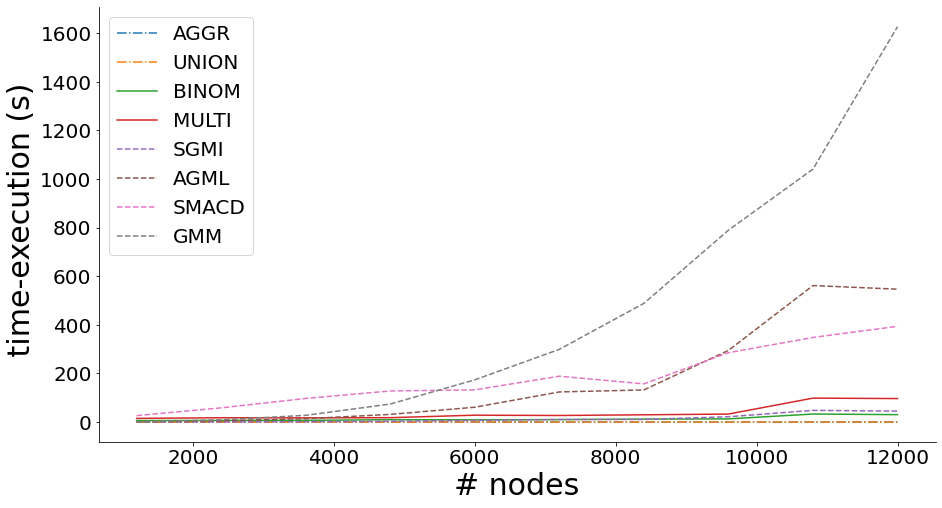

In [49]:
fig, ax = plt.subplots(figsize=(15, 8))
#ax.plot(exec_times_df, label=exec_times_df.columns)
ax.plot(exec_times_df[['AGGR','UNION']], label=['AGGR','UNION'],linestyle='dashdot')
ax.plot(exec_times_df[['BINOM','MULTI']], label=['BINOM','MULTI'],linestyle='solid')
ax.plot(exec_times_df[['SGMI','AGML','SMACD','GMM']], label=['SGMI','AGML','SMACD','GMM'],linestyle='dashed')

#cycler = plt.cycler(linestyle=['dashdot', 'dashdot', 'solid', 'solid','dashed','dashed','dashed','dashed'])
#ax.set_title('Complexity analysis')
ax.tick_params(labelsize=20)
ax.set_xlabel('# nodes', fontsize=30)
ax.set_ylabel(' time-execution (s)', fontsize=30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(prop={'size': 20}) #ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

## Tables

#### synthetic_datasets

In [48]:
def tables_synthetic(N,C,K,case,cluster_std_list,knn,perc):
    matrix_acc_mean_final = pd.DataFrame()

    for cluster_std in cluster_std_list:

        matrix_acc_mean = results_statistics_synthetic(N,C,K,case,cluster_std,knn,perc)
        matrix_acc_mean = matrix_acc_mean.sort_index().reset_index(drop=True)

        matrix_acc_mean = matrix_acc_mean.iloc[list(range(K))+[K+3,K+4,K,K+1,K+2,K+5,K+6]].reset_index()
        matrix_acc_mean[0] = matrix_acc_mean["acc_mean"].round(2).astype(str) + u"\u00B1" + matrix_acc_mean["acc_std"].round(2).astype(str)
        matrix_acc_mean = matrix_acc_mean[[0]].transpose()
        matrix_acc_mean = matrix_acc_mean.replace('0.0±0.0', '-')
        matrix_acc_mean_final = pd.concat([matrix_acc_mean_final, matrix_acc_mean], axis=0)
        matrix_acc_mean_final.reset_index(inplace=True, drop=True)

    #state of the art
    df = pd.read_csv('Results/Matlab_acc_N'+str(N)+'_C'+str(C)+'_case '+case+'_std_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'_sample'+str(5)+'.csv',header=None)
    df['GMM'] = df[0].round(2).astype(str) + u"\u00B1" + df[1].round(2).astype(str)
    df['SGMI'] = df[2].round(2).astype(str) + u"\u00B1" + df[3].round(2).astype(str)
    df['AGML'] = df[4].round(2).astype(str) + u"\u00B1" + df[5].round(2).astype(str)
    df['SMACD'] = df[6].round(2).astype(str) + u"\u00B1" + df[7].round(2).astype(str)
    df = df[['SGMI','AGML','SMACD','GMM']]

    matrix_acc_mean_final = pd.concat([matrix_acc_mean_final, df], ignore_index = True, axis=1)   
    matrix_acc_mean_final = matrix_acc_mean_final.set_axis(['1','2','3','MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','AGML','SMACD','GMM'], axis=1, inplace=False)
    matrix_acc_mean_final.to_csv('Results/Table_'+case+'.csv',header=None)
    return matrix_acc_mean_final

In [49]:
N = 1200 #number of nodes
C = 3 #number of communities
K = 3 #number layers
perc = 20 #percentage known labels per community

case = 'info2' 
cluster_std_list = [5,6,7,8]
info_table = tables_synthetic(N,C,K,case,cluster_std_list,knn,perc)   

case = 'noisy' 
cluster_std_list = [2,3,4,5]
noisy_table = tables_synthetic(N,C,K,case,cluster_std_list,knn,perc) 

case = 'compl' 
cluster_std_list = [2,3,4,5]
compl_table = tables_synthetic(N,C,K,case,cluster_std_list,knn,perc)

synthetic_table = pd.concat([pd.concat([info_table, noisy_table]),compl_table])
synthetic_table.to_csv('Results/Table_synthetic.csv',header=None)
synthetic_table

,1,2,3,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,AGML,SMACD,GMM
0,0.83±0.1,0.86±0.05,0.84±0.1,0.33±0.0,0.33±0.0,0.95±0.03,0.96±0.03,0.96±0.03,0.96±0.03,0.93±0.04,0.87±0.04,0.93±0.05,0.48±0.18,0.93±0.04
1,0.77±0.11,0.8±0.05,0.79±0.11,0.33±0.0,0.33±0.0,0.9±0.05,0.92±0.04,0.92±0.05,0.92±0.05,0.89±0.06,0.8±0.06,0.86±0.09,0.47±0.16,0.89±0.05
2,0.71±0.1,0.74±0.05,0.74±0.11,0.33±0.0,0.33±0.0,0.86±0.07,0.88±0.07,0.87±0.07,0.85±0.07,0.8±0.09,0.74±0.07,0.8±0.1,0.46±0.14,0.85±0.07
3,0.66±0.1,0.69±0.04,0.7±0.11,0.33±0.0,0.33±0.0,0.81±0.08,0.83±0.08,0.82±0.09,0.81±0.07,0.75±0.06,0.69±0.07,0.74±0.1,0.44±0.14,0.8±0.08
0,0.99±0.02,0.35±0.01,0.36±0.01,0.33±0.0,0.33±0.0,0.67±0.02,0.68±0.03,0.68±0.03,0.99±0.01,0.99±0.02,0.98±0.03,0.63±0.03,0.35±0.03,0.86±0.04
1,0.95±0.05,0.35±0.0,0.36±0.01,0.33±0.0,0.33±0.0,0.66±0.04,0.66±0.04,0.66±0.04,0.96±0.04,0.95±0.05,0.94±0.07,0.6±0.06,0.36±0.04,0.82±0.07
2,0.89±0.08,0.36±0.0,0.35±0.01,0.33±0.0,0.33±0.0,0.63±0.05,0.63±0.05,0.63±0.05,0.9±0.07,0.9±0.07,0.88±0.1,0.57±0.07,0.36±0.03,0.77±0.1
3,0.83±0.1,0.35±0.01,0.36±0.01,0.33±0.0,0.33±0.0,0.58±0.06,0.59±0.06,0.58±0.06,0.85±0.09,0.84±0.1,0.8±0.12,0.53±0.07,0.35±0.04,0.7±0.11
0,0.41±0.0,0.47±0.0,0.48±0.01,0.33±0.0,0.33±0.0,0.89±0.02,0.94±0.02,0.92±0.02,0.86±0.03,0.89±0.02,0.43±0.04,0.3±0.01,0.52±0.05,0.69±0.03
1,0.41±0.01,0.47±0.01,0.47±0.01,0.33±0.0,0.33±0.0,0.86±0.04,0.9±0.05,0.89±0.05,0.87±0.04,0.86±0.04,0.44±0.04,0.3±0.02,0.44±0.08,0.67±0.04


#### real_datasets

In [96]:
def tables_real(datasets_list,knn,perc):
    K_max = max(dict_dataset_K.values())
    matrix_acc_mean_final = pd.DataFrame()

    for dataset in datasets_list:
        matrix_acc_mean_ = pd.DataFrame()
        matrix_acc_mean = results_statistics_real(dataset,knn,perc)

        K = dict_dataset_K[dataset]
        K_nan = K_max - K
        if K_nan!=0:
            for u in range(K_nan):
                matrix_acc_mean.loc[K-1+0.1*(u+1)] = 'layer'+str(K+u+1),0,0

        matrix_acc_mean = matrix_acc_mean.sort_index().reset_index(drop=True)

        matrix_acc_mean = matrix_acc_mean.iloc[list(range(K_max))+[K_max+3,K_max+4,K_max,K_max+1,K_max+2,K_max+5,K_max+6]].reset_index()
        #matrix_acc_mean[0] = matrix_acc_mean["acc_mean"].round(2).astype(str) + u"\u00B1" + matrix_acc_mean["acc_std"].round(2).astype(str)
        matrix_acc_mean[0] = matrix_acc_mean["acc_mean"].round(2).astype(str) + '$\pm$' + matrix_acc_mean["acc_std"].round(2).astype(str)
        matrix_acc_mean = matrix_acc_mean[[0]].transpose()
        matrix_acc_mean_ = matrix_acc_mean.replace('0.0$\pm$0.0', '-')
        
        #state of the art
        df = pd.read_csv('Results_Real/Matlab_acc_'+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'.csv',header=None)
        df = df.loc[[0]]
        df['SGMI'] = df[0].round(2).astype(str) + '$\pm$' + df[1].round(2).astype(str)
        df['SMACD'] = df[2].round(2).astype(str) + '$\pm$' + df[3].round(2).astype(str)
        df['GMM'] = df[4].round(2).astype(str) + '$\pm$' + df[5].round(2).astype(str)
        df = df[['SGMI','SMACD','GMM']].reset_index(drop=True)

        matrix_acc_mean_ = pd.concat([matrix_acc_mean_, df], ignore_index = True, axis=1)  
        matrix_acc_mean_.insert(0, 'dataset', dataset)
    
        matrix_acc_mean_final = pd.concat([matrix_acc_mean_final, matrix_acc_mean_], ignore_index = True, axis = 0)
        
    matrix_acc_mean_final = matrix_acc_mean_final.set_axis(['dataset']+list(range(K_max))+['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','SMACD','GMM'], axis=1, inplace=False)
    matrix_acc_mean_final.to_csv('Results_Real/Table_real_info_perc'+str(perc)+'.csv',index=None,header=None,sep='&')  
        
    return matrix_acc_mean_final

In [97]:
def tables_real_noisy(datasets_list,knn,perc,rand_layers):
    K_max = max(dict_dataset_K.values())+rand_layers
    matrix_acc_mean_final = pd.DataFrame()

    for dataset in datasets_list:
        matrix_acc_mean_ = pd.DataFrame()
        matrix_acc_mean = results_statistics_real_noisy(dataset,knn,perc,rand_layers)

        K = dict_dataset_K[dataset]+rand_layers
        K_nan = K_max - K
        if K_nan!=0:
            for u in range(K_nan):
                matrix_acc_mean.loc[K-1+0.1*(u+1)] = 'layer'+str(K+u+1),0,0

        matrix_acc_mean = matrix_acc_mean.sort_index().reset_index(drop=True)

        matrix_acc_mean = matrix_acc_mean.iloc[list(range(K_max-rand_layers))+[K_max+3,K_max+4,K_max,K_max+1,K_max+2,K_max+5,K_max+6]].reset_index()
        matrix_acc_mean[0] = matrix_acc_mean["acc_mean"].round(2).astype(str) + '$\pm$' + matrix_acc_mean["acc_std"].round(2).astype(str)
        matrix_acc_mean = matrix_acc_mean[[0]].transpose()
        matrix_acc_mean_ = matrix_acc_mean.replace('0.0$\pm$0.0', '-')
        
        #state of the art
        df = pd.read_csv('Results_Real/Matlab_acc_'+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'.csv',header=None)
        df = df.loc[[rand_layers]]
        df['SGMI'] = df[0].round(2).astype(str) + '$\pm$' + df[1].round(2).astype(str)
        df['SMACD'] = df[2].round(2).astype(str) + '$\pm$' + df[3].round(2).astype(str)
        df['GMM'] = df[4].round(2).astype(str) + '$\pm$' + df[5].round(2).astype(str)
        df = df[['SGMI','SMACD','GMM']].reset_index(drop=True)

        matrix_acc_mean_ = pd.concat([matrix_acc_mean_, df], ignore_index = True, axis=1)  
        matrix_acc_mean_.insert(0, 'dataset', dataset)
    
        matrix_acc_mean_final = pd.concat([matrix_acc_mean_final, matrix_acc_mean_], ignore_index = True, axis = 0)
        
    matrix_acc_mean_final = matrix_acc_mean_final.set_axis(['dataset']+list(range(K_max-rand_layers))+['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','SMACD','GMM'], axis=1, inplace=False)
    matrix_acc_mean_final.to_csv('Results_Real/Table_real_Knoisy'+str(rand_layers)+'_perc'+str(perc)+'.csv',index=None,header=None,sep='&')   
        
    return matrix_acc_mean_final

In [98]:
knn = 5
for perc in [15,10,5,1]: 
    matrix_acc_mean_final = tables_real(datasets_list,knn,perc)
    display(matrix_acc_mean_final)

,dataset,0,1,2,3,4,5,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,3sources,0.77$\pm$0.04,0.75$\pm$0.03,0.78$\pm$0.05,-,-,-,0.74$\pm$0.06,0.74$\pm$0.06,0.83$\pm$0.05,0.75$\pm$0.04,0.8$\pm$0.03,0.82$\pm$0.03,0.76$\pm$0.04,0.74$\pm$0.04,0.66$\pm$0.09,0.8$\pm$0.03
1,BBC4view_685,0.85$\pm$0.01,0.84$\pm$0.01,0.8$\pm$0.01,0.84$\pm$0.01,-,-,0.39$\pm$0.02,0.39$\pm$0.02,0.91$\pm$0.01,0.89$\pm$0.01,0.9$\pm$0.01,0.89$\pm$0.01,0.85$\pm$0.03,0.77$\pm$0.02,0.64$\pm$0.12,0.89$\pm$0.01
2,BBCSport2view_544,0.9$\pm$0.01,0.9$\pm$0.01,-,-,-,-,0.81$\pm$0.01,0.81$\pm$0.01,0.94$\pm$0.01,0.93$\pm$0.0,0.93$\pm$0.0,0.94$\pm$0.01,0.91$\pm$0.02,0.84$\pm$0.02,0.77$\pm$0.09,0.91$\pm$0.02
3,WikipediaArticles,0.17$\pm$0.01,0.65$\pm$0.02,-,-,-,-,0.21$\pm$0.01,0.21$\pm$0.01,0.56$\pm$0.02,0.56$\pm$0.02,0.56$\pm$0.02,0.64$\pm$0.01,0.64$\pm$0.02,0.62$\pm$0.02,0.31$\pm$0.05,0.62$\pm$0.01
4,UCI_mfeat,0.93$\pm$0.01,0.82$\pm$0.0,0.96$\pm$0.01,0.59$\pm$0.02,0.97$\pm$0.0,0.83$\pm$0.01,0.11$\pm$0.0,0.11$\pm$0.0,0.96$\pm$0.01,0.89$\pm$0.01,0.93$\pm$0.0,0.97$\pm$0.0,0.97$\pm$0.01,0.95$\pm$0.01,0.35$\pm$0.11,0.96$\pm$0.01
5,cora,0.75$\pm$0.01,0.64$\pm$0.0,-,-,-,-,0.35$\pm$0.01,0.35$\pm$0.01,0.71$\pm$0.0,0.7$\pm$0.0,0.71$\pm$0.0,0.77$\pm$0.04,0.77$\pm$0.02,0.75$\pm$0.01,0.41$\pm$0.03,0.73$\pm$0.01
6,citeseer,0.56$\pm$0.02,0.65$\pm$0.01,-,-,-,-,0.31$\pm$0.01,0.31$\pm$0.01,0.67$\pm$0.0,0.67$\pm$0.01,0.67$\pm$0.01,0.68$\pm$0.01,0.68$\pm$0.01,0.55$\pm$0.02,0.39$\pm$0.08,0.61$\pm$0.01
7,dkpol,0.35$\pm$0.03,0.16$\pm$0.01,0.71$\pm$0.05,-,-,-,0.16$\pm$0.01,0.16$\pm$0.01,0.75$\pm$0.05,0.68$\pm$0.06,0.7$\pm$0.05,0.67$\pm$0.05,0.8$\pm$0.04,0.34$\pm$0.04,0.25$\pm$0.06,0.69$\pm$0.05
8,aucs,0.34$\pm$0.02,0.36$\pm$0.04,0.61$\pm$0.08,0.8$\pm$0.08,0.72$\pm$0.03,-,0.3$\pm$0.01,0.3$\pm$0.01,0.85$\pm$0.04,0.8$\pm$0.06,0.85$\pm$0.05,0.84$\pm$0.04,0.85$\pm$0.04,0.75$\pm$0.07,0.55$\pm$0.04,0.81$\pm$0.05


,dataset,0,1,2,3,4,5,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,3sources,0.76$\pm$0.04,0.72$\pm$0.05,0.75$\pm$0.05,-,-,-,0.71$\pm$0.07,0.71$\pm$0.07,0.79$\pm$0.07,0.69$\pm$0.05,0.75$\pm$0.05,0.75$\pm$0.07,0.74$\pm$0.05,0.75$\pm$0.04,0.62$\pm$0.04,0.8$\pm$0.05
1,BBC4view_685,0.83$\pm$0.01,0.83$\pm$0.01,0.79$\pm$0.01,0.83$\pm$0.01,-,-,0.38$\pm$0.01,0.38$\pm$0.01,0.91$\pm$0.01,0.89$\pm$0.01,0.9$\pm$0.01,0.88$\pm$0.01,0.86$\pm$0.04,0.76$\pm$0.02,0.69$\pm$0.03,0.87$\pm$0.01
2,BBCSport2view_544,0.9$\pm$0.0,0.88$\pm$0.01,-,-,-,-,0.79$\pm$0.0,0.79$\pm$0.0,0.92$\pm$0.01,0.92$\pm$0.0,0.92$\pm$0.0,0.92$\pm$0.02,0.88$\pm$0.01,0.84$\pm$0.03,0.73$\pm$0.1,0.88$\pm$0.02
3,WikipediaArticles,0.18$\pm$0.0,0.65$\pm$0.01,-,-,-,-,0.19$\pm$0.01,0.19$\pm$0.01,0.51$\pm$0.03,0.51$\pm$0.03,0.51$\pm$0.03,0.62$\pm$0.04,0.64$\pm$0.02,0.61$\pm$0.03,0.24$\pm$0.04,0.57$\pm$0.03
4,UCI_mfeat,0.92$\pm$0.01,0.81$\pm$0.01,0.96$\pm$0.0,0.57$\pm$0.01,0.97$\pm$0.0,0.82$\pm$0.01,0.11$\pm$0.0,0.11$\pm$0.0,0.95$\pm$0.01,0.88$\pm$0.01,0.92$\pm$0.01,0.97$\pm$0.01,0.96$\pm$0.01,0.94$\pm$0.01,0.33$\pm$0.05,0.93$\pm$0.01
5,cora,0.73$\pm$0.01,0.62$\pm$0.01,-,-,-,-,0.34$\pm$0.01,0.34$\pm$0.01,0.69$\pm$0.01,0.69$\pm$0.01,0.69$\pm$0.01,0.74$\pm$0.03,0.76$\pm$0.01,0.72$\pm$0.01,0.34$\pm$0.08,0.69$\pm$0.01
6,citeseer,0.51$\pm$0.01,0.62$\pm$0.01,-,-,-,-,0.29$\pm$0.01,0.29$\pm$0.01,0.65$\pm$0.01,0.65$\pm$0.01,0.65$\pm$0.01,0.66$\pm$0.01,0.65$\pm$0.01,0.51$\pm$0.01,0.36$\pm$0.1,0.58$\pm$0.01
7,dkpol,0.32$\pm$0.03,0.16$\pm$0.01,0.69$\pm$0.07,-,-,-,0.16$\pm$0.0,0.16$\pm$0.0,0.73$\pm$0.06,0.67$\pm$0.09,0.69$\pm$0.07,0.62$\pm$0.06,0.76$\pm$0.01,0.31$\pm$0.03,0.26$\pm$0.09,0.63$\pm$0.04
8,aucs,0.34$\pm$0.02,0.36$\pm$0.04,0.61$\pm$0.08,0.8$\pm$0.08,0.72$\pm$0.03,-,0.3$\pm$0.01,0.3$\pm$0.01,0.85$\pm$0.04,0.8$\pm$0.06,0.85$\pm$0.05,0.85$\pm$0.04,0.85$\pm$0.02,0.75$\pm$0.07,0.58$\pm$0.03,0.81$\pm$0.05


,dataset,0,1,2,3,4,5,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,3sources,0.73$\pm$0.05,0.72$\pm$0.04,0.77$\pm$0.04,-,-,-,0.68$\pm$0.02,0.68$\pm$0.02,0.8$\pm$0.06,0.72$\pm$0.03,0.78$\pm$0.04,0.76$\pm$0.07,0.72$\pm$0.07,0.72$\pm$0.03,0.58$\pm$0.05,0.77$\pm$0.05
1,BBC4view_685,0.81$\pm$0.02,0.8$\pm$0.02,0.77$\pm$0.01,0.81$\pm$0.02,-,-,0.37$\pm$0.02,0.37$\pm$0.02,0.88$\pm$0.02,0.85$\pm$0.01,0.87$\pm$0.02,0.84$\pm$0.02,0.83$\pm$0.03,0.73$\pm$0.01,0.59$\pm$0.07,0.81$\pm$0.03
2,BBCSport2view_544,0.89$\pm$0.01,0.86$\pm$0.01,-,-,-,-,0.78$\pm$0.01,0.78$\pm$0.01,0.91$\pm$0.01,0.9$\pm$0.01,0.91$\pm$0.01,0.91$\pm$0.02,0.88$\pm$0.01,0.81$\pm$0.04,0.79$\pm$0.09,0.84$\pm$0.02
3,WikipediaArticles,0.17$\pm$0.02,0.6$\pm$0.03,-,-,-,-,0.18$\pm$0.01,0.18$\pm$0.01,0.44$\pm$0.03,0.44$\pm$0.04,0.44$\pm$0.04,0.57$\pm$0.02,0.57$\pm$0.08,0.59$\pm$0.02,0.31$\pm$0.06,0.48$\pm$0.04
4,UCI_mfeat,0.9$\pm$0.01,0.8$\pm$0.01,0.95$\pm$0.01,0.51$\pm$0.02,0.96$\pm$0.0,0.8$\pm$0.01,0.1$\pm$0.0,0.1$\pm$0.0,0.92$\pm$0.01,0.86$\pm$0.01,0.89$\pm$0.01,0.95$\pm$0.03,0.94$\pm$0.01,0.87$\pm$0.07,0.29$\pm$0.09,0.85$\pm$0.01
5,cora,0.69$\pm$0.01,0.59$\pm$0.01,-,-,-,-,0.32$\pm$0.01,0.32$\pm$0.01,0.66$\pm$0.01,0.66$\pm$0.01,0.66$\pm$0.01,0.7$\pm$0.03,0.7$\pm$0.05,0.67$\pm$0.02,0.37$\pm$0.06,0.61$\pm$0.01
6,citeseer,0.46$\pm$0.02,0.59$\pm$0.01,-,-,-,-,0.27$\pm$0.0,0.27$\pm$0.0,0.62$\pm$0.01,0.62$\pm$0.01,0.62$\pm$0.01,0.63$\pm$0.01,0.63$\pm$0.01,0.45$\pm$0.02,0.26$\pm$0.05,0.51$\pm$0.01
7,dkpol,0.3$\pm$0.03,0.16$\pm$0.0,0.69$\pm$0.03,-,-,-,0.15$\pm$0.0,0.15$\pm$0.0,0.7$\pm$0.04,0.69$\pm$0.03,0.7$\pm$0.03,0.65$\pm$0.05,0.59$\pm$0.09,0.27$\pm$0.03,0.24$\pm$0.08,0.59$\pm$0.04
8,aucs,0.34$\pm$0.02,0.36$\pm$0.04,0.61$\pm$0.08,0.8$\pm$0.08,0.72$\pm$0.03,-,0.3$\pm$0.01,0.3$\pm$0.01,0.85$\pm$0.04,0.8$\pm$0.06,0.85$\pm$0.05,0.86$\pm$0.05,0.86$\pm$0.05,0.75$\pm$0.07,0.5$\pm$0.16,0.81$\pm$0.05


,dataset,0,1,2,3,4,5,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,3sources,0.72$\pm$0.05,0.69$\pm$0.07,0.77$\pm$0.03,-,-,-,0.66$\pm$0.01,0.66$\pm$0.01,0.79$\pm$0.04,0.71$\pm$0.04,0.76$\pm$0.04,0.79$\pm$0.04,0.79$\pm$0.04,0.65$\pm$0.04,0.58$\pm$0.06,0.69$\pm$0.06
1,BBC4view_685,0.77$\pm$0.02,0.76$\pm$0.03,0.72$\pm$0.02,0.75$\pm$0.03,-,-,0.35$\pm$0.01,0.35$\pm$0.01,0.83$\pm$0.01,0.81$\pm$0.01,0.82$\pm$0.01,0.83$\pm$0.01,0.83$\pm$0.01,0.64$\pm$0.03,0.59$\pm$0.07,0.68$\pm$0.03
2,BBCSport2view_544,0.87$\pm$0.04,0.76$\pm$0.06,-,-,-,-,0.63$\pm$0.07,0.63$\pm$0.07,0.87$\pm$0.03,0.87$\pm$0.03,0.87$\pm$0.03,0.87$\pm$0.03,0.87$\pm$0.03,0.73$\pm$0.09,0.79$\pm$0.09,0.7$\pm$0.06
3,WikipediaArticles,0.17$\pm$0.01,0.61$\pm$0.02,-,-,-,-,0.17$\pm$0.01,0.17$\pm$0.01,0.42$\pm$0.03,0.42$\pm$0.04,0.42$\pm$0.03,0.42$\pm$0.03,0.42$\pm$0.03,0.58$\pm$0.03,0.31$\pm$0.05,0.43$\pm$0.05
4,UCI_mfeat,0.79$\pm$0.05,0.72$\pm$0.03,0.9$\pm$0.01,0.43$\pm$0.02,0.91$\pm$0.01,0.69$\pm$0.02,0.1$\pm$0.0,0.1$\pm$0.0,0.85$\pm$0.01,0.79$\pm$0.02,0.82$\pm$0.02,0.85$\pm$0.01,0.81$\pm$0.02,0.56$\pm$0.14,0.35$\pm$0.11,0.58$\pm$0.02
5,cora,0.58$\pm$0.05,0.49$\pm$0.05,-,-,-,-,0.3$\pm$0.01,0.3$\pm$0.01,0.56$\pm$0.04,0.56$\pm$0.04,0.56$\pm$0.04,0.57$\pm$0.03,0.56$\pm$0.03,0.55$\pm$0.05,0.37$\pm$0.07,0.45$\pm$0.03
6,citeseer,0.41$\pm$0.02,0.5$\pm$0.04,-,-,-,-,0.23$\pm$0.01,0.23$\pm$0.01,0.53$\pm$0.04,0.54$\pm$0.03,0.54$\pm$0.04,0.55$\pm$0.03,0.54$\pm$0.03,0.4$\pm$0.01,0.3$\pm$0.08,0.38$\pm$0.03
7,dkpol,0.29$\pm$0.02,0.16$\pm$0.0,0.67$\pm$0.03,-,-,-,0.15$\pm$0.0,0.15$\pm$0.0,0.67$\pm$0.03,0.66$\pm$0.03,0.67$\pm$0.03,0.67$\pm$0.03,0.67$\pm$0.03,0.19$\pm$0.04,0.24$\pm$0.06,0.57$\pm$0.02
8,aucs,0.34$\pm$0.02,0.36$\pm$0.04,0.61$\pm$0.08,0.8$\pm$0.08,0.72$\pm$0.03,-,0.3$\pm$0.01,0.3$\pm$0.01,0.85$\pm$0.04,0.8$\pm$0.06,0.85$\pm$0.05,0.84$\pm$0.04,0.85$\pm$0.03,0.75$\pm$0.07,0.5$\pm$0.16,0.81$\pm$0.05


In [99]:
knn = 5
rand_layers = 1
for perc in [15,10,5,1]: 
    matrix_acc_mean_final = tables_real_noisy(datasets_list,knn,perc,rand_layers)
    display(matrix_acc_mean_final)

,dataset,0,1,2,3,4,5,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,3sources,0.75$\pm$0.04,0.74$\pm$0.02,0.76$\pm$0.04,0.26$\pm$0.02,-,-,0.34$\pm$0.01,0.34$\pm$0.01,0.79$\pm$0.05,0.57$\pm$0.04,0.71$\pm$0.03,0.79$\pm$0.06,0.72$\pm$0.07,0.75$\pm$0.05,0.61$\pm$0.09,0.77$\pm$0.02
1,BBC4view_685,0.85$\pm$0.01,0.84$\pm$0.01,0.81$\pm$0.01,0.84$\pm$0.01,0.23$\pm$0.01,-,0.33$\pm$0.0,0.33$\pm$0.0,0.9$\pm$0.01,0.86$\pm$0.0,0.88$\pm$0.01,0.89$\pm$0.01,0.86$\pm$0.03,0.79$\pm$0.01,0.62$\pm$0.05,0.87$\pm$0.01
2,BBCSport2view_544,0.9$\pm$0.0,0.9$\pm$0.01,0.25$\pm$0.02,-,-,-,0.36$\pm$0.0,0.36$\pm$0.0,0.9$\pm$0.01,0.87$\pm$0.01,0.89$\pm$0.0,0.91$\pm$0.02,0.87$\pm$0.02,0.84$\pm$0.03,0.85$\pm$0.02,0.86$\pm$0.02
3,WikipediaArticles,0.18$\pm$0.01,0.66$\pm$0.02,0.15$\pm$0.01,-,-,-,0.15$\pm$0.0,0.15$\pm$0.0,0.51$\pm$0.01,0.51$\pm$0.01,0.52$\pm$0.01,0.61$\pm$0.02,0.63$\pm$0.03,0.61$\pm$0.01,0.32$\pm$0.06,0.55$\pm$0.01
4,UCI_mfeat,0.93$\pm$0.0,0.82$\pm$0.0,0.97$\pm$0.01,0.58$\pm$0.02,0.97$\pm$0.0,0.83$\pm$0.0,0.1$\pm$0.0,0.1$\pm$0.0,0.97$\pm$0.0,0.9$\pm$0.0,0.94$\pm$0.0,0.97$\pm$0.0,0.97$\pm$0.01,0.95$\pm$0.01,0.26$\pm$0.06,0.96$\pm$0.01
5,cora,0.75$\pm$0.01,0.64$\pm$0.0,0.17$\pm$0.01,-,-,-,0.3$\pm$0.0,0.3$\pm$0.0,0.61$\pm$0.0,0.59$\pm$0.0,0.6$\pm$0.0,0.65$\pm$0.02,0.66$\pm$0.07,0.75$\pm$0.01,0.35$\pm$0.07,0.65$\pm$0.0
6,citeseer,0.56$\pm$0.02,0.65$\pm$0.0,0.19$\pm$0.0,-,-,-,0.21$\pm$0.0,0.21$\pm$0.0,0.57$\pm$0.0,0.56$\pm$0.0,0.57$\pm$0.01,0.62$\pm$0.03,0.66$\pm$0.03,0.55$\pm$0.03,0.35$\pm$0.07,0.54$\pm$0.01
7,dkpol,0.36$\pm$0.03,0.17$\pm$0.01,0.68$\pm$0.04,0.17$\pm$0.0,-,-,0.14$\pm$0.0,0.14$\pm$0.0,0.65$\pm$0.04,0.61$\pm$0.02,0.63$\pm$0.03,0.5$\pm$0.06,0.71$\pm$0.09,0.36$\pm$0.05,0.26$\pm$0.05,0.39$\pm$0.04
8,aucs,0.35$\pm$0.03,0.37$\pm$0.02,0.66$\pm$0.07,0.85$\pm$0.01,0.71$\pm$0.03,0.29$\pm$0.04,0.28$\pm$0.01,0.28$\pm$0.01,0.82$\pm$0.05,0.44$\pm$0.02,0.73$\pm$0.04,0.82$\pm$0.05,0.82$\pm$0.05,0.76$\pm$0.09,0.48$\pm$0.06,0.78$\pm$0.05


,dataset,0,1,2,3,4,5,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,3sources,0.75$\pm$0.05,0.7$\pm$0.03,0.74$\pm$0.05,0.26$\pm$0.01,-,-,0.34$\pm$0.01,0.34$\pm$0.01,0.74$\pm$0.1,0.54$\pm$0.06,0.66$\pm$0.09,0.76$\pm$0.11,0.73$\pm$0.06,0.58$\pm$0.27,0.6$\pm$0.08,0.76$\pm$0.04
1,BBC4view_685,0.83$\pm$0.01,0.82$\pm$0.01,0.79$\pm$0.01,0.83$\pm$0.01,0.24$\pm$0.0,-,0.33$\pm$0.0,0.33$\pm$0.0,0.89$\pm$0.01,0.84$\pm$0.01,0.87$\pm$0.02,0.87$\pm$0.02,0.87$\pm$0.01,0.76$\pm$0.03,0.66$\pm$0.02,0.84$\pm$0.01
2,BBCSport2view_544,0.9$\pm$0.0,0.88$\pm$0.01,0.24$\pm$0.01,-,-,-,0.36$\pm$0.0,0.36$\pm$0.0,0.86$\pm$0.02,0.82$\pm$0.01,0.85$\pm$0.02,0.91$\pm$0.01,0.87$\pm$0.0,0.83$\pm$0.04,0.6$\pm$0.07,0.77$\pm$0.02
3,WikipediaArticles,0.18$\pm$0.01,0.64$\pm$0.01,0.15$\pm$0.0,-,-,-,0.15$\pm$0.0,0.15$\pm$0.0,0.42$\pm$0.01,0.42$\pm$0.01,0.42$\pm$0.01,0.57$\pm$0.06,0.62$\pm$0.03,0.59$\pm$0.02,0.25$\pm$0.04,0.47$\pm$0.02
4,UCI_mfeat,0.92$\pm$0.0,0.81$\pm$0.01,0.96$\pm$0.0,0.57$\pm$0.02,0.97$\pm$0.0,0.82$\pm$0.0,0.1$\pm$0.0,0.1$\pm$0.0,0.96$\pm$0.0,0.88$\pm$0.01,0.92$\pm$0.0,0.97$\pm$0.0,0.96$\pm$0.01,0.94$\pm$0.01,0.3$\pm$0.1,0.93$\pm$0.01
5,cora,0.73$\pm$0.01,0.62$\pm$0.01,0.17$\pm$0.0,-,-,-,0.3$\pm$0.0,0.3$\pm$0.0,0.57$\pm$0.01,0.56$\pm$0.01,0.57$\pm$0.01,0.63$\pm$0.01,0.76$\pm$0.01,0.72$\pm$0.02,0.28$\pm$0.01,0.58$\pm$0.01
6,citeseer,0.51$\pm$0.01,0.63$\pm$0.01,0.19$\pm$0.0,-,-,-,0.21$\pm$0.0,0.21$\pm$0.0,0.53$\pm$0.02,0.52$\pm$0.02,0.53$\pm$0.02,0.59$\pm$0.03,0.63$\pm$0.0,0.52$\pm$0.02,0.32$\pm$0.03,0.49$\pm$0.01
7,dkpol,0.34$\pm$0.03,0.17$\pm$0.01,0.66$\pm$0.07,0.16$\pm$0.01,-,-,0.14$\pm$0.0,0.14$\pm$0.0,0.62$\pm$0.02,0.59$\pm$0.02,0.6$\pm$0.02,0.54$\pm$0.08,0.72$\pm$0.08,0.31$\pm$0.05,0.24$\pm$0.01,0.34$\pm$0.01
8,aucs,0.35$\pm$0.03,0.37$\pm$0.02,0.66$\pm$0.07,0.85$\pm$0.01,0.71$\pm$0.03,0.32$\pm$0.04,0.27$\pm$0.0,0.27$\pm$0.0,0.81$\pm$0.04,0.37$\pm$0.03,0.65$\pm$0.03,0.81$\pm$0.04,0.81$\pm$0.04,0.76$\pm$0.09,0.56$\pm$0.07,0.77$\pm$0.09


,dataset,0,1,2,3,4,5,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,3sources,0.71$\pm$0.06,0.71$\pm$0.03,0.76$\pm$0.04,0.25$\pm$0.01,-,-,0.35$\pm$0.01,0.35$\pm$0.01,0.74$\pm$0.06,0.55$\pm$0.04,0.68$\pm$0.06,0.69$\pm$0.09,0.61$\pm$0.08,0.56$\pm$0.25,0.64$\pm$0.1,0.71$\pm$0.05
1,BBC4view_685,0.8$\pm$0.03,0.81$\pm$0.02,0.77$\pm$0.01,0.81$\pm$0.01,0.24$\pm$0.01,-,0.33$\pm$0.0,0.33$\pm$0.0,0.85$\pm$0.02,0.78$\pm$0.02,0.82$\pm$0.02,0.82$\pm$0.01,0.8$\pm$0.03,0.57$\pm$0.28,0.58$\pm$0.06,0.74$\pm$0.02
2,BBCSport2view_544,0.89$\pm$0.01,0.86$\pm$0.02,0.24$\pm$0.02,-,-,-,0.36$\pm$0.0,0.36$\pm$0.0,0.82$\pm$0.03,0.79$\pm$0.03,0.8$\pm$0.02,0.87$\pm$0.01,0.87$\pm$0.01,0.41$\pm$0.28,0.75$\pm$0.11,0.68$\pm$0.04
3,WikipediaArticles,0.17$\pm$0.02,0.59$\pm$0.03,0.15$\pm$0.0,-,-,-,0.15$\pm$0.0,0.15$\pm$0.0,0.34$\pm$0.01,0.34$\pm$0.01,0.34$\pm$0.01,0.47$\pm$0.02,0.5$\pm$0.1,0.16$\pm$0.01,0.28$\pm$0.05,0.37$\pm$0.01
4,UCI_mfeat,0.89$\pm$0.01,0.79$\pm$0.01,0.95$\pm$0.01,0.52$\pm$0.01,0.96$\pm$0.01,0.8$\pm$0.01,0.1$\pm$0.0,0.1$\pm$0.0,0.93$\pm$0.01,0.85$\pm$0.02,0.9$\pm$0.01,0.96$\pm$0.01,0.91$\pm$0.04,0.91$\pm$0.0,0.29$\pm$0.09,0.82$\pm$0.01
5,cora,0.68$\pm$0.0,0.59$\pm$0.01,0.17$\pm$0.0,-,-,-,0.3$\pm$0.0,0.3$\pm$0.0,0.53$\pm$0.01,0.52$\pm$0.01,0.53$\pm$0.01,0.59$\pm$0.02,0.64$\pm$0.02,0.67$\pm$0.02,0.31$\pm$0.04,0.5$\pm$0.01
6,citeseer,0.47$\pm$0.02,0.59$\pm$0.01,0.18$\pm$0.0,-,-,-,0.21$\pm$0.0,0.21$\pm$0.0,0.49$\pm$0.01,0.47$\pm$0.01,0.48$\pm$0.01,0.5$\pm$0.02,0.6$\pm$0.02,0.46$\pm$0.02,0.26$\pm$0.05,0.41$\pm$0.01
7,dkpol,0.31$\pm$0.0,0.16$\pm$0.01,0.68$\pm$0.02,0.16$\pm$0.01,-,-,0.14$\pm$0.0,0.14$\pm$0.0,0.58$\pm$0.04,0.57$\pm$0.04,0.58$\pm$0.03,0.63$\pm$0.08,0.6$\pm$0.02,0.3$\pm$0.01,0.24$\pm$0.03,0.34$\pm$0.03
8,aucs,0.35$\pm$0.03,0.37$\pm$0.02,0.66$\pm$0.07,0.85$\pm$0.01,0.71$\pm$0.03,0.32$\pm$0.04,0.27$\pm$0.0,0.27$\pm$0.0,0.81$\pm$0.04,0.37$\pm$0.03,0.65$\pm$0.03,0.81$\pm$0.04,0.81$\pm$0.04,0.76$\pm$0.09,0.48$\pm$0.08,0.77$\pm$0.09


,dataset,0,1,2,3,4,5,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,3sources,0.71$\pm$0.06,0.71$\pm$0.03,0.76$\pm$0.04,0.26$\pm$0.01,-,-,0.35$\pm$0.01,0.35$\pm$0.01,0.73$\pm$0.06,0.55$\pm$0.05,0.69$\pm$0.07,0.73$\pm$0.06,0.73$\pm$0.06,0.52$\pm$0.22,0.65$\pm$0.08,0.62$\pm$0.02
1,BBC4view_685,0.77$\pm$0.02,0.75$\pm$0.03,0.71$\pm$0.01,0.75$\pm$0.03,0.23$\pm$0.0,-,0.33$\pm$0.0,0.33$\pm$0.0,0.78$\pm$0.01,0.74$\pm$0.01,0.76$\pm$0.01,0.78$\pm$0.01,0.83$\pm$0.01,0.23$\pm$0.01,0.62$\pm$0.04,0.6$\pm$0.02
2,BBCSport2view_544,0.85$\pm$0.04,0.75$\pm$0.05,0.25$\pm$0.01,-,-,-,0.36$\pm$0.0,0.36$\pm$0.0,0.73$\pm$0.03,0.71$\pm$0.02,0.73$\pm$0.03,0.73$\pm$0.03,0.73$\pm$0.03,0.24$\pm$0.02,0.79$\pm$0.04,0.54$\pm$0.04
3,WikipediaArticles,0.17$\pm$0.02,0.59$\pm$0.01,0.15$\pm$0.01,-,-,-,0.15$\pm$0.0,0.15$\pm$0.0,0.34$\pm$0.01,0.34$\pm$0.01,0.34$\pm$0.01,0.34$\pm$0.01,0.33$\pm$0.02,0.15$\pm$0.0,0.26$\pm$0.07,0.33$\pm$0.03
4,UCI_mfeat,0.77$\pm$0.04,0.7$\pm$0.03,0.9$\pm$0.01,0.43$\pm$0.02,0.9$\pm$0.01,0.7$\pm$0.01,0.1$\pm$0.0,0.1$\pm$0.0,0.82$\pm$0.01,0.75$\pm$0.02,0.78$\pm$0.02,0.5$\pm$0.02,0.82$\pm$0.01,0.13$\pm$0.0,0.26$\pm$0.06,0.54$\pm$0.0
5,cora,0.61$\pm$0.02,0.5$\pm$0.06,0.17$\pm$0.0,-,-,-,0.3$\pm$0.0,0.3$\pm$0.0,0.43$\pm$0.02,0.42$\pm$0.02,0.43$\pm$0.02,0.49$\pm$0.02,0.53$\pm$0.09,0.58$\pm$0.02,0.36$\pm$0.07,0.4$\pm$0.02
6,citeseer,0.4$\pm$0.01,0.48$\pm$0.03,0.19$\pm$0.01,-,-,-,0.21$\pm$0.0,0.21$\pm$0.0,0.36$\pm$0.02,0.36$\pm$0.02,0.36$\pm$0.02,0.39$\pm$0.06,0.49$\pm$0.03,0.39$\pm$0.01,0.37$\pm$0.06,0.32$\pm$0.01
7,dkpol,0.3$\pm$0.02,0.17$\pm$0.0,0.66$\pm$0.03,0.17$\pm$0.01,-,-,0.14$\pm$0.0,0.14$\pm$0.0,0.57$\pm$0.04,0.55$\pm$0.03,0.56$\pm$0.03,0.65$\pm$0.04,0.65$\pm$0.04,0.17$\pm$0.01,0.34$\pm$0.15,0.31$\pm$0.02
8,aucs,0.35$\pm$0.03,0.37$\pm$0.02,0.66$\pm$0.07,0.85$\pm$0.01,0.71$\pm$0.03,0.32$\pm$0.04,0.27$\pm$0.0,0.27$\pm$0.0,0.81$\pm$0.04,0.37$\pm$0.03,0.65$\pm$0.03,0.81$\pm$0.04,0.81$\pm$0.04,0.76$\pm$0.09,0.42$\pm$0.03,0.77$\pm$0.09


In [100]:
knn = 5
rand_layers = 2
for perc in [15,10,5,1]: 
    matrix_acc_mean_final = tables_real_noisy(datasets_list,knn,perc,rand_layers)
    display(matrix_acc_mean_final)

,dataset,0,1,2,3,4,5,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,3sources,0.75$\pm$0.04,0.74$\pm$0.02,0.76$\pm$0.04,0.24$\pm$0.03,0.26$\pm$0.02,-,0.34$\pm$0.0,0.34$\pm$0.0,0.76$\pm$0.09,0.47$\pm$0.04,0.63$\pm$0.04,0.75$\pm$0.08,0.72$\pm$0.02,0.75$\pm$0.05,0.63$\pm$0.15,0.76$\pm$0.07
1,BBC4view_685,0.85$\pm$0.01,0.84$\pm$0.01,0.81$\pm$0.01,0.84$\pm$0.01,0.22$\pm$0.01,0.22$\pm$0.0,0.33$\pm$0.0,0.33$\pm$0.0,0.88$\pm$0.01,0.83$\pm$0.01,0.86$\pm$0.0,0.88$\pm$0.01,0.85$\pm$0.03,0.79$\pm$0.01,0.64$\pm$0.01,0.84$\pm$0.01
2,BBCSport2view_544,0.9$\pm$0.0,0.9$\pm$0.01,0.23$\pm$0.01,0.24$\pm$0.0,-,-,0.35$\pm$0.0,0.35$\pm$0.0,0.87$\pm$0.01,0.81$\pm$0.01,0.84$\pm$0.01,0.94$\pm$0.01,0.88$\pm$0.01,0.84$\pm$0.03,0.85$\pm$0.07,0.8$\pm$0.03
3,WikipediaArticles,0.18$\pm$0.01,0.66$\pm$0.02,0.15$\pm$0.0,0.15$\pm$0.0,-,-,0.15$\pm$0.0,0.15$\pm$0.0,0.48$\pm$0.01,0.46$\pm$0.03,0.47$\pm$0.02,0.6$\pm$0.02,0.66$\pm$0.01,0.61$\pm$0.01,0.23$\pm$0.02,0.51$\pm$0.01
4,UCI_mfeat,0.93$\pm$0.0,0.82$\pm$0.0,0.97$\pm$0.01,0.58$\pm$0.02,0.97$\pm$0.0,0.83$\pm$0.0,0.1$\pm$0.0,0.1$\pm$0.0,0.97$\pm$0.0,0.89$\pm$0.01,0.94$\pm$0.0,0.96$\pm$0.01,0.97$\pm$0.01,0.95$\pm$0.01,0.29$\pm$0.01,0.96$\pm$0.01
5,cora,0.75$\pm$0.01,0.64$\pm$0.0,0.16$\pm$0.0,0.17$\pm$0.0,-,-,0.3$\pm$0.0,0.3$\pm$0.0,0.54$\pm$0.01,0.52$\pm$0.01,0.53$\pm$0.0,0.7$\pm$0.03,0.72$\pm$0.01,0.75$\pm$0.01,0.36$\pm$0.05,0.62$\pm$0.01
6,citeseer,0.56$\pm$0.02,0.65$\pm$0.0,0.18$\pm$0.0,0.18$\pm$0.01,-,-,0.21$\pm$0.0,0.21$\pm$0.0,0.51$\pm$0.01,0.48$\pm$0.01,0.5$\pm$0.01,0.66$\pm$0.04,0.64$\pm$0.01,0.55$\pm$0.03,0.36$\pm$0.13,0.52$\pm$0.01
7,dkpol,0.36$\pm$0.03,0.17$\pm$0.01,0.68$\pm$0.04,0.16$\pm$0.01,0.15$\pm$0.0,-,0.14$\pm$0.0,0.14$\pm$0.0,0.6$\pm$0.02,0.56$\pm$0.01,0.57$\pm$0.02,0.52$\pm$0.07,0.73$\pm$0.07,0.36$\pm$0.05,0.19$\pm$0.04,0.32$\pm$0.05
8,aucs,0.35$\pm$0.03,0.37$\pm$0.02,0.66$\pm$0.07,0.85$\pm$0.01,0.71$\pm$0.03,0.28$\pm$0.01,0.27$\pm$0.0,0.27$\pm$0.0,0.78$\pm$0.04,0.32$\pm$0.05,0.57$\pm$0.03,0.78$\pm$0.04,0.78$\pm$0.04,0.76$\pm$0.09,0.54$\pm$0.05,0.78$\pm$0.07


,dataset,0,1,2,3,4,5,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,3sources,0.75$\pm$0.05,0.7$\pm$0.03,0.74$\pm$0.05,0.26$\pm$0.01,0.26$\pm$0.01,-,0.33$\pm$0.0,0.33$\pm$0.0,0.7$\pm$0.08,0.46$\pm$0.06,0.6$\pm$0.08,0.72$\pm$0.15,0.75$\pm$0.07,0.57$\pm$0.28,0.61$\pm$0.21,0.71$\pm$0.05
1,BBC4view_685,0.83$\pm$0.01,0.82$\pm$0.01,0.79$\pm$0.01,0.83$\pm$0.01,0.24$\pm$0.0,0.24$\pm$0.01,0.33$\pm$0.0,0.33$\pm$0.0,0.88$\pm$0.01,0.79$\pm$0.01,0.84$\pm$0.02,0.87$\pm$0.01,0.83$\pm$0.03,0.76$\pm$0.03,0.65$\pm$0.07,0.81$\pm$0.01
2,BBCSport2view_544,0.9$\pm$0.0,0.88$\pm$0.01,0.24$\pm$0.01,0.24$\pm$0.01,-,-,0.35$\pm$0.0,0.35$\pm$0.0,0.8$\pm$0.02,0.74$\pm$0.02,0.77$\pm$0.02,0.9$\pm$0.01,0.87$\pm$0.01,0.64$\pm$0.31,0.78$\pm$0.03,0.73$\pm$0.03
3,WikipediaArticles,0.18$\pm$0.01,0.64$\pm$0.01,0.15$\pm$0.0,0.15$\pm$0.01,-,-,0.15$\pm$0.0,0.15$\pm$0.0,0.39$\pm$0.01,0.38$\pm$0.01,0.38$\pm$0.01,0.56$\pm$0.06,0.59$\pm$0.03,0.59$\pm$0.02,0.23$\pm$0.08,0.43$\pm$0.02
4,UCI_mfeat,0.92$\pm$0.0,0.81$\pm$0.01,0.96$\pm$0.0,0.57$\pm$0.02,0.97$\pm$0.0,0.82$\pm$0.0,0.1$\pm$0.0,0.1$\pm$0.0,0.96$\pm$0.0,0.88$\pm$0.01,0.92$\pm$0.0,0.97$\pm$0.0,0.96$\pm$0.01,0.94$\pm$0.01,0.33$\pm$0.05,0.93$\pm$0.01
5,cora,0.73$\pm$0.01,0.62$\pm$0.01,0.17$\pm$0.0,0.16$\pm$0.0,-,-,0.3$\pm$0.0,0.3$\pm$0.0,0.49$\pm$0.01,0.47$\pm$0.01,0.48$\pm$0.01,0.64$\pm$0.04,0.74$\pm$0.03,0.72$\pm$0.02,0.37$\pm$0.02,0.55$\pm$0.0
6,citeseer,0.51$\pm$0.01,0.63$\pm$0.01,0.19$\pm$0.0,0.18$\pm$0.0,-,-,0.21$\pm$0.0,0.21$\pm$0.0,0.47$\pm$0.02,0.44$\pm$0.01,0.46$\pm$0.01,0.61$\pm$0.03,0.63$\pm$0.0,0.52$\pm$0.02,0.26$\pm$0.05,0.45$\pm$0.01
7,dkpol,0.34$\pm$0.03,0.17$\pm$0.01,0.66$\pm$0.07,0.16$\pm$0.01,0.15$\pm$0.01,-,0.14$\pm$0.0,0.14$\pm$0.0,0.58$\pm$0.02,0.54$\pm$0.03,0.55$\pm$0.02,0.45$\pm$0.11,0.69$\pm$0.07,0.31$\pm$0.05,0.2$\pm$0.04,0.27$\pm$0.02
8,aucs,0.35$\pm$0.03,0.37$\pm$0.02,0.66$\pm$0.07,0.85$\pm$0.01,0.71$\pm$0.03,0.32$\pm$0.04,0.27$\pm$0.0,0.27$\pm$0.0,0.77$\pm$0.05,0.33$\pm$0.02,0.52$\pm$0.04,0.77$\pm$0.05,0.77$\pm$0.05,0.76$\pm$0.09,0.6$\pm$0.09,0.76$\pm$0.07


,dataset,0,1,2,3,4,5,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,3sources,0.71$\pm$0.06,0.71$\pm$0.03,0.76$\pm$0.04,0.25$\pm$0.01,0.26$\pm$0.02,-,0.34$\pm$0.0,0.34$\pm$0.0,0.72$\pm$0.04,0.47$\pm$0.02,0.62$\pm$0.05,0.79$\pm$0.05,0.72$\pm$0.07,0.55$\pm$0.27,0.7$\pm$0.1,0.65$\pm$0.05
1,BBC4view_685,0.8$\pm$0.03,0.81$\pm$0.02,0.77$\pm$0.01,0.81$\pm$0.01,0.24$\pm$0.01,0.25$\pm$0.01,0.33$\pm$0.0,0.33$\pm$0.0,0.81$\pm$0.02,0.71$\pm$0.02,0.76$\pm$0.02,0.78$\pm$0.08,0.79$\pm$0.01,0.42$\pm$0.26,0.64$\pm$0.04,0.7$\pm$0.02
2,BBCSport2view_544,0.89$\pm$0.01,0.86$\pm$0.02,0.24$\pm$0.02,0.23$\pm$0.01,-,-,0.35$\pm$0.0,0.35$\pm$0.0,0.73$\pm$0.04,0.67$\pm$0.03,0.7$\pm$0.03,0.85$\pm$0.03,0.87$\pm$0.01,0.41$\pm$0.28,0.72$\pm$0.08,0.62$\pm$0.03
3,WikipediaArticles,0.17$\pm$0.02,0.59$\pm$0.03,0.15$\pm$0.0,0.15$\pm$0.01,-,-,0.15$\pm$0.0,0.15$\pm$0.0,0.3$\pm$0.01,0.29$\pm$0.01,0.3$\pm$0.01,0.42$\pm$0.03,0.57$\pm$0.02,0.16$\pm$0.01,0.23$\pm$0.0,0.32$\pm$0.02
4,UCI_mfeat,0.89$\pm$0.01,0.79$\pm$0.01,0.95$\pm$0.01,0.52$\pm$0.01,0.96$\pm$0.01,0.8$\pm$0.01,0.1$\pm$0.0,0.1$\pm$0.0,0.93$\pm$0.01,0.82$\pm$0.02,0.89$\pm$0.01,0.96$\pm$0.01,0.94$\pm$0.01,0.91$\pm$0.0,0.26$\pm$0.06,0.81$\pm$0.02
5,cora,0.68$\pm$0.0,0.59$\pm$0.01,0.17$\pm$0.0,0.17$\pm$0.01,-,-,0.3$\pm$0.0,0.3$\pm$0.0,0.44$\pm$0.01,0.43$\pm$0.01,0.44$\pm$0.01,0.64$\pm$0.02,0.64$\pm$0.05,0.67$\pm$0.02,0.35$\pm$0.06,0.45$\pm$0.0
6,citeseer,0.47$\pm$0.02,0.59$\pm$0.01,0.18$\pm$0.0,0.18$\pm$0.0,-,-,0.21$\pm$0.0,0.21$\pm$0.0,0.41$\pm$0.01,0.39$\pm$0.01,0.4$\pm$0.02,0.48$\pm$0.01,0.6$\pm$0.02,0.46$\pm$0.02,0.24$\pm$0.05,0.38$\pm$0.01
7,dkpol,0.31$\pm$0.0,0.16$\pm$0.01,0.68$\pm$0.02,0.16$\pm$0.01,0.15$\pm$0.0,-,0.14$\pm$0.0,0.14$\pm$0.0,0.53$\pm$0.03,0.51$\pm$0.03,0.52$\pm$0.03,0.51$\pm$0.1,0.57$\pm$0.03,0.3$\pm$0.01,0.19$\pm$0.04,0.27$\pm$0.03
8,aucs,0.35$\pm$0.03,0.37$\pm$0.02,0.66$\pm$0.07,0.85$\pm$0.01,0.71$\pm$0.03,0.32$\pm$0.04,0.27$\pm$0.0,0.27$\pm$0.0,0.77$\pm$0.05,0.33$\pm$0.02,0.52$\pm$0.04,0.77$\pm$0.05,0.77$\pm$0.05,0.76$\pm$0.09,0.48$\pm$0.16,0.75$\pm$0.09


,dataset,0,1,2,3,4,5,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,3sources,0.71$\pm$0.06,0.71$\pm$0.03,0.76$\pm$0.04,0.26$\pm$0.01,0.28$\pm$0.02,-,0.34$\pm$0.0,0.34$\pm$0.0,0.7$\pm$0.04,0.48$\pm$0.02,0.63$\pm$0.07,0.7$\pm$0.04,0.7$\pm$0.04,0.52$\pm$0.22,0.55$\pm$0.07,0.53$\pm$0.03
1,BBC4view_685,0.77$\pm$0.02,0.75$\pm$0.03,0.71$\pm$0.01,0.75$\pm$0.03,0.23$\pm$0.0,0.24$\pm$0.0,0.33$\pm$0.0,0.33$\pm$0.0,0.73$\pm$0.01,0.68$\pm$0.02,0.71$\pm$0.01,0.73$\pm$0.01,0.73$\pm$0.01,0.23$\pm$0.01,0.56$\pm$0.04,0.55$\pm$0.02
2,BBCSport2view_544,0.85$\pm$0.04,0.75$\pm$0.05,0.25$\pm$0.01,0.25$\pm$0.01,-,-,0.36$\pm$0.0,0.36$\pm$0.0,0.66$\pm$0.03,0.62$\pm$0.03,0.65$\pm$0.03,0.66$\pm$0.03,0.77$\pm$0.07,0.24$\pm$0.02,0.73$\pm$0.16,0.5$\pm$0.04
3,WikipediaArticles,0.17$\pm$0.02,0.59$\pm$0.01,0.15$\pm$0.01,0.15$\pm$0.01,-,-,0.15$\pm$0.0,0.15$\pm$0.0,0.32$\pm$0.01,0.31$\pm$0.02,0.31$\pm$0.02,0.32$\pm$0.01,0.32$\pm$0.01,0.15$\pm$0.0,0.23$\pm$0.08,0.28$\pm$0.03
4,UCI_mfeat,0.77$\pm$0.04,0.7$\pm$0.03,0.9$\pm$0.01,0.43$\pm$0.02,0.9$\pm$0.01,0.7$\pm$0.01,0.1$\pm$0.0,0.1$\pm$0.0,0.79$\pm$0.01,0.71$\pm$0.02,0.75$\pm$0.02,0.89$\pm$0.03,0.89$\pm$0.03,0.13$\pm$0.0,0.23$\pm$0.06,0.51$\pm$0.01
5,cora,0.61$\pm$0.02,0.5$\pm$0.06,0.17$\pm$0.0,0.17$\pm$0.0,-,-,0.3$\pm$0.0,0.3$\pm$0.0,0.35$\pm$0.02,0.34$\pm$0.02,0.34$\pm$0.02,0.44$\pm$0.04,0.53$\pm$0.09,0.58$\pm$0.02,0.36$\pm$0.05,0.36$\pm$0.01
6,citeseer,0.4$\pm$0.01,0.48$\pm$0.03,0.19$\pm$0.01,0.18$\pm$0.0,-,-,0.21$\pm$0.0,0.21$\pm$0.0,0.3$\pm$0.02,0.3$\pm$0.02,0.3$\pm$0.02,0.32$\pm$0.04,0.5$\pm$0.02,0.39$\pm$0.01,0.25$\pm$0.05,0.29$\pm$0.0
7,dkpol,0.3$\pm$0.02,0.17$\pm$0.0,0.66$\pm$0.03,0.17$\pm$0.01,0.16$\pm$0.0,-,0.14$\pm$0.0,0.14$\pm$0.0,0.51$\pm$0.03,0.49$\pm$0.03,0.5$\pm$0.03,0.33$\pm$0.02,0.33$\pm$0.02,0.17$\pm$0.01,0.22$\pm$0.03,0.23$\pm$0.04
8,aucs,0.35$\pm$0.03,0.37$\pm$0.02,0.66$\pm$0.07,0.85$\pm$0.01,0.71$\pm$0.03,0.32$\pm$0.04,0.27$\pm$0.0,0.27$\pm$0.0,0.77$\pm$0.05,0.33$\pm$0.02,0.52$\pm$0.04,0.73$\pm$0.1,0.73$\pm$0.1,0.76$\pm$0.09,0.52$\pm$0.08,0.75$\pm$0.09


## Metrics

#### synthetic_datasets

In [51]:
N = 1200 #number of nodes
C = 3 #number of communities
K = 3 #number layers
knn = 5 
perc = 20 #percentage known labels per community

In [54]:
def results_statistics_synthetic_rank(N,C,K,case,cluster_std,knn,perc):
    
    #our methods
    sample1 = 5
    with open('Results/matrix_acc_theta_N'+str(N)+'_C'+str(C)+'_case '+case+'_std'+str(cluster_std)+'_knn'+str(knn)+'_perc'+str(perc)+'_sample'+str(sample1),"rb") as fp:
        matrix_acc = pickle.load(fp) 
    matrix_acc = np.delete(matrix_acc, [0,1,2], 0)
    matrix_acc = matrix_acc[[3,4,0,1,2,5,6]]
    matrix_acc_df = pd.DataFrame(matrix_acc)
    
    #state of the art
    SGMI_samples = sio.loadmat('Results/'+case+'/SGMI/Matlab_theta_N'+str(N)+'_C'+str(C)+'_case '+case+'_std'+str(cluster_std)+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'_sample'+str(sample1)+'.mat')['acc_list'].transpose()
    AGML_samples = sio.loadmat('Results/'+case+'/AGML/Matlab_theta_N'+str(N)+'_C'+str(C)+'_case '+case+'_std'+str(cluster_std)+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'_sample'+str(sample1)+'.mat')['acc_list'].transpose()
    SMACD_samples = sio.loadmat('Results/'+case+'/SMACD/Matlab_theta_N'+str(N)+'_C'+str(C)+'_case '+case+'_std'+str(cluster_std)+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'_sample'+str(sample1)+'.mat')['acc_list'].transpose()
    GMM_samples = sio.loadmat('Results/'+case+'/GMM/Matlab_theta_N'+str(N)+'_C'+str(C)+'_case '+case+'_std'+str(cluster_std)+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'_sample'+str(sample1)+'.mat')['acc_list'].transpose()
    df = pd.DataFrame(np.concatenate((SGMI_samples, AGML_samples,SMACD_samples,GMM_samples), axis=0))
    
    #concatenate
    matrix_acc_df = pd.concat([matrix_acc_df, df], ignore_index = True, axis=0)#.transpose()
    matrix_acc_df.index = ['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','AGML','SMACD','GMM']

    matrix_acc_df['rank_0'] = matrix_acc_df[0].rank(ascending=False)
    matrix_acc_df['rank_1'] = matrix_acc_df[1].rank(ascending=False)
    matrix_acc_df['rank_2'] = matrix_acc_df[2].rank(ascending=False)
    matrix_acc_df['rank_3'] = matrix_acc_df[3].rank(ascending=False)
    matrix_acc_df['rank_4'] = matrix_acc_df[4].rank(ascending=False)
    matrix_acc_df = matrix_acc_df[['rank_0','rank_1','rank_2','rank_3','rank_4']]
    matrix_rank = matrix_acc_df.to_numpy()

    #mean and std all methods respect to random networks
    matrix_rank_mean = np.mean(matrix_rank,axis=1)
    matrix_rank_std = np.std(matrix_rank,axis=1)
    
    matrix_rank_mean_df = pd.DataFrame(list(zip(matrix_rank_mean,matrix_rank_std)))
    matrix_rank_mean_df.columns = ['rank_mean','rank_std']
    matrix_rank_mean_df.index = ['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','AGML','SMACD','GMM']
    
    return matrix_rank_mean_df[['rank_mean']].transpose()

In [55]:
case = 'info2' 
matrix_rank_avg_mean_final = pd.DataFrame()
for cluster_std in [5,6,7,8]:
    matrix_rank_avg_mean = results_statistics_synthetic_rank(N,C,K,case,cluster_std,knn,perc)
    matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final, matrix_rank_avg_mean], ignore_index = True, axis=0)
matrix_rank_avg_mean_final_info = matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
my_file = 'Results/matrix_rank_mean_final_info.csv'
matrix_rank_avg_mean_final_info.to_csv(my_file)
matrix_rank_avg_mean_final_info

case = 'noisy' 
matrix_rank_avg_mean_final = pd.DataFrame()
for cluster_std in [2,3,4,5]:
    matrix_rank_avg_mean = results_statistics_synthetic_rank(N,C,K,case,cluster_std,knn,perc)
    matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final, matrix_rank_avg_mean], ignore_index = True, axis=0)
matrix_rank_avg_mean_final_noisy = matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
my_file = 'Results/matrix_rank_mean_final_noisy.csv'
matrix_rank_avg_mean_final_noisy.to_csv(my_file)
matrix_rank_avg_mean_final_noisy

case = 'compl' 
matrix_rank_avg_mean_final = pd.DataFrame()
for cluster_std in [2,3,4,5]:
    matrix_rank_avg_mean = results_statistics_synthetic_rank(N,C,K,case,cluster_std,knn,perc)
    matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final, matrix_rank_avg_mean], ignore_index = True, axis=0)
matrix_rank_avg_mean_final_compl = matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
my_file = 'Results/matrix_rank_mean_final_compl.csv'
matrix_rank_avg_mean_final_compl.to_csv(my_file)
matrix_rank_avg_mean_final_compl

matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final_info, matrix_rank_avg_mean_final_noisy,matrix_rank_avg_mean_final_compl], ignore_index = True, axis=0)
matrix_rank_avg_mean_final =matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
my_file = 'Results/matrix_rank_mean_final.csv'
matrix_rank_avg_mean_final.to_csv(my_file)
matrix_rank_avg_mean_final.round(1)

,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,AGML,SMACD,GMM
0,10.0,10.0,5.0,2.9,3.5,2.5,3.8,6.1,8.6,8.7,5.1


In [57]:
def results_statistics_synthetic_APR(N,C,K,case,cluster_std_list,knn,perc):
    matrix_acc_mean_final = pd.DataFrame()

    for cluster_std in cluster_std_list:

        matrix_acc_mean = results_statistics_synthetic(N,C,K,case,cluster_std,knn,perc)
        matrix_acc_mean = matrix_acc_mean.sort_index().reset_index(drop=True)

        matrix_acc_mean = matrix_acc_mean.iloc[list(range(K))+[K+3,K+4,K,K+1,K+2,K+5,K+6]].reset_index()
        matrix_acc_mean[0] = matrix_acc_mean["acc_mean"]#.round(2).astype(str) + u"\u00B1" + matrix_acc_mean["acc_std"].round(2).astype(str)
        matrix_acc_mean = matrix_acc_mean[[0]].transpose()
        # matrix_acc_mean = matrix_acc_mean.replace('0.0±0.0', '-')
        matrix_acc_mean_final = pd.concat([matrix_acc_mean_final, matrix_acc_mean], axis=0)
        matrix_acc_mean_final.reset_index(inplace=True, drop=True)

    #state of the art
    df = pd.read_csv('Results/Matlab_acc_N'+str(N)+'_C'+str(C)+'_case '+case+'_std_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'_sample'+str(5)+'.csv',header=None)
    df['GMM'] = df[0]#.round(2).astype(str) + u"\u00B1" + df[1].round(2).astype(str)
    df['SGMI'] = df[2]#.round(2).astype(str) + u"\u00B1" + df[3].round(2).astype(str)
    df['AGML'] = df[4]#.round(2).astype(str) + u"\u00B1" + df[5].round(2).astype(str)
    df['SMACD'] = df[6]#.round(2).astype(str) + u"\u00B1" + df[7].round(2).astype(str)
    df = df[['SGMI','AGML','SMACD','GMM']]

    matrix_acc_mean_final = pd.concat([matrix_acc_mean_final, df], ignore_index = True, axis=1)   
    matrix_acc_mean_final = matrix_acc_mean_final.set_axis(['1','2','3','MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','AGML','SMACD','GMM'], axis=1, inplace=False)
    matrix_acc_mean_final = matrix_acc_mean_final[['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','AGML','SMACD','GMM']]
    
    return matrix_acc_mean_final

In [58]:
N = 1200 #number of nodes
C = 3 #number of communities
K = 3 #number layers
perc = 20 #percentage known labels per community

case = 'info2' 
cluster_std_list = [5,6,7,8]
info_table = results_statistics_synthetic_APR(N,C,K,case,cluster_std_list,knn,perc)   

case = 'noisy' 
cluster_std_list = [2,3,4,5]
noisy_table = results_statistics_synthetic_APR(N,C,K,case,cluster_std_list,knn,perc) 

case = 'compl' 
cluster_std_list = [2,3,4,5]
compl_table = results_statistics_synthetic_APR(N,C,K,case,cluster_std_list,knn,perc)

synthetic_table = pd.concat([pd.concat([info_table, noisy_table]),compl_table])

synthetic_table['APR_MAX'] = np.max(synthetic_table,axis=1)
synthetic_table = synthetic_table.div(np.array(synthetic_table['APR_MAX']),axis=0)
synthetic_table = synthetic_table[['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','AGML','SMACD','GMM']]
synthetic_APR = synthetic_table.mean(axis=0).to_frame().transpose()
synthetic_APR.round(2)

,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,AGML,SMACD,GMM
0,0.37,0.37,0.87,0.9,0.89,0.98,0.96,0.78,0.61,0.5,0.86


#### real_datasets

In [21]:
def results_statistics_real_rank(dataset,knn,perc,K_max):
    
    #our methods
    with open("Results_Real/Matlab_acc_theta_"+dataset+'_knn'+str(knn)+'_perc'+str(perc),"rb") as fp:
        matrix_acc = pickle.load(fp)
    K = dict_dataset_K[dataset] #layers
    matrix_acc = np.delete(matrix_acc, list(range(K)), 0)
    matrix_acc = matrix_acc[[3,4,0,1,2,5,6]]
    matrix_acc_df = pd.DataFrame(matrix_acc)

    #state of the art
    SGMI_samples = sio.loadmat('Results_Real/'+dataset+'/SGMI/Matlab_'+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'.mat')['acc_list'].transpose()
    SMACD_samples = sio.loadmat('Results_Real/'+dataset+'/SMACD/Matlab_'+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'.mat')['acc_list'].transpose()
    GMM_samples = sio.loadmat('Results_Real/'+dataset+'/GMM/Matlab_'+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'.mat')['acc_list'].transpose()
    df = pd.DataFrame(np.concatenate((SGMI_samples,SMACD_samples,GMM_samples), axis=0)) 
    #concatenate
    matrix_acc_df = pd.concat([matrix_acc_df, df], ignore_index = True, axis=0)#.transpose()
    matrix_acc_df.index = ['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','SMACD','GMM']

    matrix_acc_df['rank_0'] = matrix_acc_df[0].rank(ascending=False)
    matrix_acc_df['rank_1'] = matrix_acc_df[1].rank(ascending=False)
    matrix_acc_df['rank_2'] = matrix_acc_df[2].rank(ascending=False)
    matrix_acc_df['rank_3'] = matrix_acc_df[3].rank(ascending=False)
    matrix_acc_df['rank_4'] = matrix_acc_df[4].rank(ascending=False)
    matrix_acc_df = matrix_acc_df[['rank_0','rank_1','rank_2','rank_3','rank_4']]
    matrix_rank = matrix_acc_df.to_numpy()

    #mean and std all methods respect to random networks
    matrix_rank_mean = np.mean(matrix_rank,axis=1)
    matrix_rank_std = np.std(matrix_rank,axis=1)
    
    matrix_rank_mean_df = pd.DataFrame(list(zip(matrix_rank_mean,matrix_rank_std)))
    matrix_rank_mean_df.columns = ['rank_mean','rank_std']
    matrix_rank_mean_df.index = ['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','SMACD','GMM']
    
    return matrix_rank_mean_df[['rank_mean']].transpose()

In [22]:
def results_statistics_real_rank_noisy(dataset,knn,perc,K_max,rand_layers):
    
    K_max = K_max + rand_layers
    
    #our methods
    with open("Results_Real/Matlab_acc_theta_"+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_Knoisy'+str(rand_layers),"rb") as fp:
        matrix_acc = pickle.load(fp)
    matrix_acc = matrix_acc[0]
    K = dict_dataset_K[dataset]+ rand_layers #layers
    matrix_acc = np.delete(matrix_acc, list(range(K)), 0)
    matrix_acc = matrix_acc[[3,4,0,1,2,5,6]]
    matrix_acc_df = pd.DataFrame(matrix_acc)

    #state of the art
    SGMI_samples = sio.loadmat('Results_Real/'+dataset+'/SGMI/Matlab_'+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'_Knoisy'+str(rand_layers)+'.mat')['acc_list'].transpose()
    SMACD_samples = sio.loadmat('Results_Real/'+dataset+'/SMACD/Matlab_'+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'_Knoisy'+str(rand_layers)+'.mat')['acc_list'].transpose()
    GMM_samples = sio.loadmat('Results_Real/'+dataset+'/GMM/Matlab_'+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'_Knoisy'+str(rand_layers)+'.mat')['acc_list'].transpose()
    df = pd.DataFrame(np.concatenate((SGMI_samples,SMACD_samples,GMM_samples), axis=0)) 

    #concatenate
    matrix_acc_df = pd.concat([matrix_acc_df, df], ignore_index = True, axis=0)#.transpose()

    matrix_acc_df['rank_0'] = matrix_acc_df[0].rank(ascending=False)
    matrix_acc_df['rank_1'] = matrix_acc_df[1].rank(ascending=False)
    matrix_acc_df['rank_2'] = matrix_acc_df[2].rank(ascending=False)
    matrix_acc_df = matrix_acc_df[['rank_0','rank_1','rank_2']]
    matrix_rank = matrix_acc_df.to_numpy()

    #mean and std all methods respect to random networks
    matrix_rank_mean = np.mean(matrix_rank,axis=1)
    matrix_rank_std = np.std(matrix_rank,axis=1)
    
    matrix_rank_mean_df = pd.DataFrame(list(zip(matrix_rank_mean,matrix_rank_std)))
    matrix_rank_mean_df.columns = ['rank_mean','rank_std']
    matrix_rank_mean_df.index = ['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','SMACD','GMM']
    
    return matrix_rank_mean_df[['rank_mean']].transpose()

In [25]:
knn = 5
for perc in [15,10,5,1]:

    #info 
    matrix_rank_avg_mean_final = pd.DataFrame()
    K_max = max(dict_dataset_K.values())
    for dataset in datasets_list:
        #print(dataset)
        matrix_rank_avg_mean = results_statistics_real_rank_avg(dataset,knn,perc,K_max)
        matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final, matrix_rank_avg_mean], ignore_index = True, axis=0)
    matrix_rank_avg_mean_final_info = matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
    matrix_rank_avg_mean_final_info

    #noisy 1
    rand_layers = 1
    matrix_rank_avg_mean_final = pd.DataFrame()
    for dataset in datasets_list:
        matrix_rank_avg_mean = results_statistics_real_rank_avg_noisy(dataset,knn,perc,K_max,rand_layers)
        matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final, matrix_rank_avg_mean], ignore_index = True, axis=0)
    matrix_rank_avg_mean_final_noisy1 = matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
    matrix_rank_avg_mean_final_noisy1
    
    # #noisy 2
    # rand_layers = 2
    # matrix_rank_avg_mean_final = pd.DataFrame()
    # for dataset in datasets_list:
    #     matrix_rank_avg_mean = results_statistics_real_rank_avg_noisy(dataset,knn,perc,K_max,rand_layers)
    #     matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final, matrix_rank_avg_mean], ignore_index = True, axis=0)
    # matrix_rank_avg_mean_final_noisy2 = matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
    # matrix_rank_avg_mean_final_noisy2

    matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final_info, matrix_rank_avg_mean_final_noisy1], ignore_index = True, axis=0)
    matrix_rank_avg_mean_final =matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
    display(matrix_rank_avg_mean_final.round(1))

,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,9.3,9.3,2.9,5.8,4.3,2.5,2.8,5.7,8.1,4.4


,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,9.3,9.3,3.1,5.9,4.1,2.7,2.4,5.2,8.2,4.8


,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,9.4,9.4,2.9,5.2,3.9,2.0,3.2,5.8,7.8,5.4


,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,9.2,9.2,3.0,4.9,3.7,2.6,2.8,6.7,6.8,6.1


In [26]:
for perc in [15,10,5,1]:

    #info 
    matrix_rank_avg_mean_final = pd.DataFrame()
    K_max = max(dict_dataset_K.values())
    for dataset in datasets_list:
        matrix_rank_avg_mean = results_statistics_real_rank(dataset,knn,perc,K_max)
        matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final, matrix_rank_avg_mean], ignore_index = True, axis=0)
    matrix_rank_avg_mean_final_info = matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
    matrix_rank_avg_mean_final_info

    #noisy 1
    knn = 5
    lam = 1 #lambda #parameter lower level pbl
    rand_layers = 1
    matrix_rank_avg_mean_final = pd.DataFrame()
    for dataset in datasets_list:
        matrix_rank_avg_mean = results_statistics_real_rank_noisy(dataset,knn,perc,K_max,rand_layers)
        matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final, matrix_rank_avg_mean], ignore_index = True, axis=0)
    matrix_rank_avg_mean_final_noisy1 = matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
    matrix_rank_avg_mean_final_noisy1
    
    # #noisy 2
    # knn = 5
    # lam = 1 #lambda #parameter lower level pbl
    # rand_layers = 2
    # matrix_rank_avg_mean_final = pd.DataFrame()
    # for dataset in datasets_list:
    #     matrix_rank_avg_mean = results_statistics_real_rank_noisy(dataset,knn,perc,K_max,rand_layers)
    #     matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final, matrix_rank_avg_mean], ignore_index = True, axis=0)
    # matrix_rank_avg_mean_final_noisy2 = matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
    # matrix_rank_avg_mean_final_noisy2

    matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final_info, matrix_rank_avg_mean_final_noisy1], ignore_index = True, axis=0)
    # matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final, matrix_rank_avg_mean_final_noisy2], ignore_index = True, axis=0)
    matrix_rank_avg_mean_final =matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
    display(matrix_rank_avg_mean_final.round(1))

,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,9.3,9.3,3.0,5.8,4.3,2.6,3.0,5.4,8.1,4.3


,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,9.2,9.2,3.1,5.7,4.4,2.6,2.4,5.1,8.1,5.0


,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,9.2,9.2,2.9,5.1,3.8,2.4,3.1,5.8,7.9,5.5


,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,9.1,9.1,3.0,5.1,3.9,2.8,2.5,6.5,6.8,6.1


In [27]:
#noisy 2
knn = 5
perc = 15
rand_layers = 2
matrix_rank_avg_mean_final = pd.DataFrame()
for dataset in datasets_list:
    matrix_rank_avg_mean = results_statistics_real_rank_avg_noisy(dataset,knn,perc,K_max,rand_layers)
    matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final, matrix_rank_avg_mean], ignore_index = True, axis=0)
matrix_rank_avg_mean_final_noisy2 = matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
matrix_rank_avg_mean_final_noisy2

,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,9.5,9.5,2.833333,6.777778,5.222222,2.777778,2.388889,4.277778,7.333333,4.388889


In [74]:
#noisy 2
knn = 5
perc = 15
rand_layers = 2
matrix_rank_avg_mean_final = pd.DataFrame()
for dataset in datasets_list:
    matrix_rank_avg_mean = results_statistics_real_rank_noisy(dataset,knn,perc,K_max,rand_layers)
    matrix_rank_avg_mean_final = pd.concat([matrix_rank_avg_mean_final, matrix_rank_avg_mean], ignore_index = True, axis=0)
matrix_rank_avg_mean_final_noisy2 = matrix_rank_avg_mean_final.mean(axis=0).to_frame().transpose()
matrix_rank_avg_mean_final_noisy2

,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,9.481481,9.481481,3.314815,6.796296,5.462963,2.62963,2.314815,4.018519,7.111111,4.388889


In [28]:
def results_statistics_real_APR(datasets_list,knn,perc):
    K_max = max(dict_dataset_K.values())
    matrix_acc_mean_final = pd.DataFrame()

    for dataset in datasets_list:
        matrix_acc_mean_ = pd.DataFrame()
        matrix_acc_mean = results_statistics_real(dataset,knn,perc)

        K = dict_dataset_K[dataset]
        K_nan = K_max - K
        if K_nan!=0:
            for u in range(K_nan):
                matrix_acc_mean.loc[K-1+0.1*(u+1)] = 'layer'+str(K+u+1),0,0

        matrix_acc_mean = matrix_acc_mean.sort_index().reset_index(drop=True)

        matrix_acc_mean = matrix_acc_mean.iloc[list(range(K_max))+[K_max+3,K_max+4,K_max,K_max+1,K_max+2,K_max+5,K_max+6]].reset_index()
        matrix_acc_mean[0] = matrix_acc_mean["acc_mean"]#.round(2).astype(str) + u"\u00B1" + matrix_acc_mean["acc_std"].round(2).astype(str)
        matrix_acc_mean_ = matrix_acc_mean[[0]].transpose()
        # matrix_acc_mean_ = matrix_acc_mean.replace('0.0±0.0', '-')
        
        #state of the art
        df = pd.read_csv('Results_Real/Matlab_acc_'+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'.csv',header=None)
        df = df.loc[[0]]
        df['SGMI'] = df[0]#.round(2).astype(str) + u"\u00B1" + df[1].round(2).astype(str)
        df['SMACD'] = df[2]#.round(2).astype(str) + u"\u00B1" + df[3].round(2).astype(str)
        df['GMM'] = df[4]#.round(2).astype(str) + u"\u00B1" + df[5].round(2).astype(str)
        df = df[['SGMI','SMACD','GMM']].reset_index(drop=True)

        matrix_acc_mean_ = pd.concat([matrix_acc_mean_, df], ignore_index = True, axis=1)  
        matrix_acc_mean_.insert(0, 'dataset', dataset)
    
        matrix_acc_mean_final = pd.concat([matrix_acc_mean_final, matrix_acc_mean_], ignore_index = True, axis = 0)
        
    matrix_acc_mean_final = matrix_acc_mean_final.set_axis(['dataset']+list(range(K_max))+['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','SMACD','GMM'], axis=1, inplace=False)
    matrix_acc_mean_final = matrix_acc_mean_final[['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','SMACD','GMM']]      
        
    return matrix_acc_mean_final

In [29]:
def results_statistics_real_APR_noisy(datasets_list,knn,perc,rand_layers):
    K_max = max(dict_dataset_K.values())+rand_layers
    matrix_acc_mean_final = pd.DataFrame()

    for dataset in datasets_list:
        matrix_acc_mean_ = pd.DataFrame()
        matrix_acc_mean = results_statistics_real_noisy(dataset,knn,perc,rand_layers)

        K = dict_dataset_K[dataset]+rand_layers
        K_nan = K_max - K
        if K_nan!=0:
            for u in range(K_nan):
                matrix_acc_mean.loc[K-1+0.1*(u+1)] = 'layer'+str(K+u+1),0,0

        matrix_acc_mean = matrix_acc_mean.sort_index().reset_index(drop=True)

        matrix_acc_mean = matrix_acc_mean.iloc[list(range(K_max-rand_layers))+[K_max+3,K_max+4,K_max,K_max+1,K_max+2,K_max+5,K_max+6]].reset_index()
        matrix_acc_mean[0] = matrix_acc_mean["acc_mean"]#.round(2).astype(str) + u"\u00B1" + matrix_acc_mean["acc_std"].round(2).astype(str)
        matrix_acc_mean_ = matrix_acc_mean[[0]].transpose()
        #matrix_acc_mean_ = matrix_acc_mean.replace('0.0±0.0', '-')
        
        #state of the art
        df = pd.read_csv('Results_Real/Matlab_acc_'+dataset+'_knn'+str(knn)+'_perc'+str(perc)+'_lam'+str(1)+'.csv',header=None)
        df = df.loc[[rand_layers]]
        df['SGMI'] = df[0]#.round(2).astype(str) + u"\u00B1" + df[1].round(2).astype(str)
        df['SMACD'] = df[2]#.round(2).astype(str) + u"\u00B1" + df[3].round(2).astype(str)
        df['GMM'] = df[4]#.round(2).astype(str) + u"\u00B1" + df[5].round(2).astype(str)
        df = df[['SGMI','SMACD','GMM']].reset_index(drop=True)

        matrix_acc_mean_ = pd.concat([matrix_acc_mean_, df], ignore_index = True, axis=1)  
        matrix_acc_mean_.insert(0, 'dataset', dataset)
    
        matrix_acc_mean_final = pd.concat([matrix_acc_mean_final, matrix_acc_mean_], ignore_index = True, axis = 0)
        
    matrix_acc_mean_final = matrix_acc_mean_final.set_axis(['dataset']+list(range(K_max-rand_layers))+['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','SMACD','GMM'], axis=1, inplace=False)
    matrix_acc_mean_final = matrix_acc_mean_final[['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','SMACD','GMM']]      
        
    return matrix_acc_mean_final

In [33]:
knn = 5
for perc in [15,10,5,1]:
 
    #info
    info_real_APR = results_statistics_real_APR(datasets_list,knn,perc)


    #noisy 1 layer
    rand_layers = 1 
    noisy1_real_APR = results_statistics_real_APR_noisy(datasets_list,knn,perc,rand_layers)
    
    # #noisy 2 layer
    # rand_layers = 2 
    # noisy2_real_APR = results_statistics_real_APR_noisy(datasets_list,knn,perc,rand_layers)

    real_table = pd.concat([info_real_APR, noisy1_real_APR])
    # real_table = pd.concat([pd.concat([info_real_APR, noisy1_real_APR]),noisy2_real_APR])

    real_table['APR_MAX'] = np.max(real_table,axis=1)
    real_table = real_table.div(np.array(real_table['APR_MAX']),axis=0)
    real_table = real_table[['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','SMACD','GMM']]
    real_APR = real_table.mean(axis=0).to_frame().transpose()
    display(real_APR.round(2))

,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,0.38,0.38,0.95,0.87,0.92,0.96,0.97,0.87,0.57,0.92


,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,0.38,0.38,0.93,0.85,0.89,0.95,0.98,0.85,0.55,0.88


,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,0.39,0.39,0.93,0.86,0.9,0.96,0.96,0.76,0.56,0.84


,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,0.41,0.41,0.94,0.87,0.91,0.94,0.97,0.66,0.65,0.77


In [81]:
#noisy 2 layer
rand_layers = 2 
noisy2_real_APR = results_statistics_real_APR_noisy(datasets_list,knn,perc,rand_layers)

noisy2_real_APR['APR_MAX'] = np.max(noisy2_real_APR,axis=1)
noisy2_real_APR = noisy2_real_APR.div(np.array(noisy2_real_APR['APR_MAX']),axis=0)
noisy2_real_APR = noisy2_real_APR[['MIN','GEOM','ARIT','HARM','MAX','BIN','MULTI','SGMI','SMACD','GMM']]
noisy2_real_APR = noisy2_real_APR.mean(axis=0).to_frame().transpose()
noisy2_real_APR.round(2)

,MIN,GEOM,ARIT,HARM,MAX,BIN,MULTI,SGMI,SMACD,GMM
0,0.31,0.31,0.89,0.74,0.82,0.95,0.98,0.89,0.57,0.85
